In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import ctd
import glob
import cmocean.cm as cmo
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import geopandas as gpd
import gsw
import warnings
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)

In [2]:
def add_features(ax):
    
    ax.add_feature(cfeature.LAND,   facecolor='0.8',edgecolor='k',zorder=3)
    ax.add_feature(cfeature.RIVERS, edgecolor='w'  ,zorder=3)
    ax.add_feature(cfeature.LAKES,  facecolor='w'  ,zorder=3)
    ax.set(xlabel='',ylabel='')
    
    gls = ax.gridlines(crs=ccrs.PlateCarree(), 
                        draw_labels=True,
                        x_inline=False, 
                        y_inline=False,
                        linewidth=0.75,
                        alpha=0.75, 
                        linestyle='--',
                        lw=0,
                        color='k',
                        ylocs=mpl.ticker.MultipleLocator(base=2.5),
                        xlocs=mpl.ticker.MultipleLocator(base=2.5))

    gls.top_labels = False
    gls.bottom_labels = True
    gls.right_labels = False    
    gls.left_labels = True
    gls.xpadding=10
    gls.ypadding=10
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)

def add_swath(ax):
    Swath = ax.add_geometries(swath.geometry, crs=ccrs.PlateCarree(),zorder=4)
    Swath._kwargs['facecolor'] = 'w'
    Swath._kwargs['edgecolor'] = 'k'
    Swath._kwargs['alpha'] = 0.2

# **1. Plot sections**

In [3]:
ds = xr.open_dataset('data/dQUICCHE.nc')
swath = gpd.read_file('/Users/xedhjo/Documents/Projects/QUICCHE/web-portal/data/swot/swot_calval_orbit_june2015-v2_swath.shp')
bathy = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/gebco_2022_n-30.0_s-45.0_w0.0_e25.0.nc')
bathy = bathy.interp(lon=np.arange(0,25,.05),lat=np.arange(-45,-30,.05))

n = ds.station.max().values
cmap_stn = plt.get_cmap('viridis',n)
ds=ds.sel(station=slice(1,22))

To be able to plot nice sections, we first need to merge down- and upcast profiles. The convention is that downcast has a station number that is a whole number, e.g., 1,2,3, while upcasts will have an offset of 0.5, e.g., 1.5, 2.5, 3.5 etc.

In [4]:
down = ds.sel(cast='down').drop('cast')
up = ds.sel(cast='up').drop('cast')
up['station'] = up['station']+0.5
ds_merged = xr.merge([down,up])

Text(0.5, 1.0, 'QUICCHE CTDs')

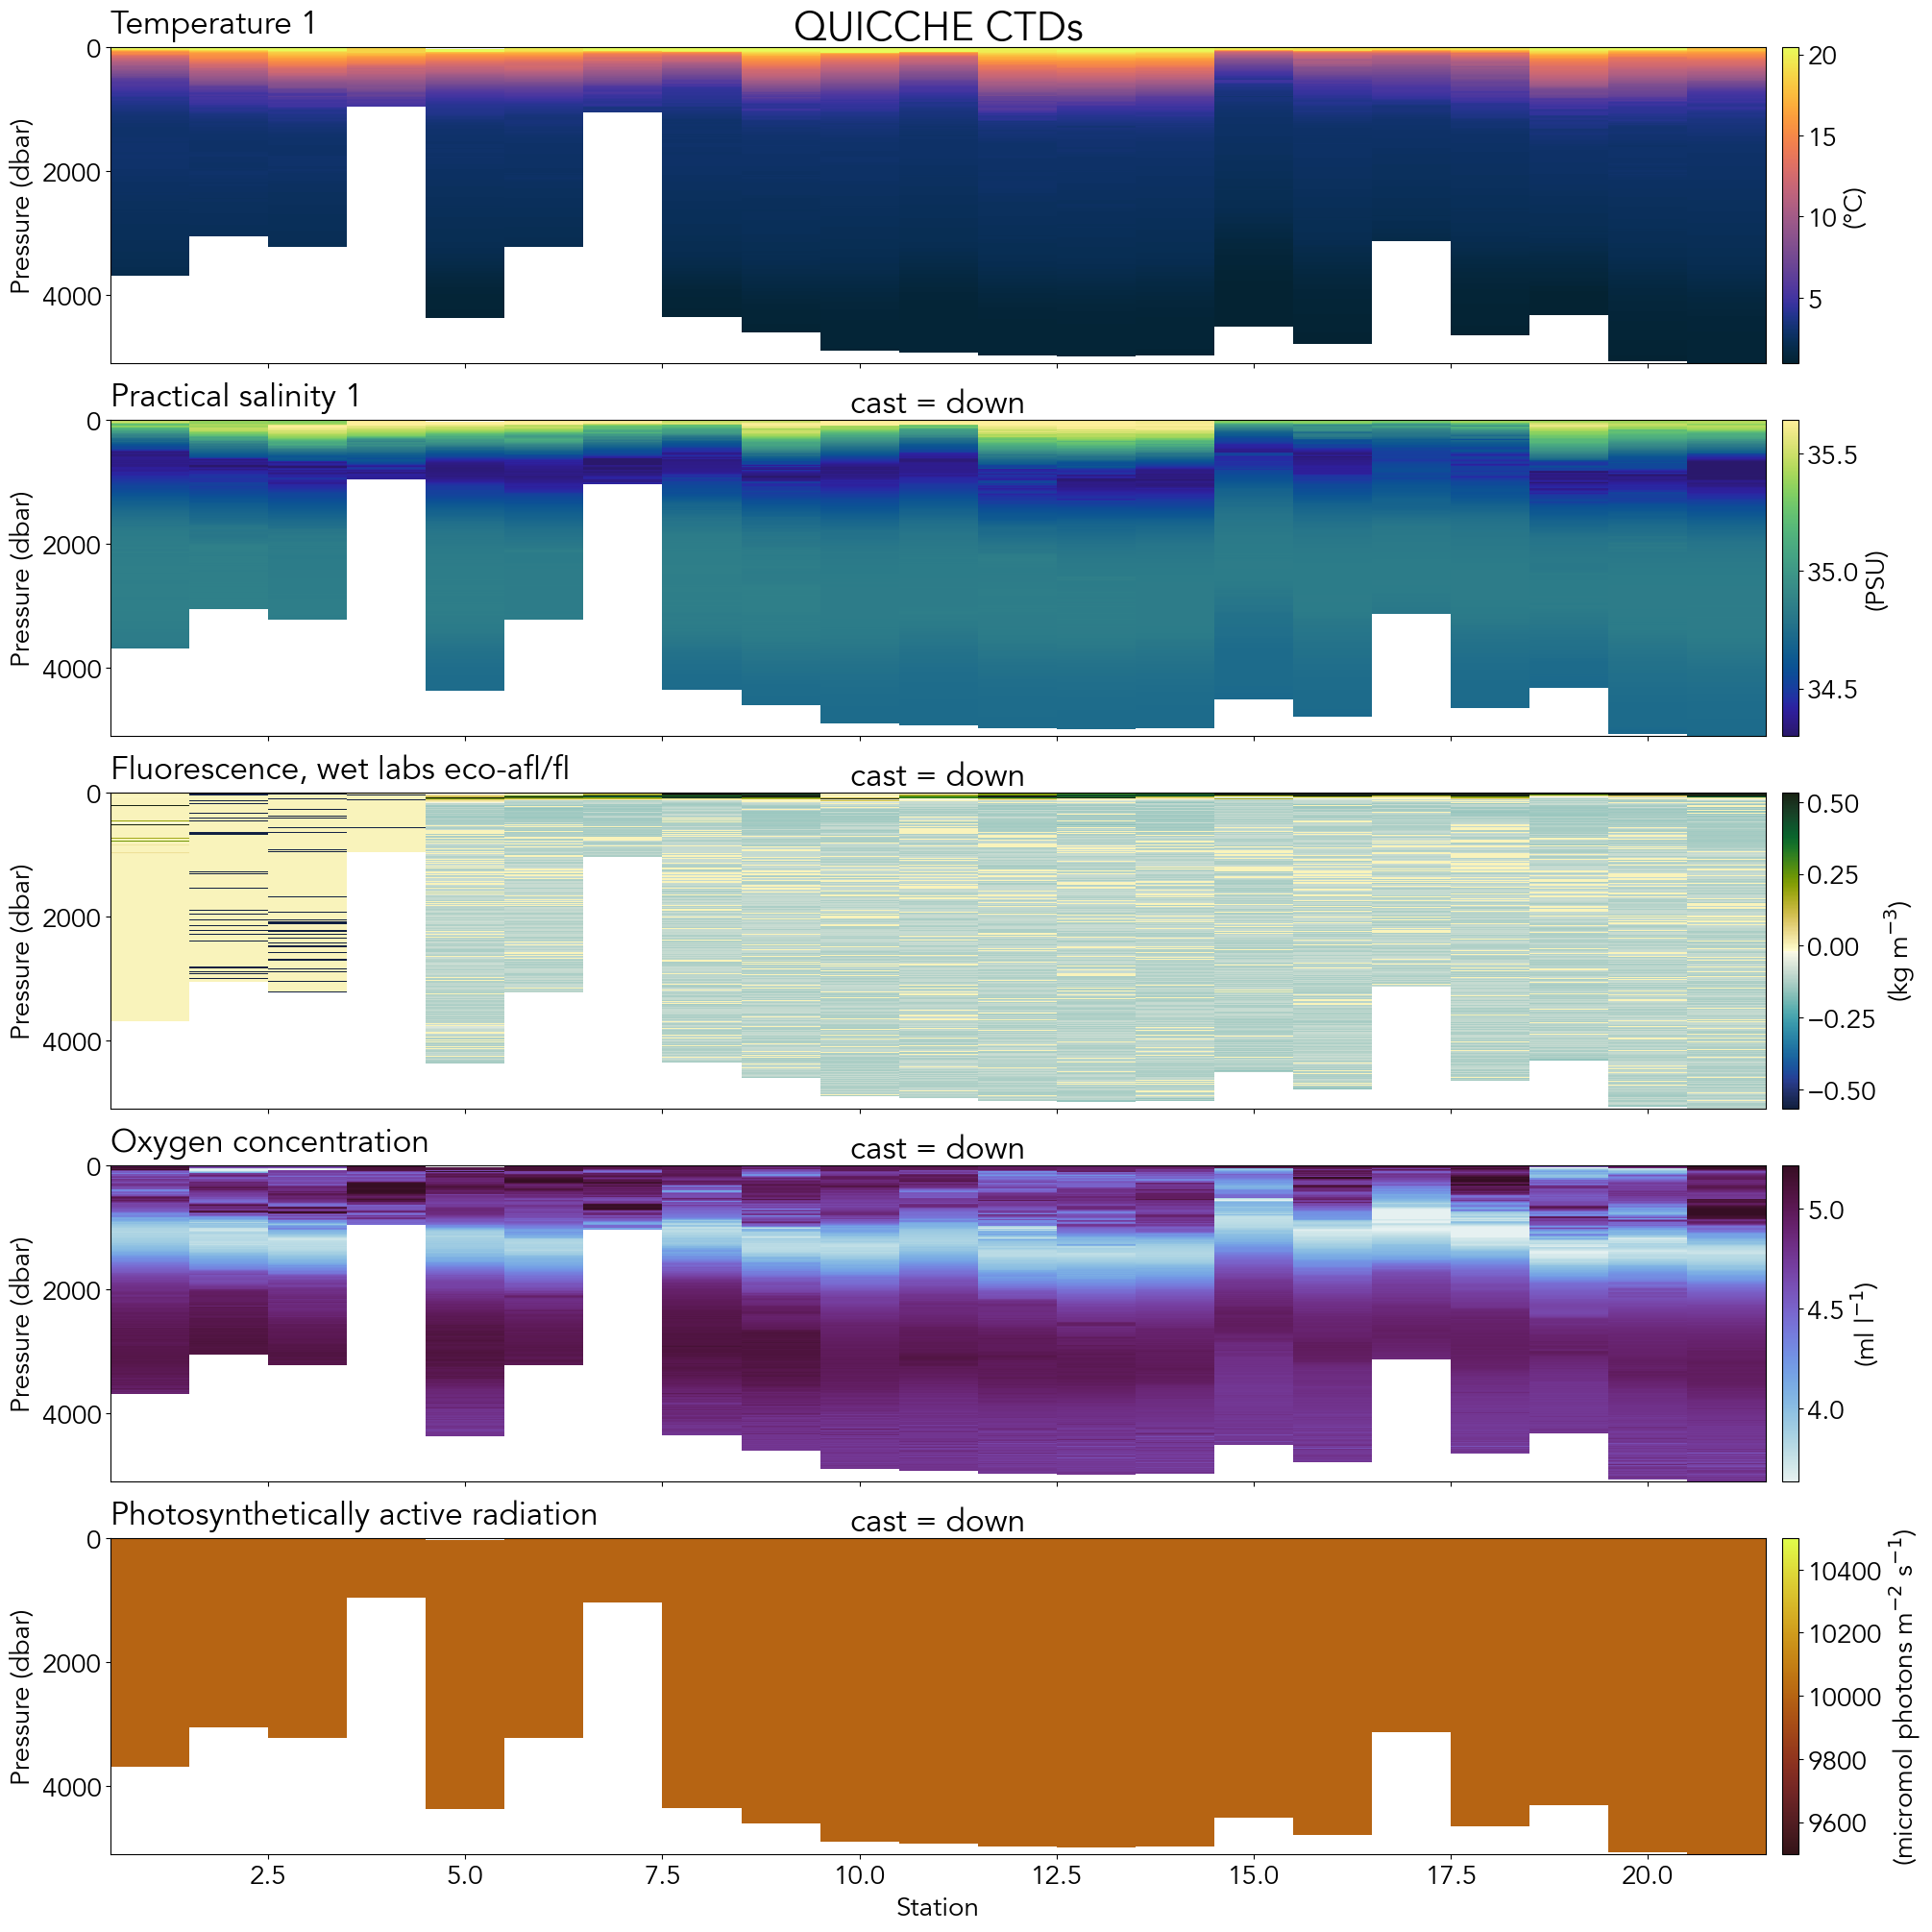

In [124]:
var = ['temperature1','salinity1','chlorophyll','oxygen_concentration','PAR']
cmap = [cmo.thermal,cmo.haline,cmo.delta,cmo.dense,'cmo.solar']

fig, ax = plt.subplots(len(var),1,figsize=(20,4*len(var)),sharex=True,constrained_layout=True)

for i,axs in enumerate(ax):
    z = ds[var[i]].squeeze()
    pcm = z.plot(y='pressure',cmap=cmap[i], ax=ax[i], add_colorbar=False,vmin=np.nanpercentile(z.data, 0.5),vmax = np.nanpercentile(z.data, 99.5))
    cb = plt.colorbar(pcm,label=f"({z.units})",pad=0.01)
    axs.set_title(ds[var[i]].attrs['long_name'].capitalize(),loc='left',y=1.02)
    axs.set(xlabel='',ylabel='Pressure (dbar)')
    axs.invert_yaxis()

axs.set(xlabel='Station') #,xticks=np.arange(1.25,12.25,1),xticklabels=np.arange(1,12,1).astype(str)
ax[0].set_title('QUICCHE CTDs',fontsize=30)

Text(0.5, 1.0, 'QUICCHE CTDs')

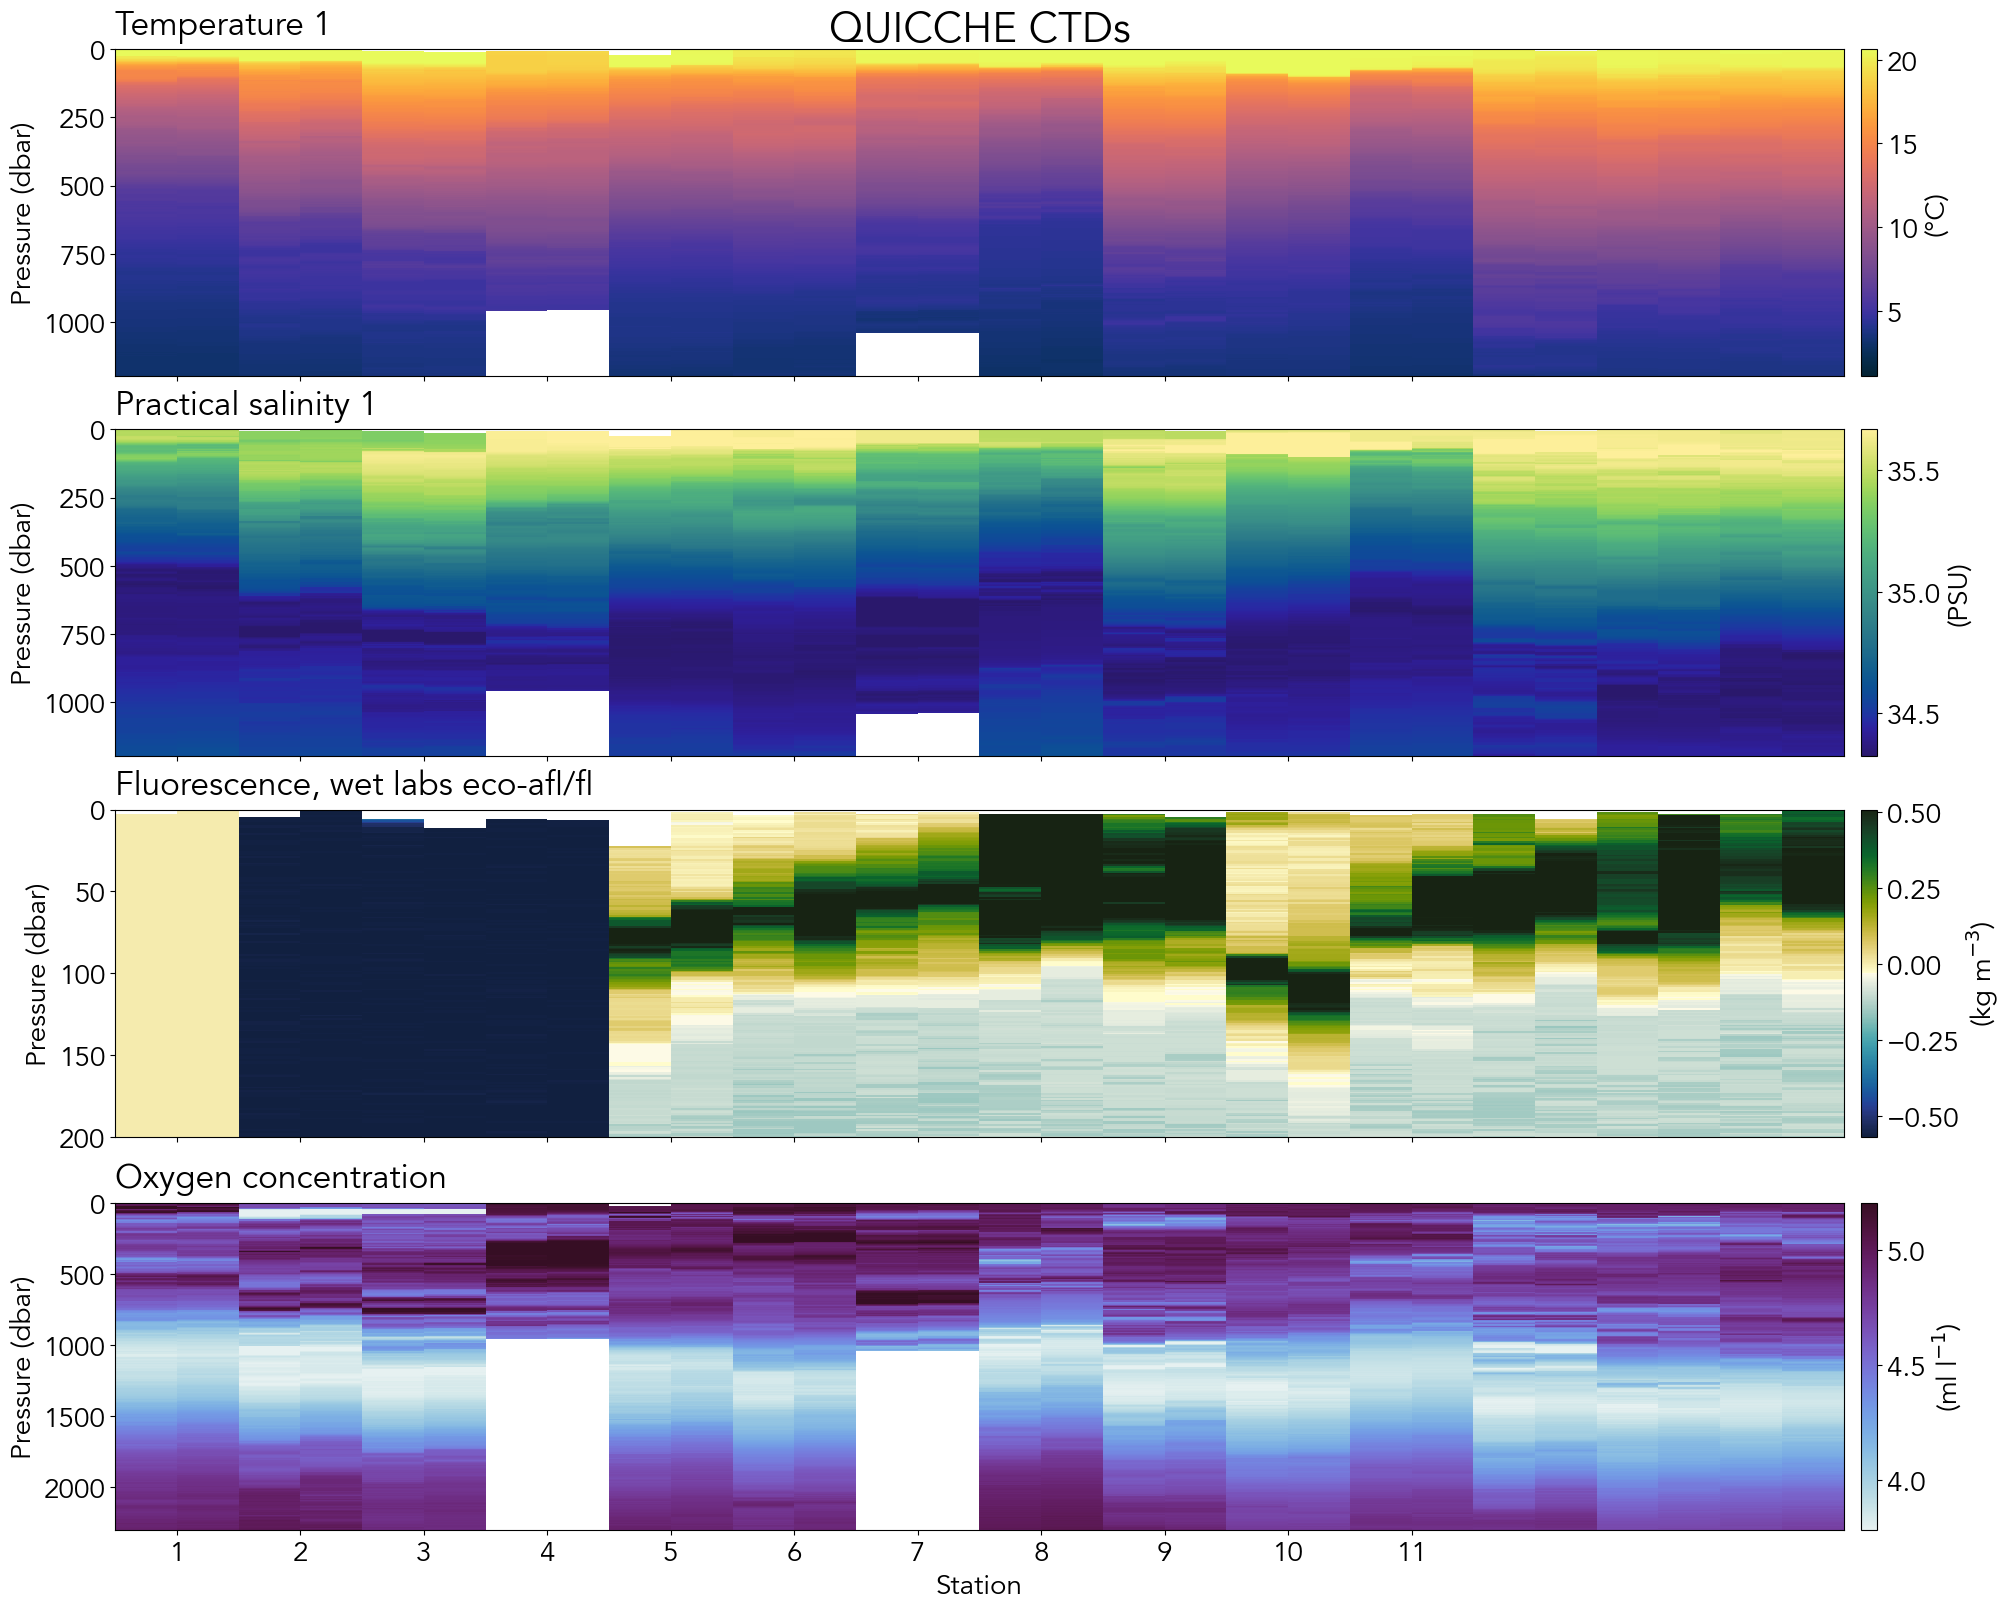

In [8]:
var = ['temperature1','salinity1','chlorophyll','oxygen_concentration']
cmap = [cmo.thermal,cmo.haline,cmo.delta,cmo.dense,'viridis']

fig, ax = plt.subplots(len(var),1,figsize=(20,4*len(var)),sharex=True,constrained_layout=True)

for i,axs in enumerate(ax):
    z = ds_merged[var[i]]
    pcm = z.plot(y='pressure',cmap=cmap[i], ax=ax[i], add_colorbar=False,vmin=np.nanpercentile(z.data, 0.5),vmax = np.nanpercentile(z.data, 99.5))
    cb = plt.colorbar(pcm,label=f"({z.units})",pad=0.01)
    axs.set_title(ds[var[i]].attrs['long_name'].capitalize(),loc='left',y=1.02)
    axs.set(xlabel='',ylabel='Pressure (dbar)',ylim=(0,[1200,1200,200,2300][i]))
    axs.invert_yaxis()

axs.set(xlabel='Station',xticks=np.arange(1.25,12.25,1),xticklabels=np.arange(1,12,1).astype(str))
ax[0].set_title('QUICCHE CTDs',fontsize=30)

# **2. Plot T/S-plots**

**Calculate a grid of density to use as a contour**

In [45]:
gsw.density.rho?

Signature: gsw.density.rho(SA, CT, p)
Docstring:
Calculates in-situ density from Absolute Salinity and Conservative
Temperature, using the computationally-efficient expression for
specific volume in terms of SA, CT and p  (Roquet et al., 2015).

Parameters
----------
SA : array-like
    Absolute Salinity, g/kg
CT : array-like
    Conservative Temperature (ITS-90), degrees C
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar

Returns
-------
rho : array-like, kg/m
    in-situ density
File:      ~/opt/miniconda3/envs/sbp/lib/python3.10/site-packages/gsw/_wrapped_ufuncs.py
Type:      function


In [4]:
mint=np.min(ds['temperature1'])
maxt=np.max(ds['temperature1'])

mins=np.min(ds['salinity1'])
maxs=np.max(ds['salinity1'])

tempL=np.linspace(mint-1,maxt+1,1000)

salL=np.linspace(mins-1,maxs+1,1000)

Tg, Sg = np.meshgrid(tempL,salL)
sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),1000)

In [5]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ListedColormap(['k','k','k','k','k','k','k','k','k','k','k',
          'k','k','k','k','k','k','crimson','crimson','crimson','crimson','crimson',])

In [6]:
ds['oxygen_concentration'] = ds['oxygen_concentration'] * 44.66

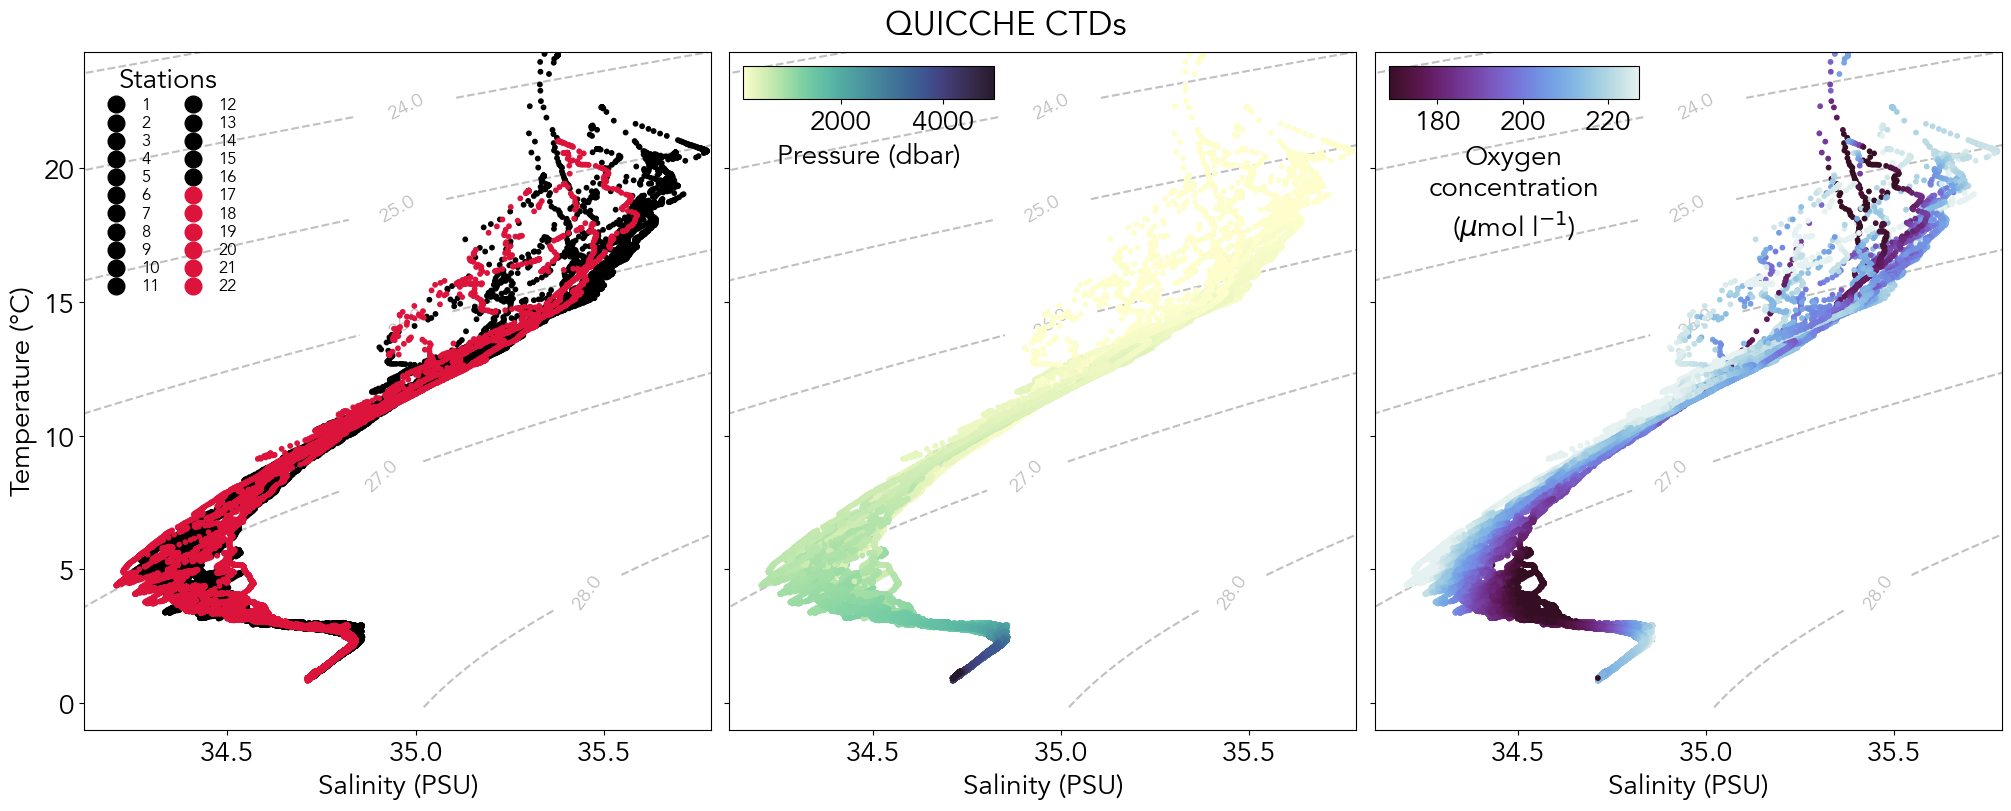

In [7]:
# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True, constrained_layout=True)

# Loop through each subplot
for i, axs in enumerate(ax):
    
    # Plot density lines
    cs = axs.contour(Sg, Tg, sigma_theta, colors='silver', linestyles='--', zorder=1)
    
    # Add labels to the contour lines
    cl = axs.clabel(cs, fontsize=14, inline=1, fmt='%.1f', zorder=1, inline_spacing=1e-9,
                     manual=[[34.7, 25], [35, 22], [35, 18], [35, 14], [35, 8], [35.5, 4]], use_clabeltext=True)
    
    # Set limits of the axes based on the data
    axs.set(xlim=[np.nanpercentile(ds['salinity1'], 1) - 0.2, np.nanpercentile(ds['salinity1'], 99) + 0.2],
            ylim=[np.nanpercentile(ds['temperature1'], 1) - 2, np.nanpercentile(ds['temperature1'], 99) + 5])

    # Create a scatter plot with the given data
    sct = ds.plot.scatter(x='salinity1',
                          y='temperature1',
                          hue=['station', 'pressure', 'oxygen_concentration'][i],
                          s=10,
                          ax=ax[i],
                          cmap=[colors, cmo.deep, cmo.dense_r][i],
                          add_guide=False,
                          zorder=2,
                          robust=True)
    
    # If not the first subplot, add a colorbar
    if i > 0:
        axins = inset_axes(axs, width="40%", height="5%", loc='upper left')
        cb = plt.colorbar(sct, cax=axins, pad=0.01,
                           label=['Pressure (dbar)', 'Oxygen\nconcentration\n($\mu$mol l$^{-1}$)'][i - 1],
                           orientation="horizontal", aspect=0.01)
        cb.ax.invert_yaxis()
    
    # Set the x and y labels and title for each subplot
    axs.set(xlabel=('Salinity (PSU)'),ylabel=['Temperature (°C)','',''][i],title='',xticks=np.arange(34.5,35.51,0.5))

for i in range(n):
    ax[0].scatter(100,100,c=[colors(1+i)[:3]],label=f'{i+1}')

ax[0].legend(ncol=2,
          labelspacing=0.1,
          handletextpad=0.5,
          fontsize=12,
          loc='upper left',
          columnspacing=1,
          frameon=False,
          #bbox_to_anchor=[1,1,0.3,0.025],
          title='Stations',
          markerscale=2)

fig.suptitle('QUICCHE CTDs')
plt.show()

# **3. Plot profiles**

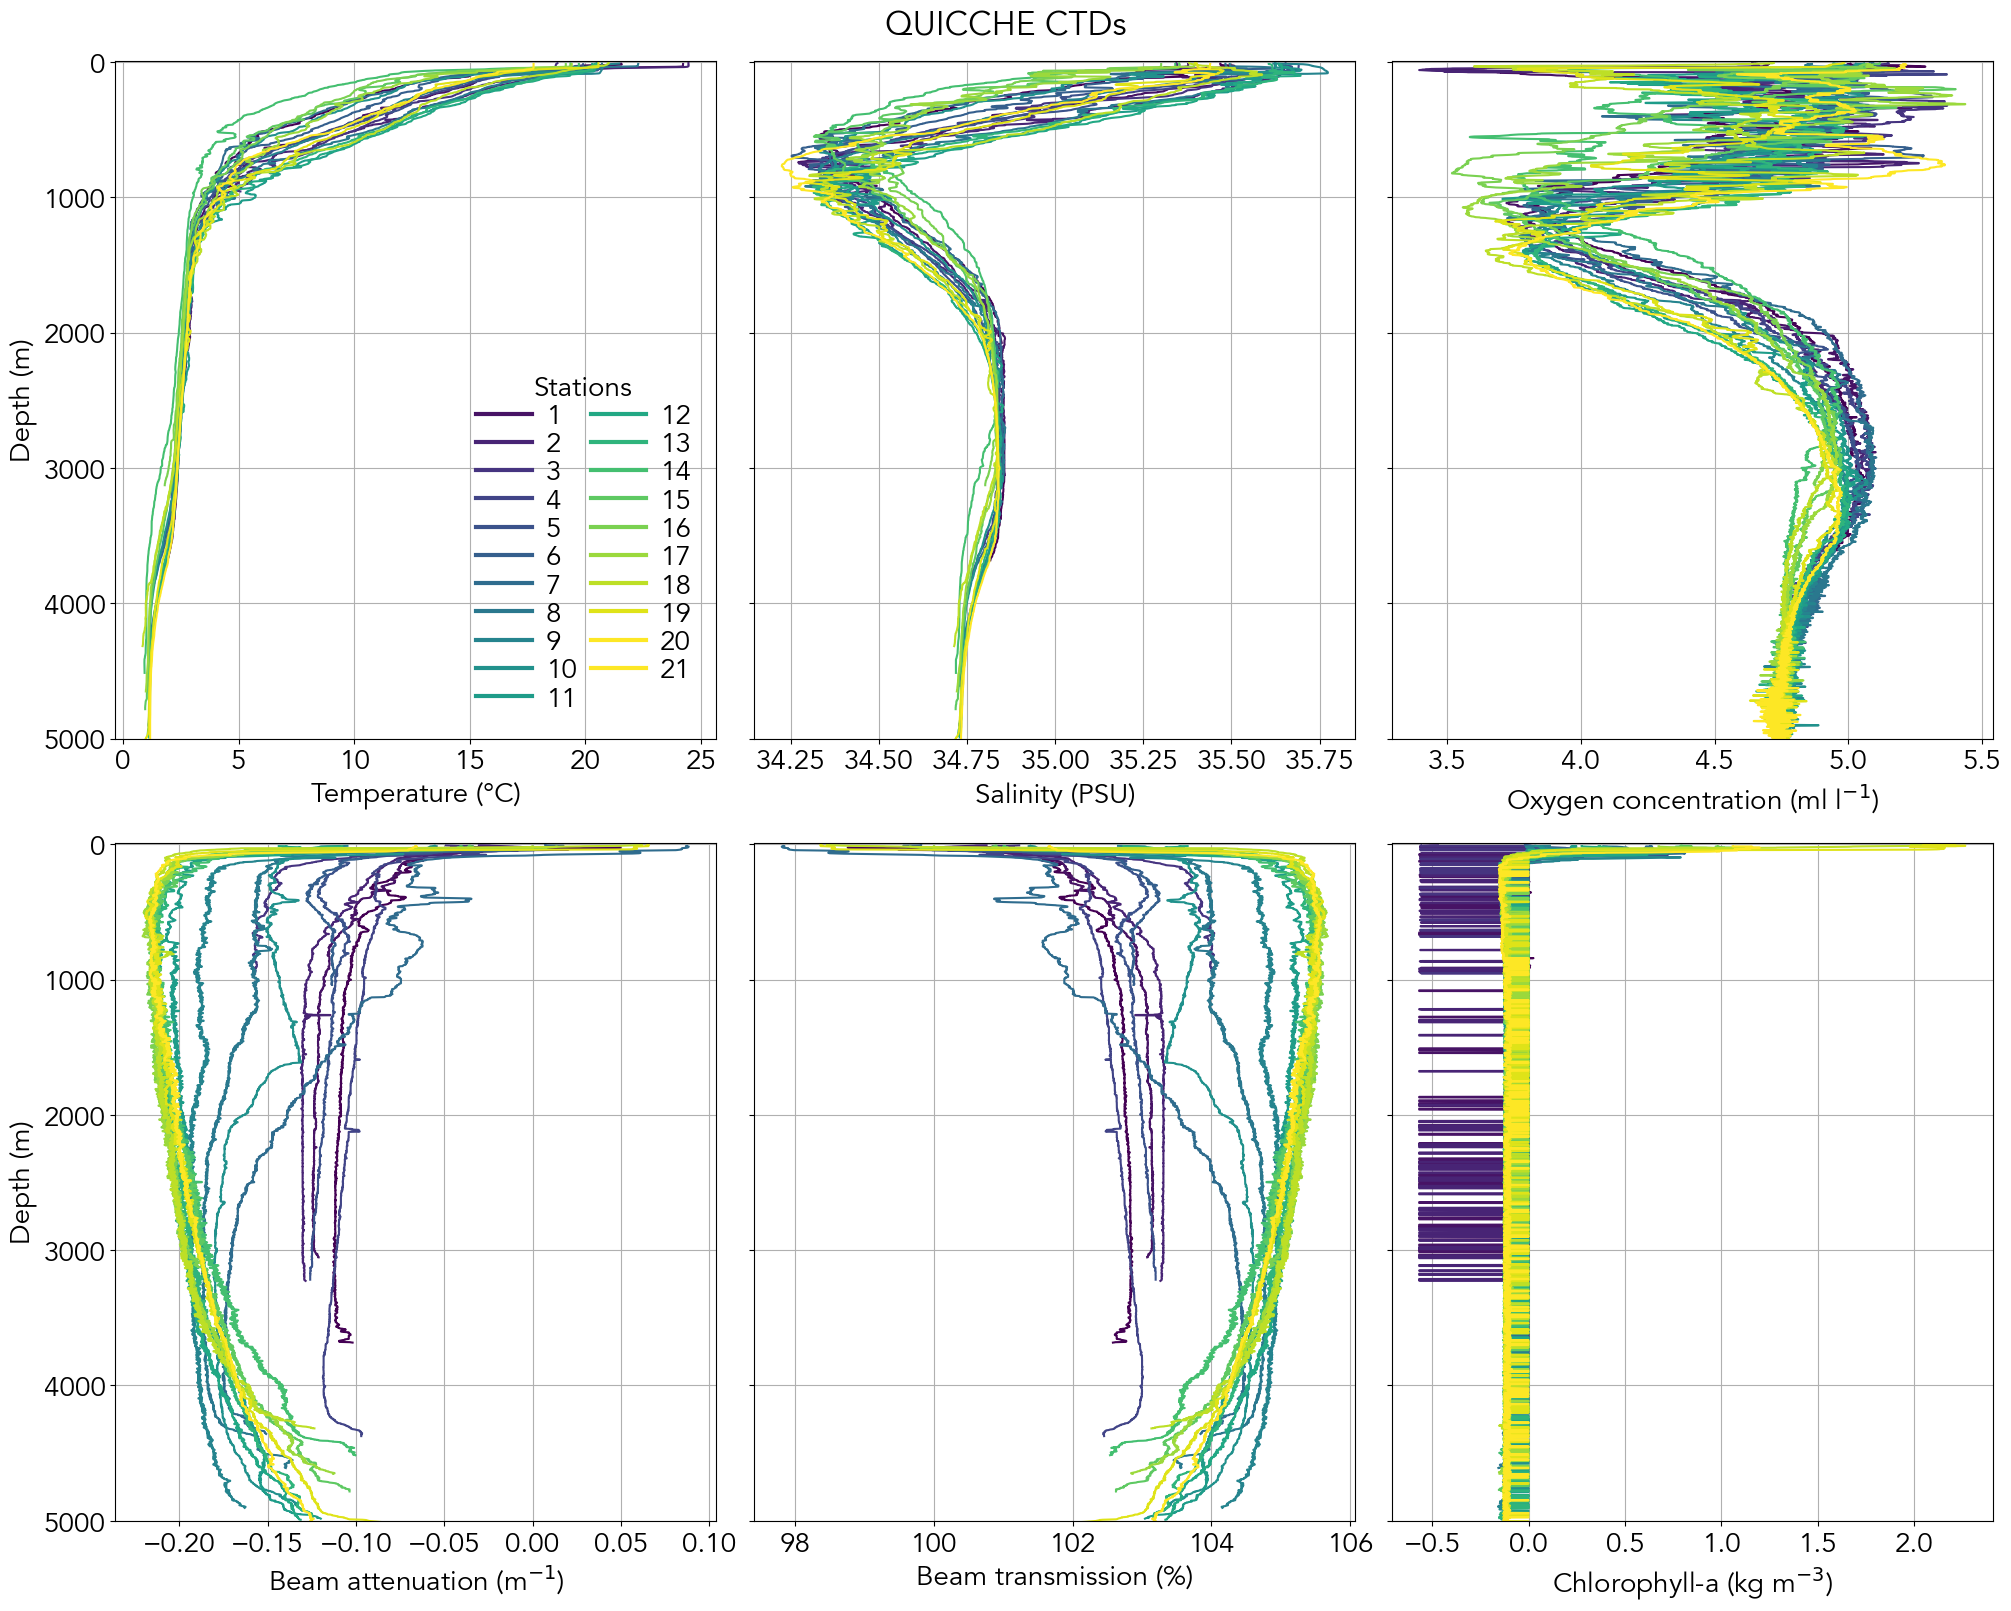

In [133]:
y = 5000
n = ds.station.max().values
cmap = plt.get_cmap('viridis',n)
var = ['temperature1','salinity1','oxygen_concentration','beam_attenuation','beam_transmission','chlorophyll']
legends = []

fig,ax=plt.subplots(2,3,figsize=(20,16),sharey=True,constrained_layout=True)
ax=ax.flatten()

for i in range(n):
    for j in range(len(var)):
        ds[var[j]].sel(station=i+1).squeeze().rolling(pressure=5,center=True).median('pressure').plot(y='pressure',hue='station',ax=ax[j],ylim=(y,-10),c=cmap(0+i)[:3])
        ax[j].set(title='',ylabel=['Depth (m)','','','Depth (m)','',''][j],xlabel=['Temperature (°C)',
                                                                                   'Salinity (PSU)',
                                                                                   'Oxygen concentration (ml l$^{-1}$)',
                                                                                   'Beam attenuation (m$^{-1}$)',
                                                                                   'Beam transmission (%)',
                                                                                   'Chlorophyll-a (kg m$^{-3}$)'][j])
        ax[j].grid()
        
    legends.append(Line2D([0], [0], color=cmap(1+i)[:3], lw=3, label=f'{1+i}'))
    
ax[0].legend(handles=legends,
             ncol=2,
             labelspacing=0.01,
             handletextpad=0.5,
             fontsize=20,
             loc='lower right',
             columnspacing=.5,
             frameon=False,
             title='Stations')

fig.suptitle('QUICCHE CTDs')
plt.show()

In [10]:
ds.mean('station')[var[j]]-ds.std('station')[var[j]]

<xarray.DataArray 'temperature1' (cast: 1, pressure: 5100)>
array([[   nan,    nan,    nan, ..., 1.105 , 1.1051, 1.1053]])
Coordinates:
  * cast      (cast) object 'down'
  * pressure  (pressure) int64 0 1 2 3 4 5 6 ... 5094 5095 5096 5097 5098 5099

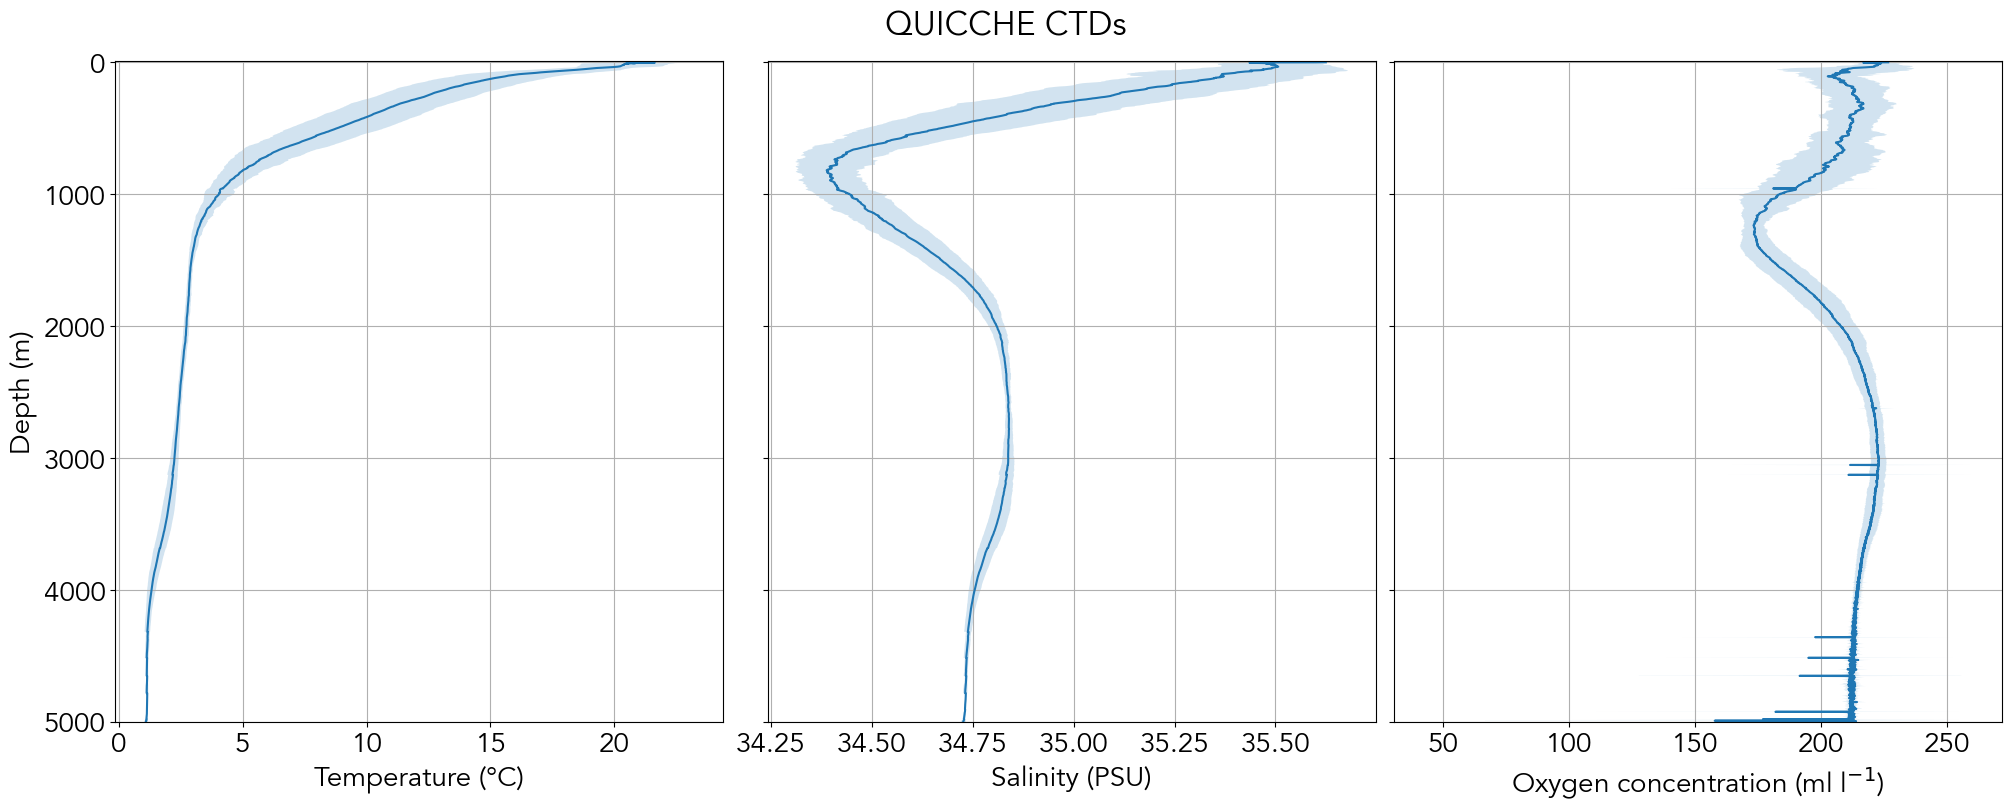

In [16]:
y = 5000
n = ds.station.max().values
cmap = plt.get_cmap('viridis',n)
var = ['temperature1','salinity1','oxygen_concentration']
legends = []

fig,ax=plt.subplots(1,3,figsize=(20,8),sharey=True,constrained_layout=True)
ax=ax.flatten()

for j in range(len(var)):
    ds.mean('station')[var[j]].plot(y='pressure',ax=ax[j],ylim=(y,-10))
    ax[j].fill_betweenx(ds.pressure,
                        (ds.mean('station')[var[j]]-ds.std('station')[var[j]]).squeeze(),
                        (ds.mean('station')[var[j]]+ds.std('station')[var[j]]).squeeze(),zorder=1,alpha=0.2,)

    ax[j].set(title='',ylabel=['Depth (m)','','','Depth (m)','',''][j],
              xlabel=['Temperature (°C)',
                       'Salinity (PSU)',
                       'Oxygen concentration (ml l$^{-1}$)',
                       'Beam attenuation (m$^{-1}$)',
                       'Beam transmission (%)',
                       'Chlorophyll-a (kg m$^{-3}$)'][j])
    ax[j].grid()

fig.suptitle('QUICCHE CTDs')
plt.show()

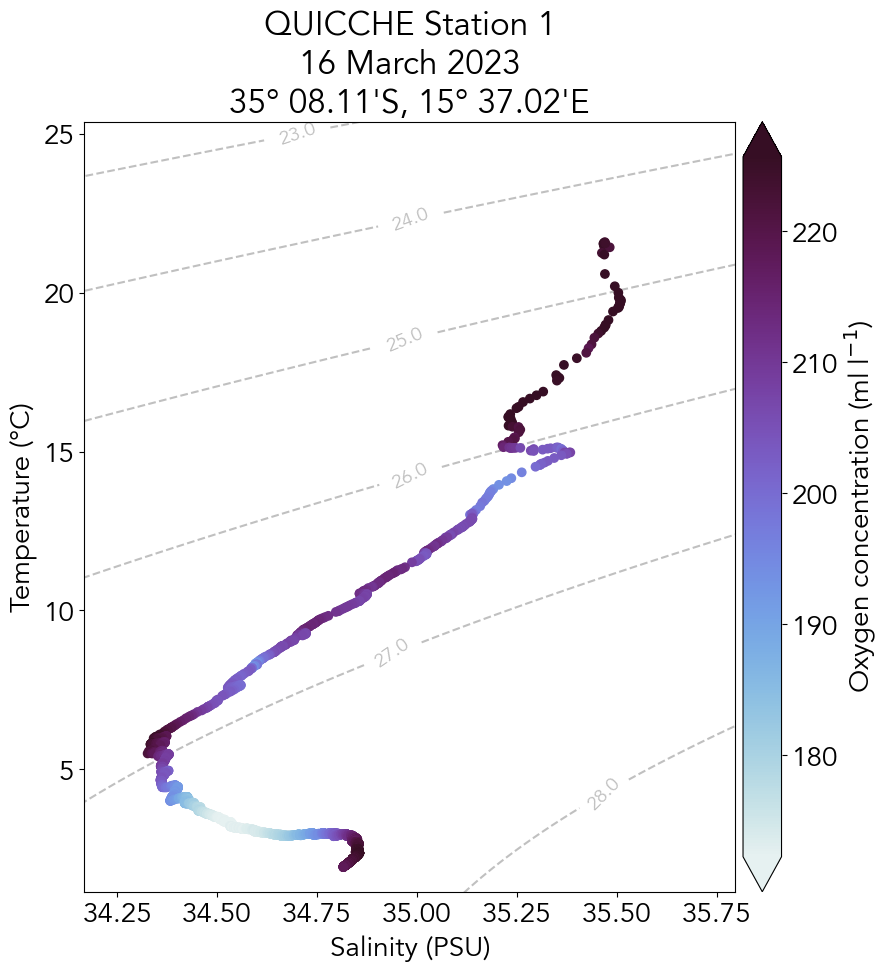

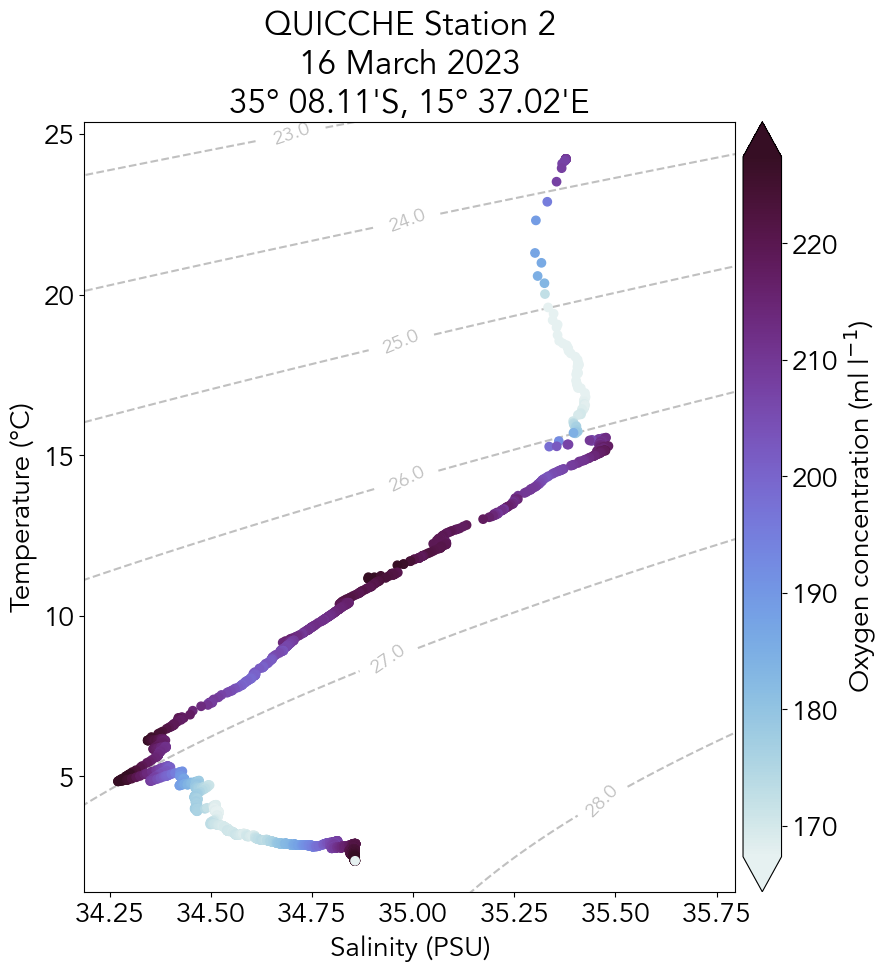

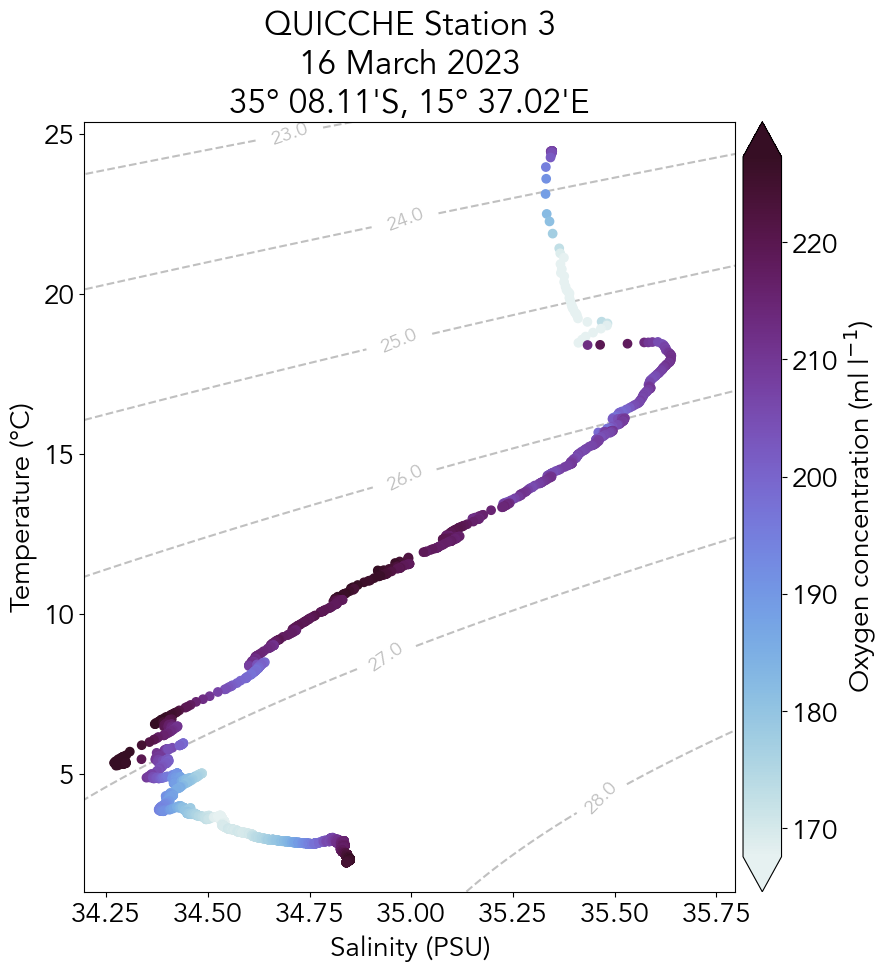

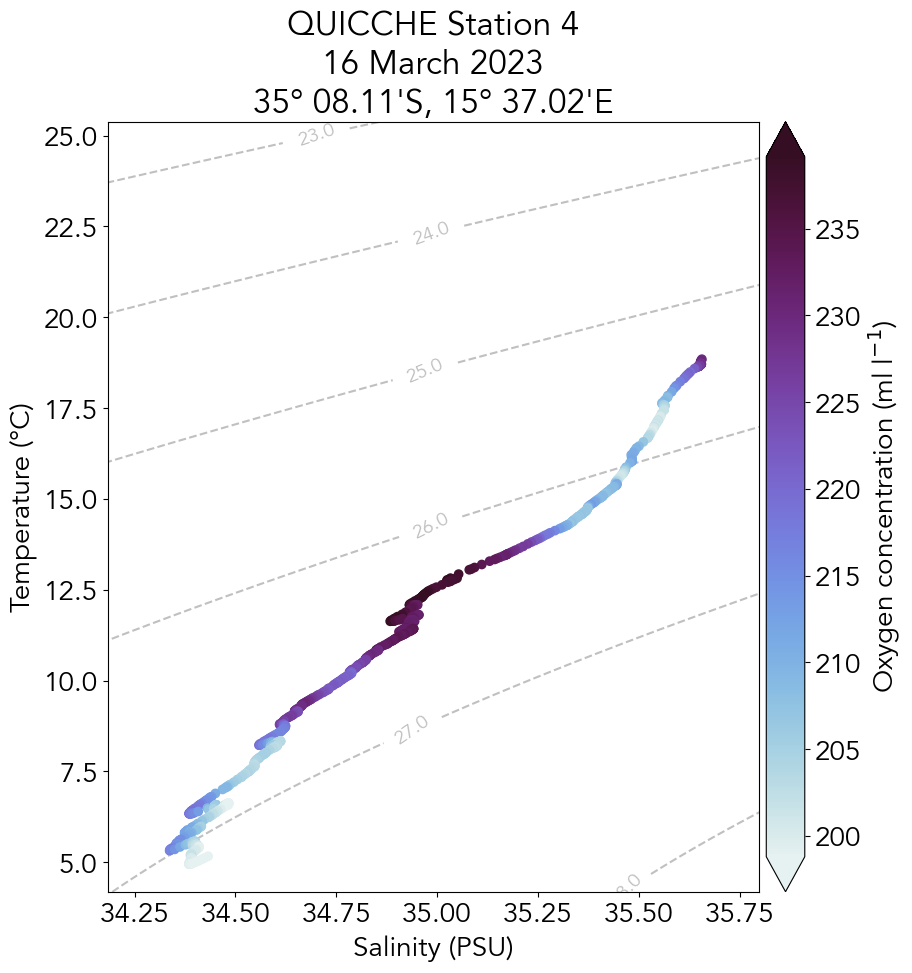

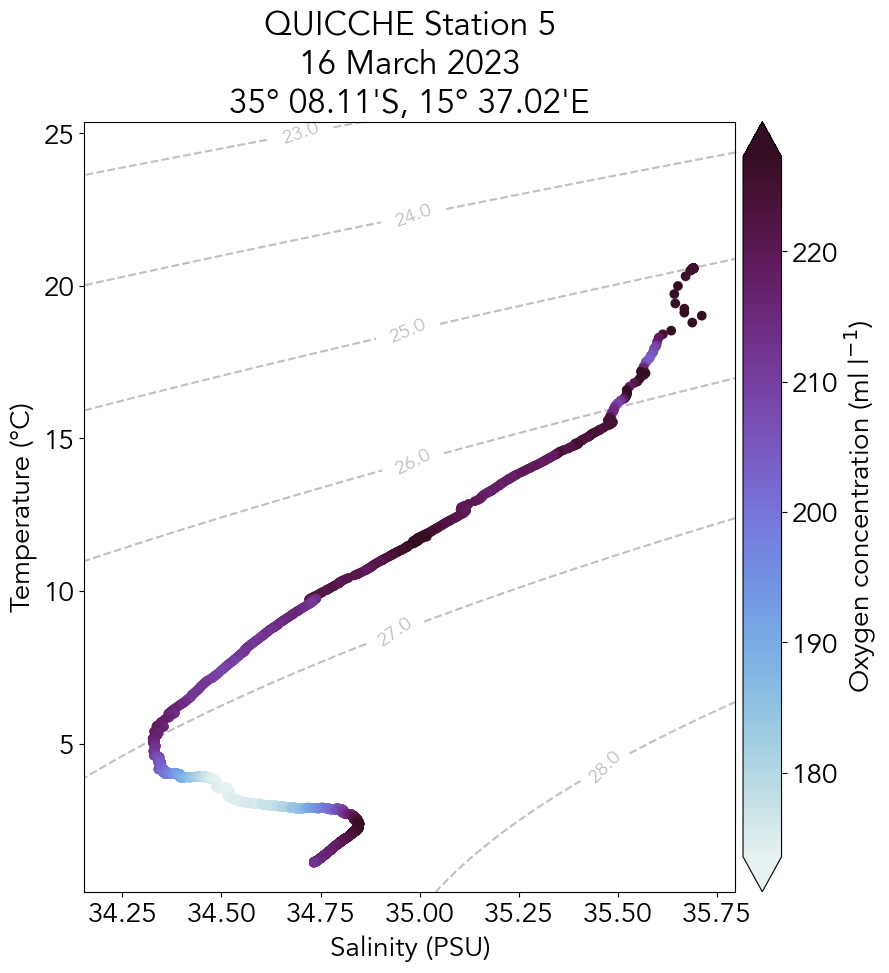

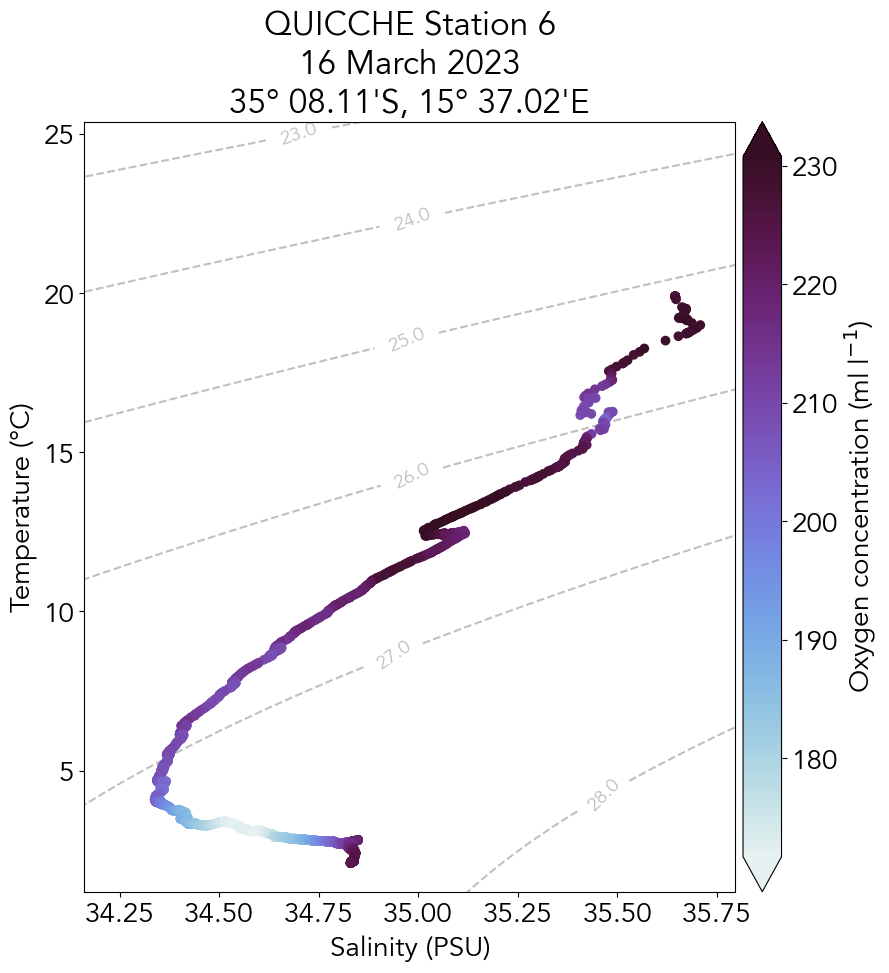

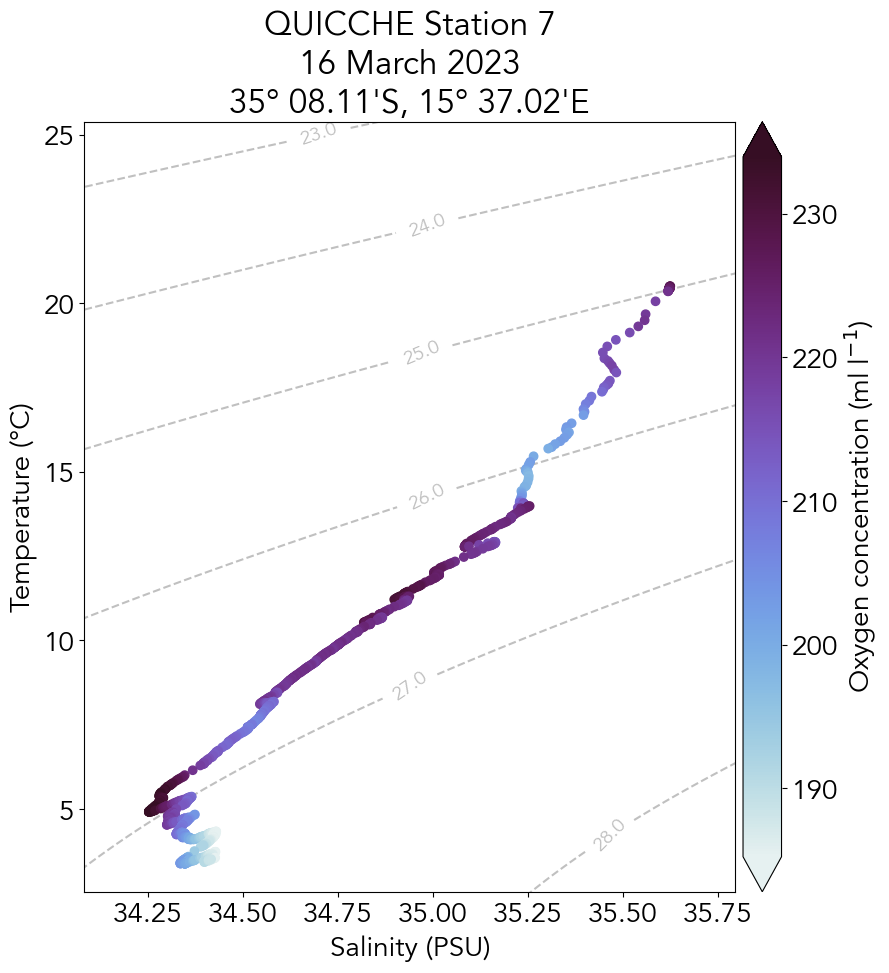

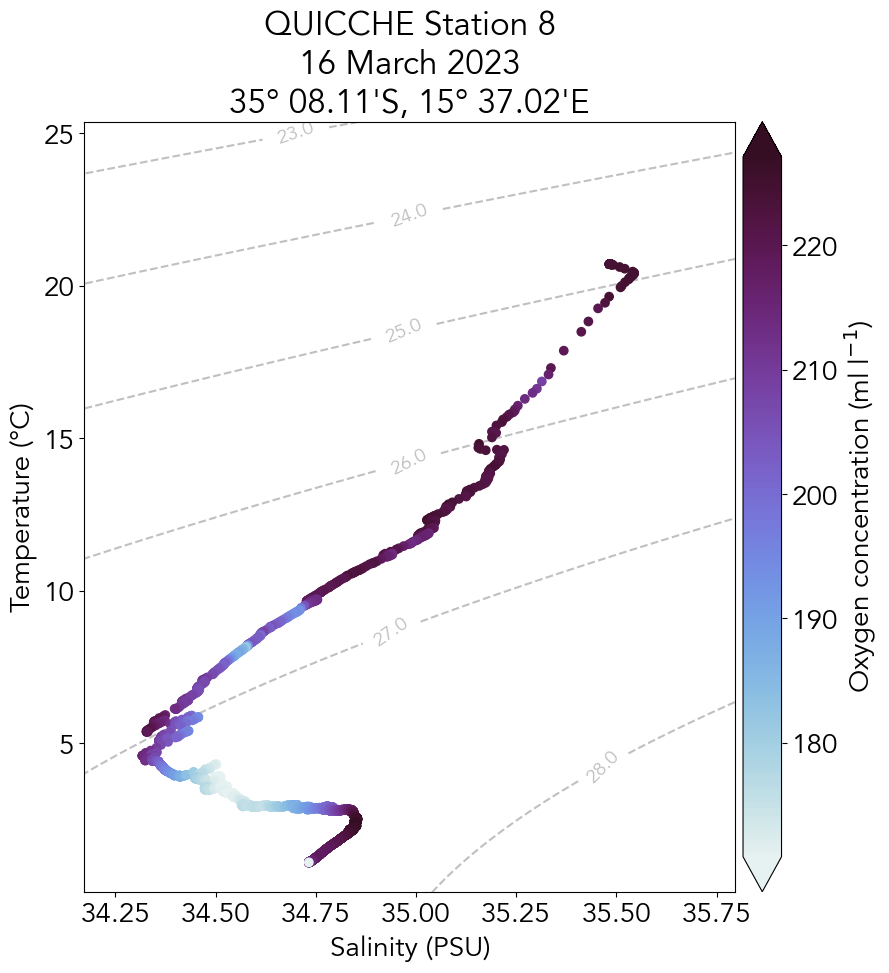

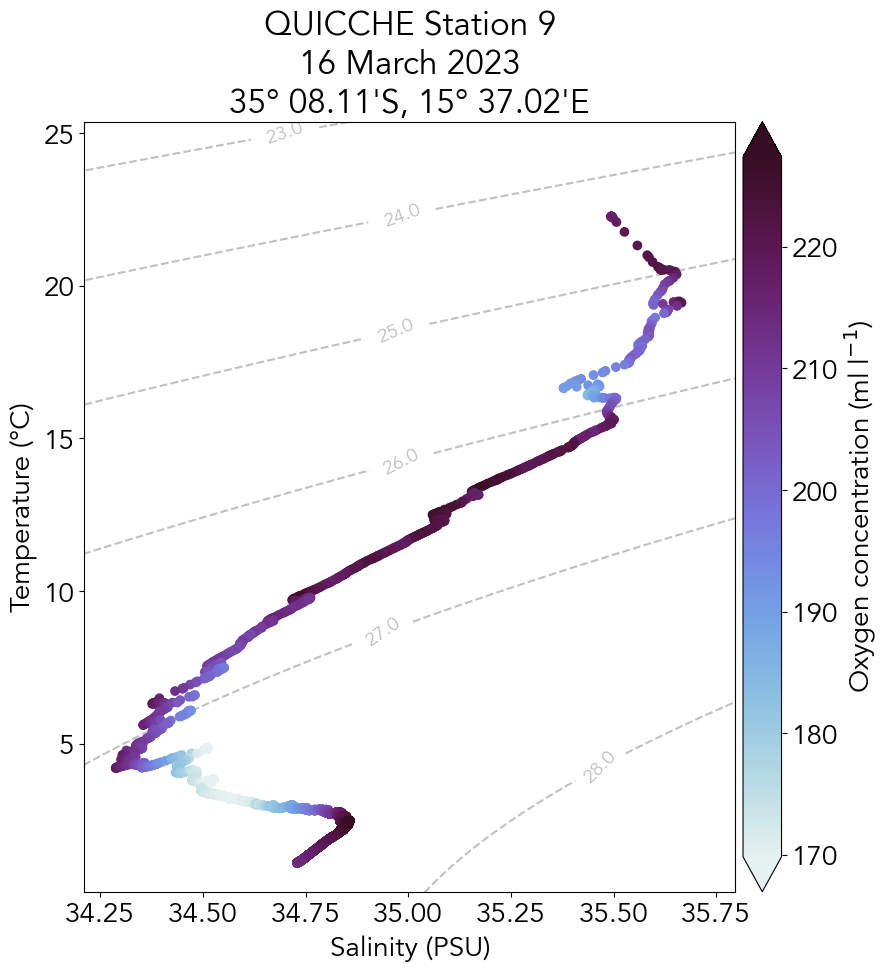

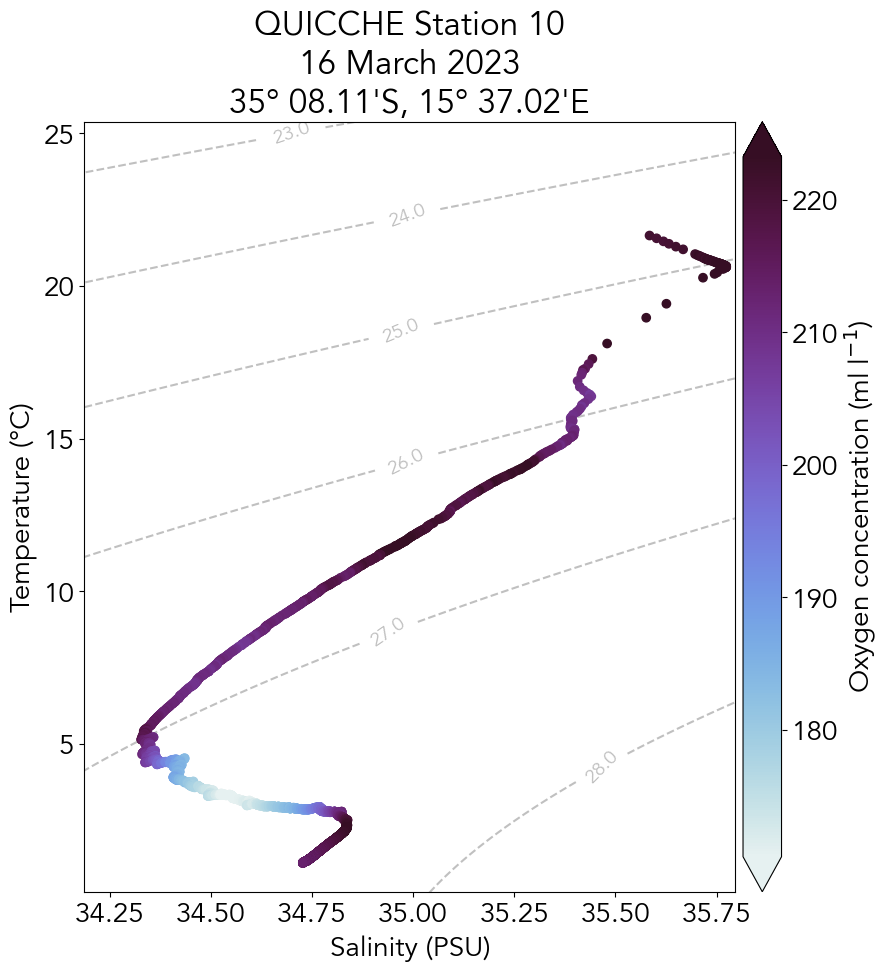

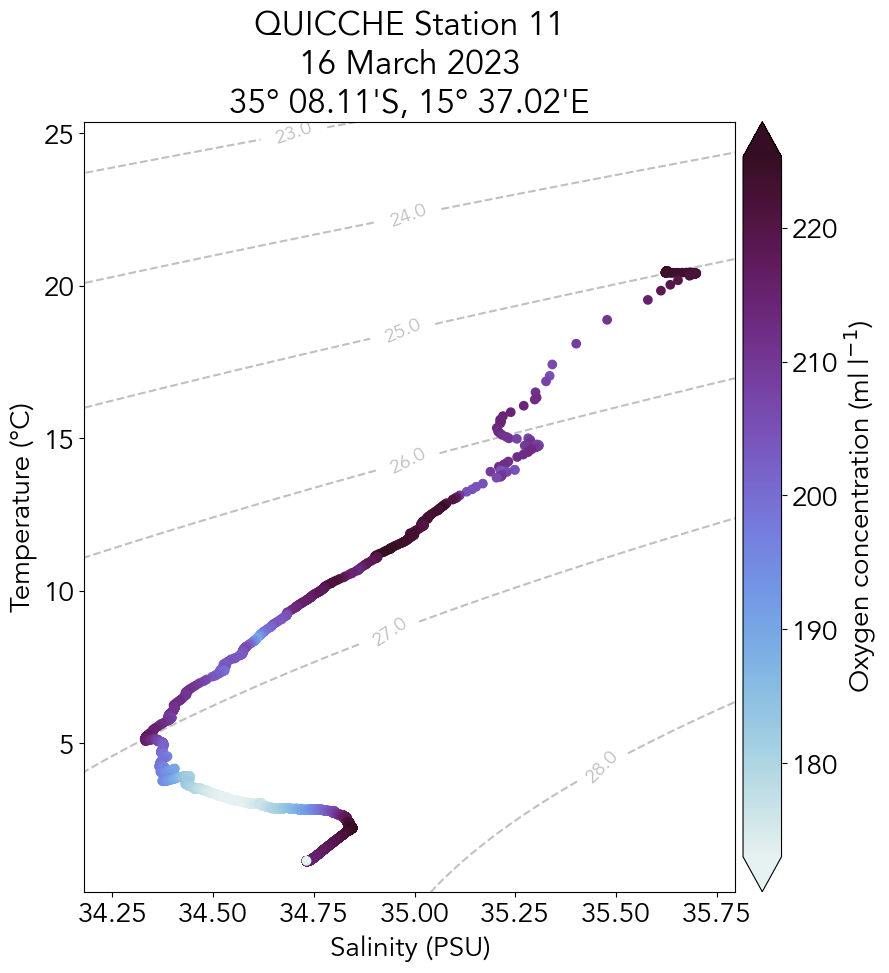

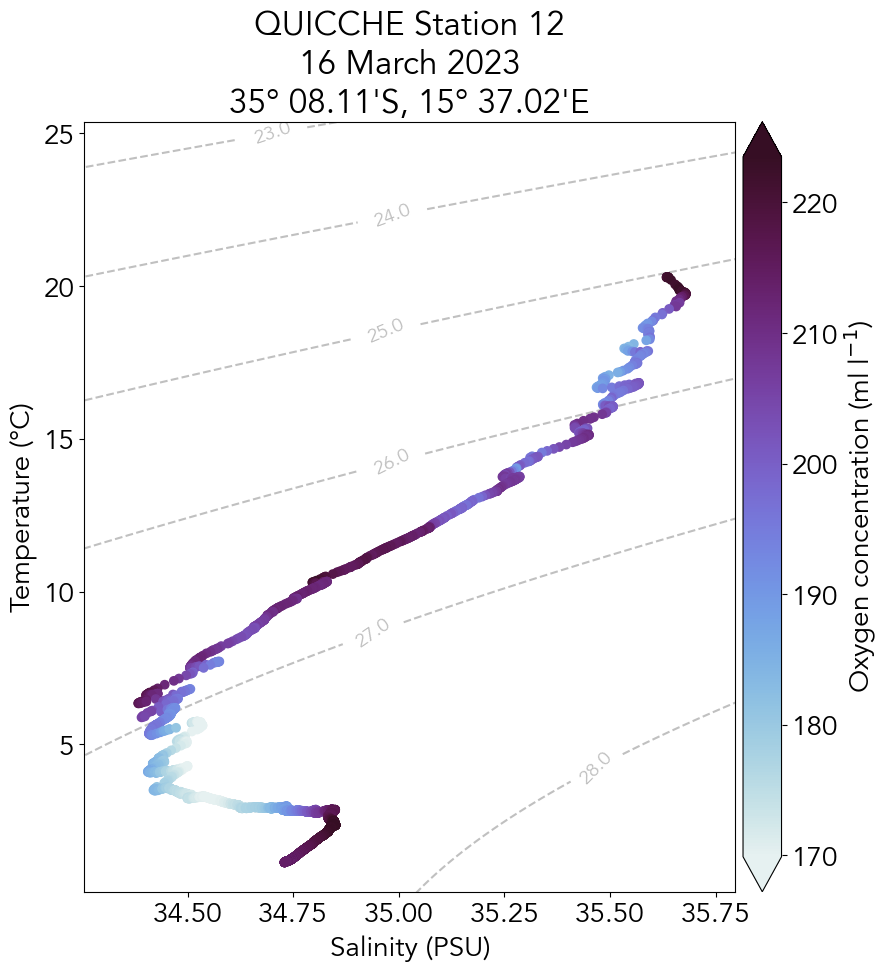

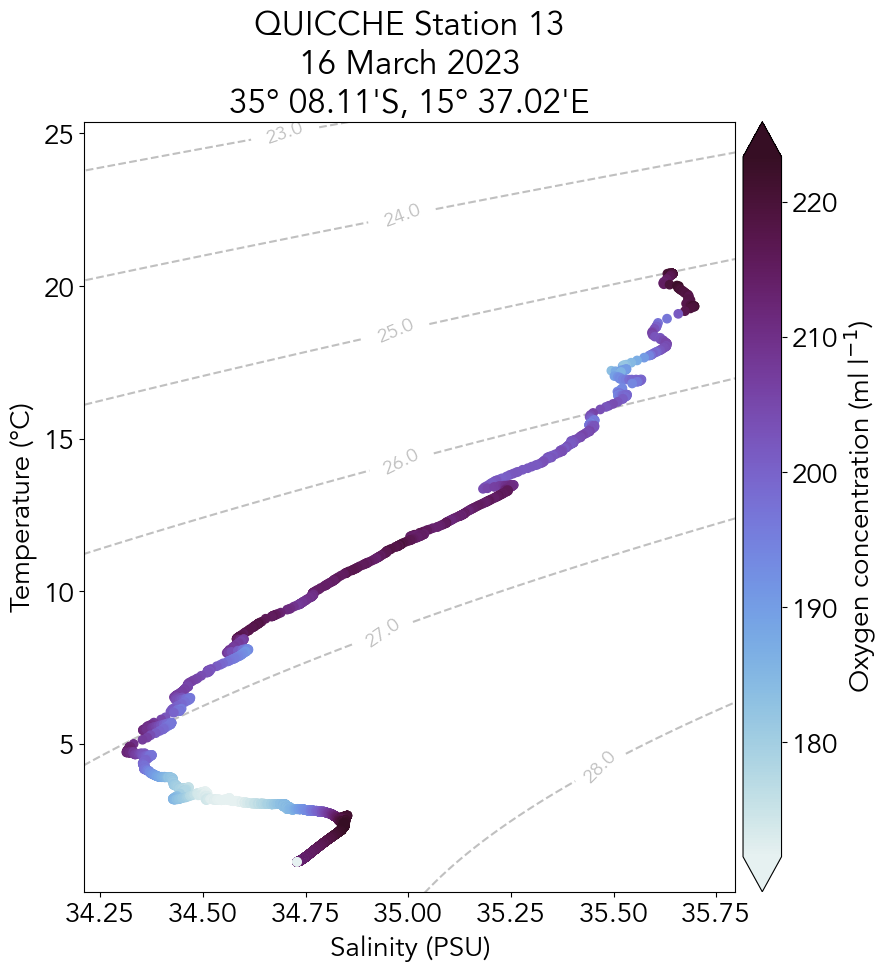

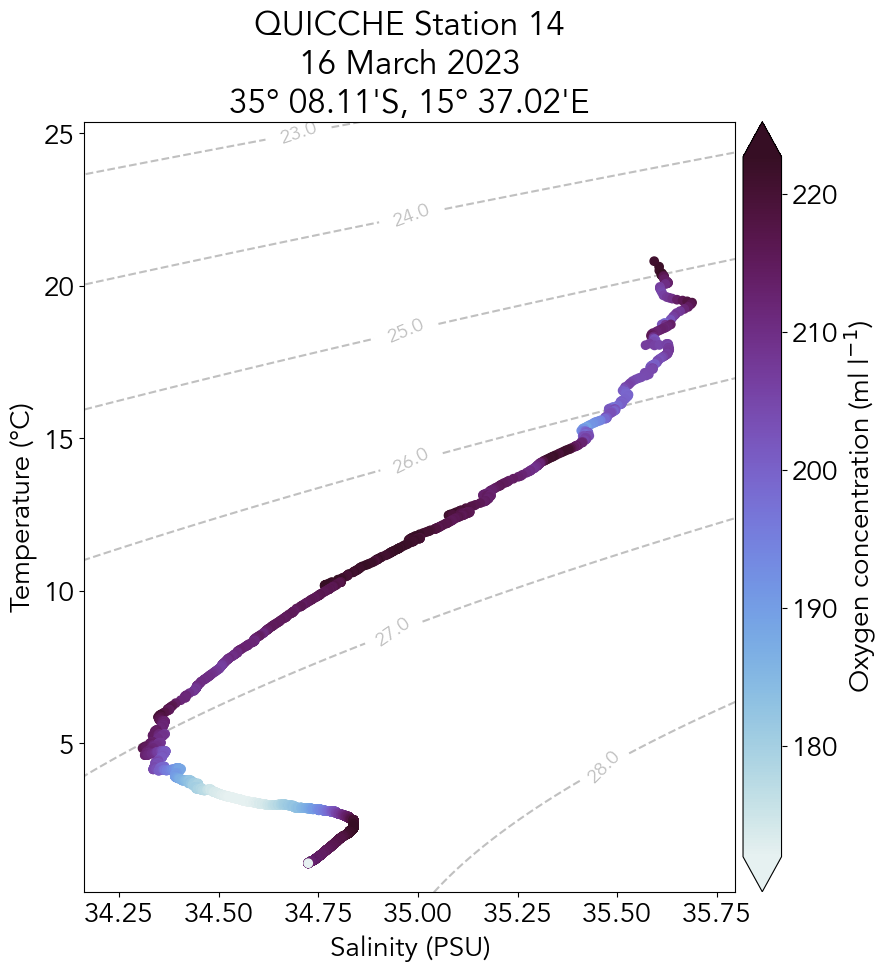

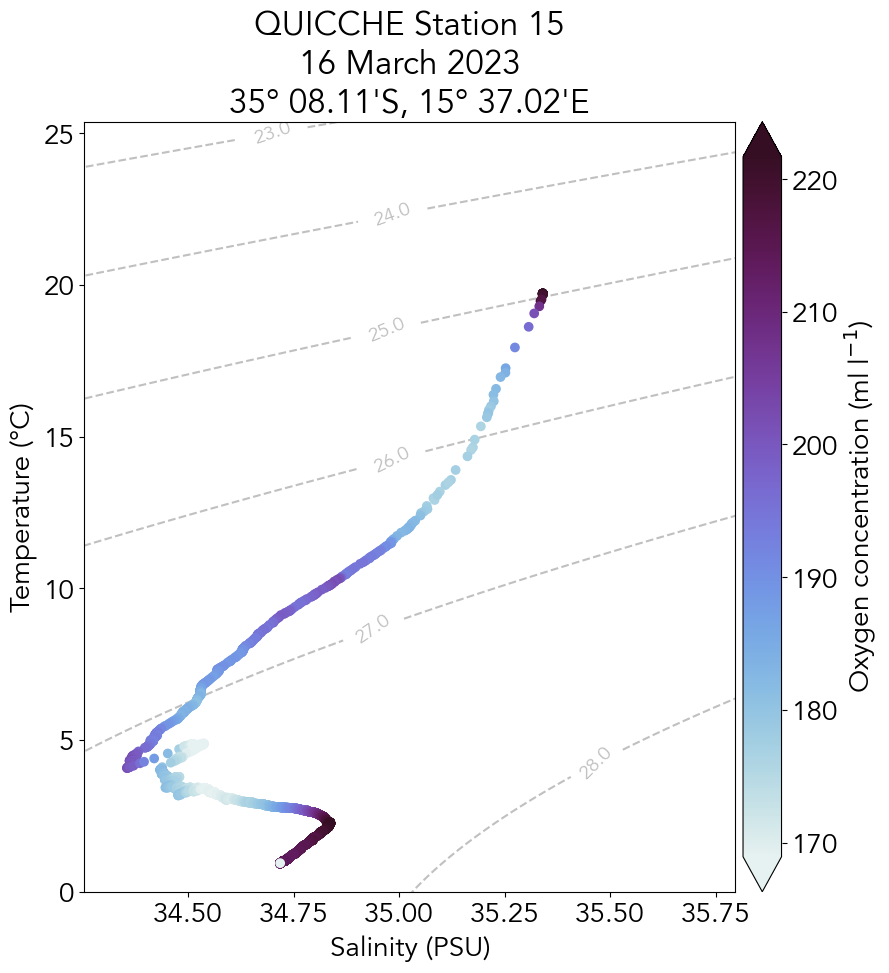

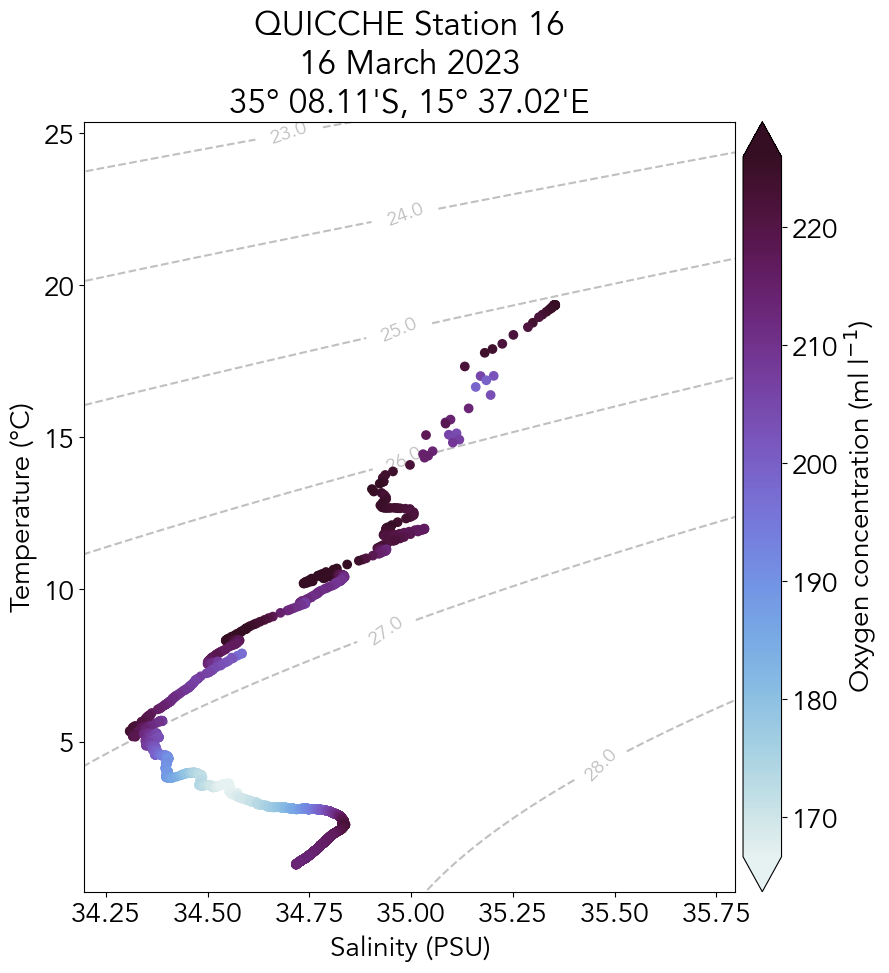

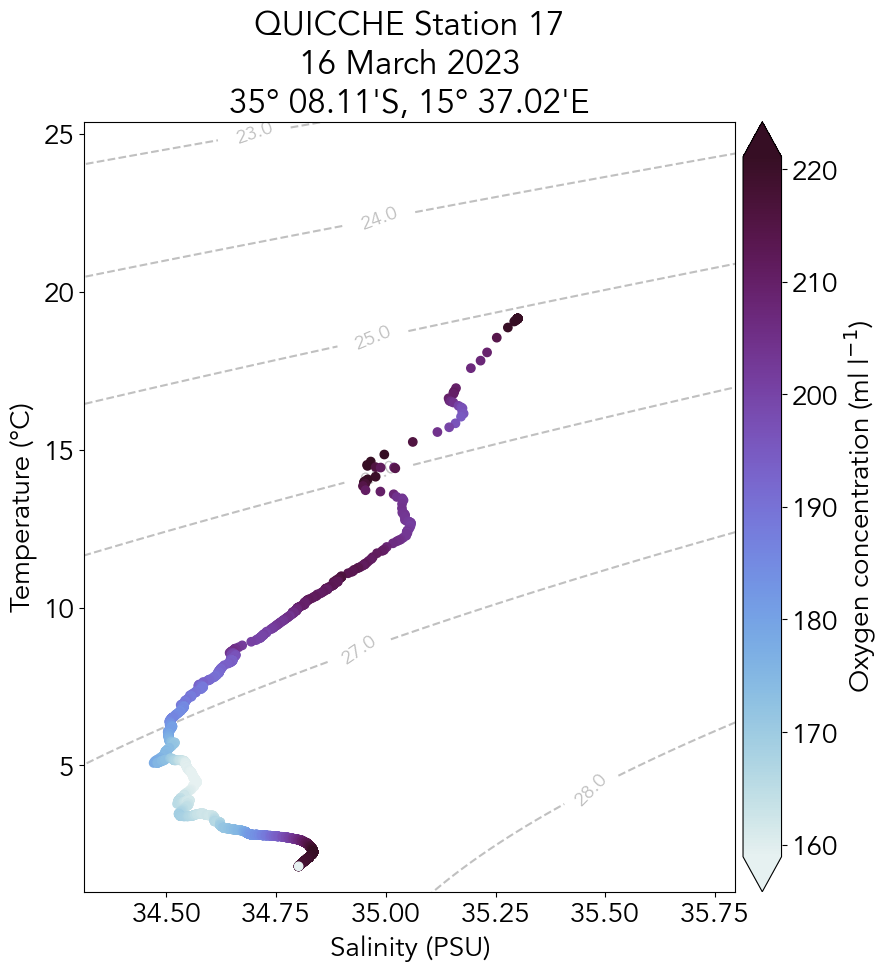

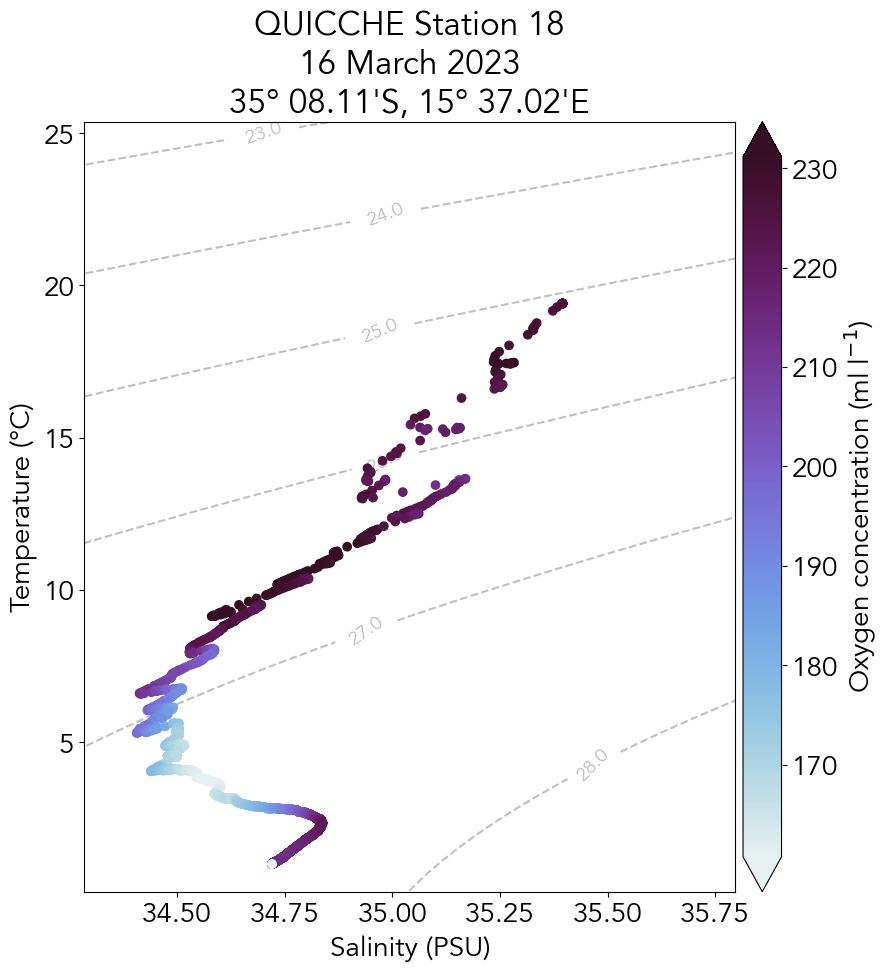

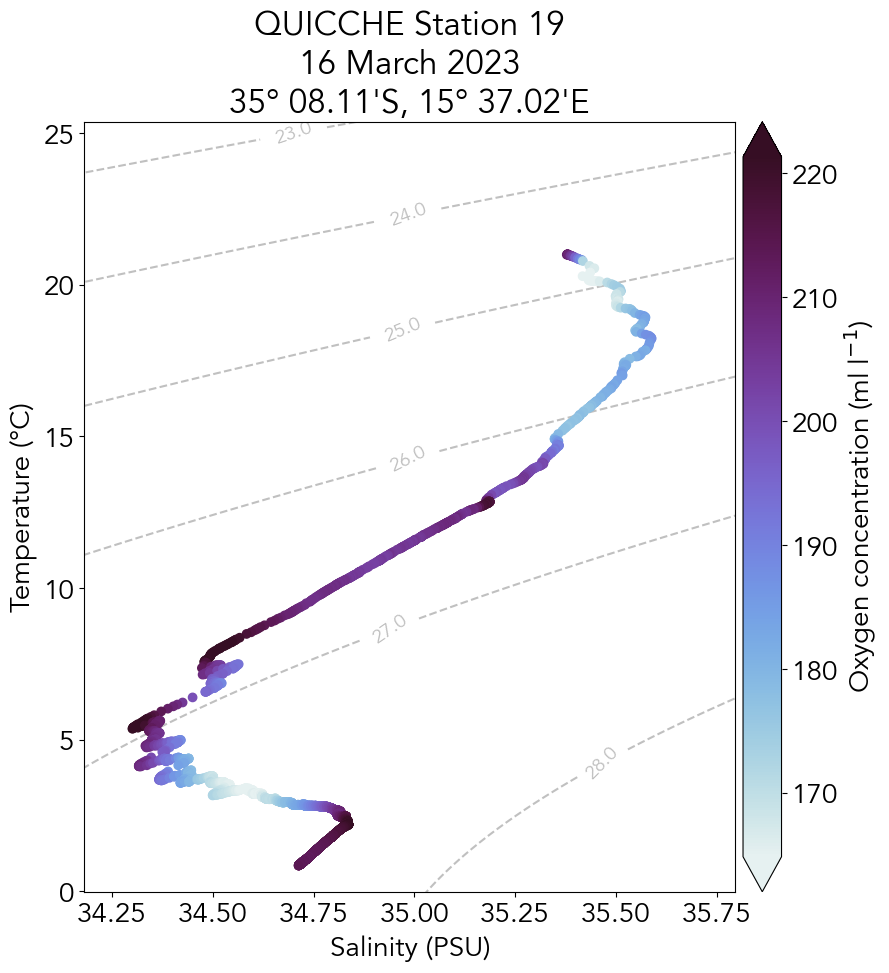

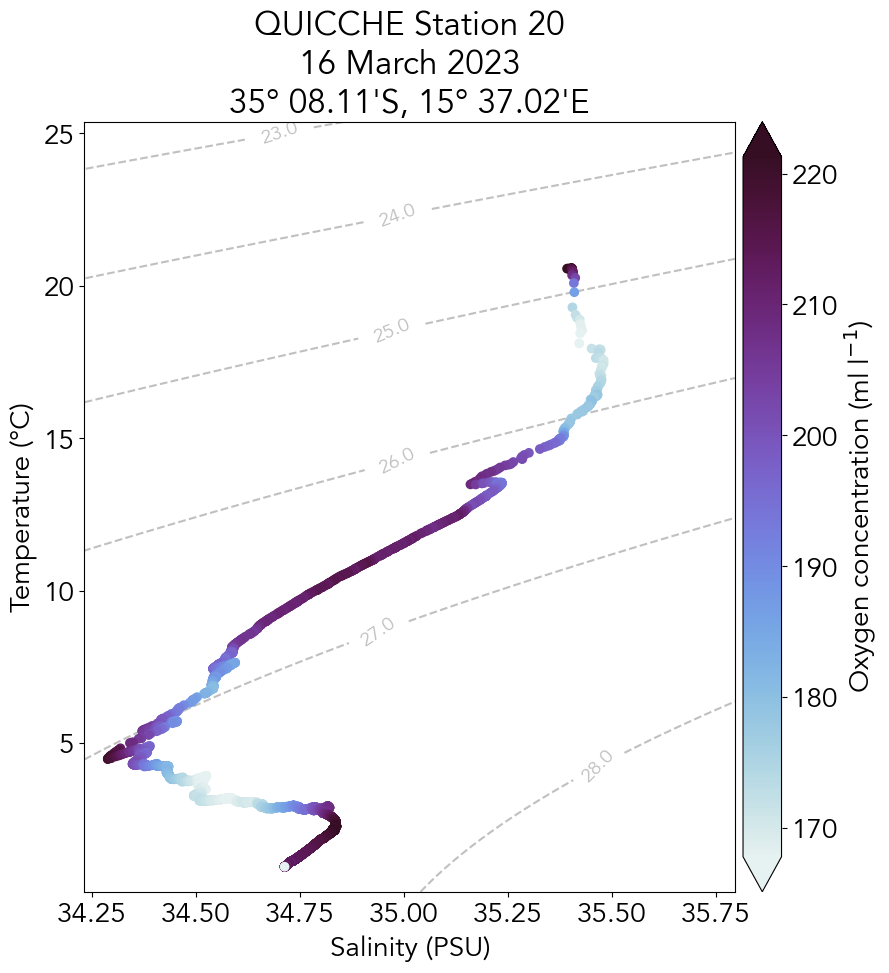

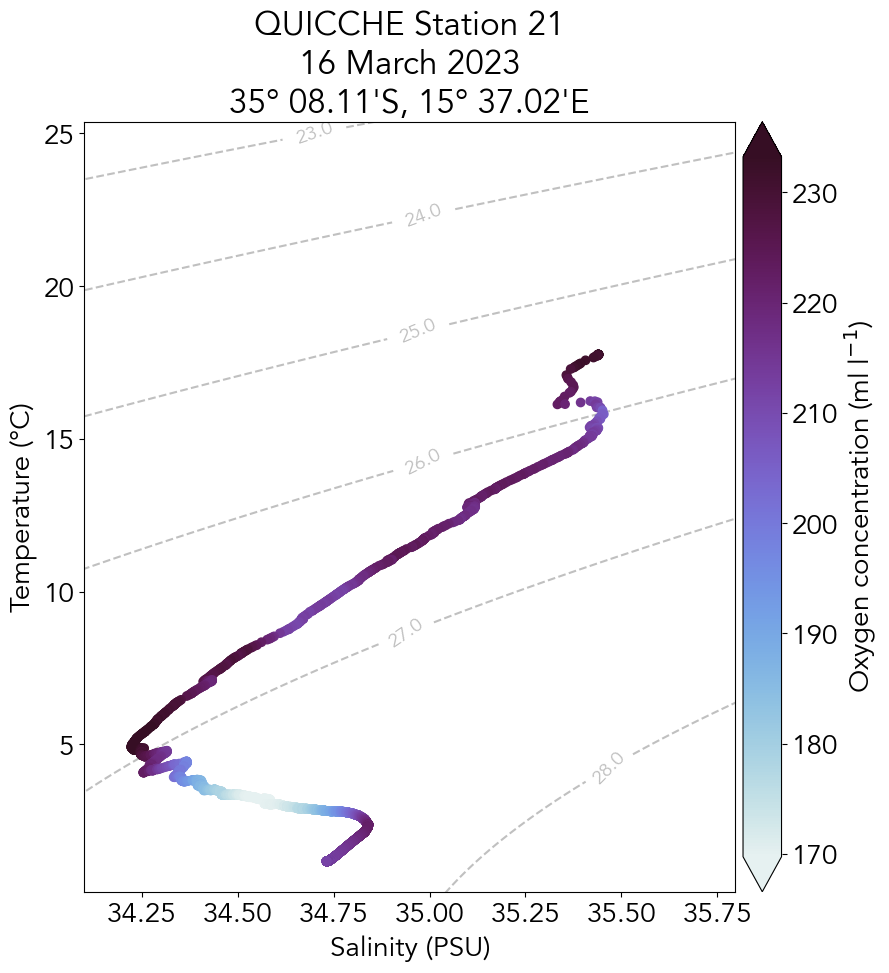

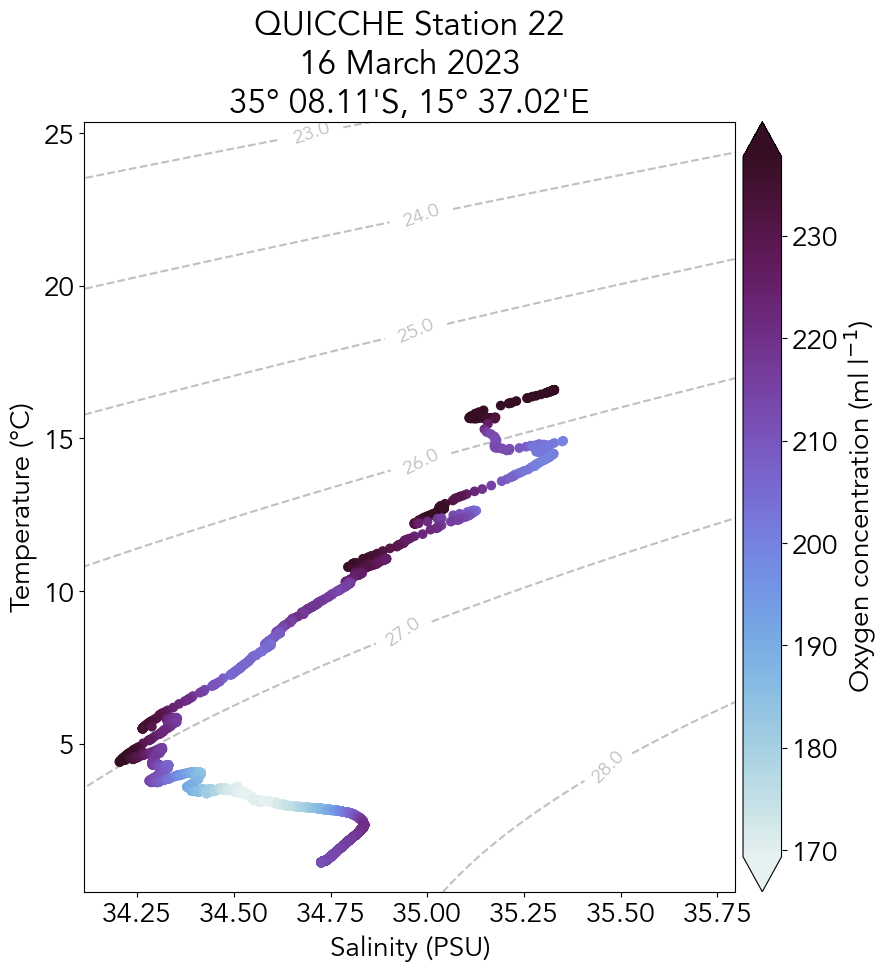

In [19]:
for i in range(22):
    st = i+1
    fig, ax = plt.subplots(figsize=(10,10))
    cs = ax.contour(Sg, Tg, sigma_theta, colors='silver',linestyles='--', zorder=1)
    cl = ax.clabel(cs,fontsize=14,inline=1,fmt='%.1f',zorder=1,inline_spacing=1e-9,manual=[[34.7,25],[35,22],[35,18],[35,14],[35,8],[35.5,4]],use_clabeltext=True)
    ds.sel(station=st).plot.scatter(x='salinity1',y='temperature1',ax=ax,hue='oxygen_concentration',cmap='cmo.dense',cbar_kwargs={'label':'Oxygen concentration (ml l$^{-1}$)','pad':0.01},robust=True)
    ax.set(xlim=[np.nanpercentile(ds.sel(station=st)['salinity1'],5)-0.2,np.nanpercentile(ds.sel(station=9)['salinity1'],99)+.2],
            ylim=[np.nanpercentile(ds.sel(station=st)['temperature1'],5)-1,np.nanpercentile(ds.sel(station=9)['temperature1'],99)+5])

    ax.set_title(f"QUICCHE Station {st}\n16 March 2023\n35° 08.11'S, 15° 37.02'E")
    ax.set(ylabel='Temperature (°C)',xlabel='Salinity (PSU)')
    #ds.sel(station=9,cast='up').plot.scatter(x='salinity1',y='temperature1')
    #plt.axis('off')

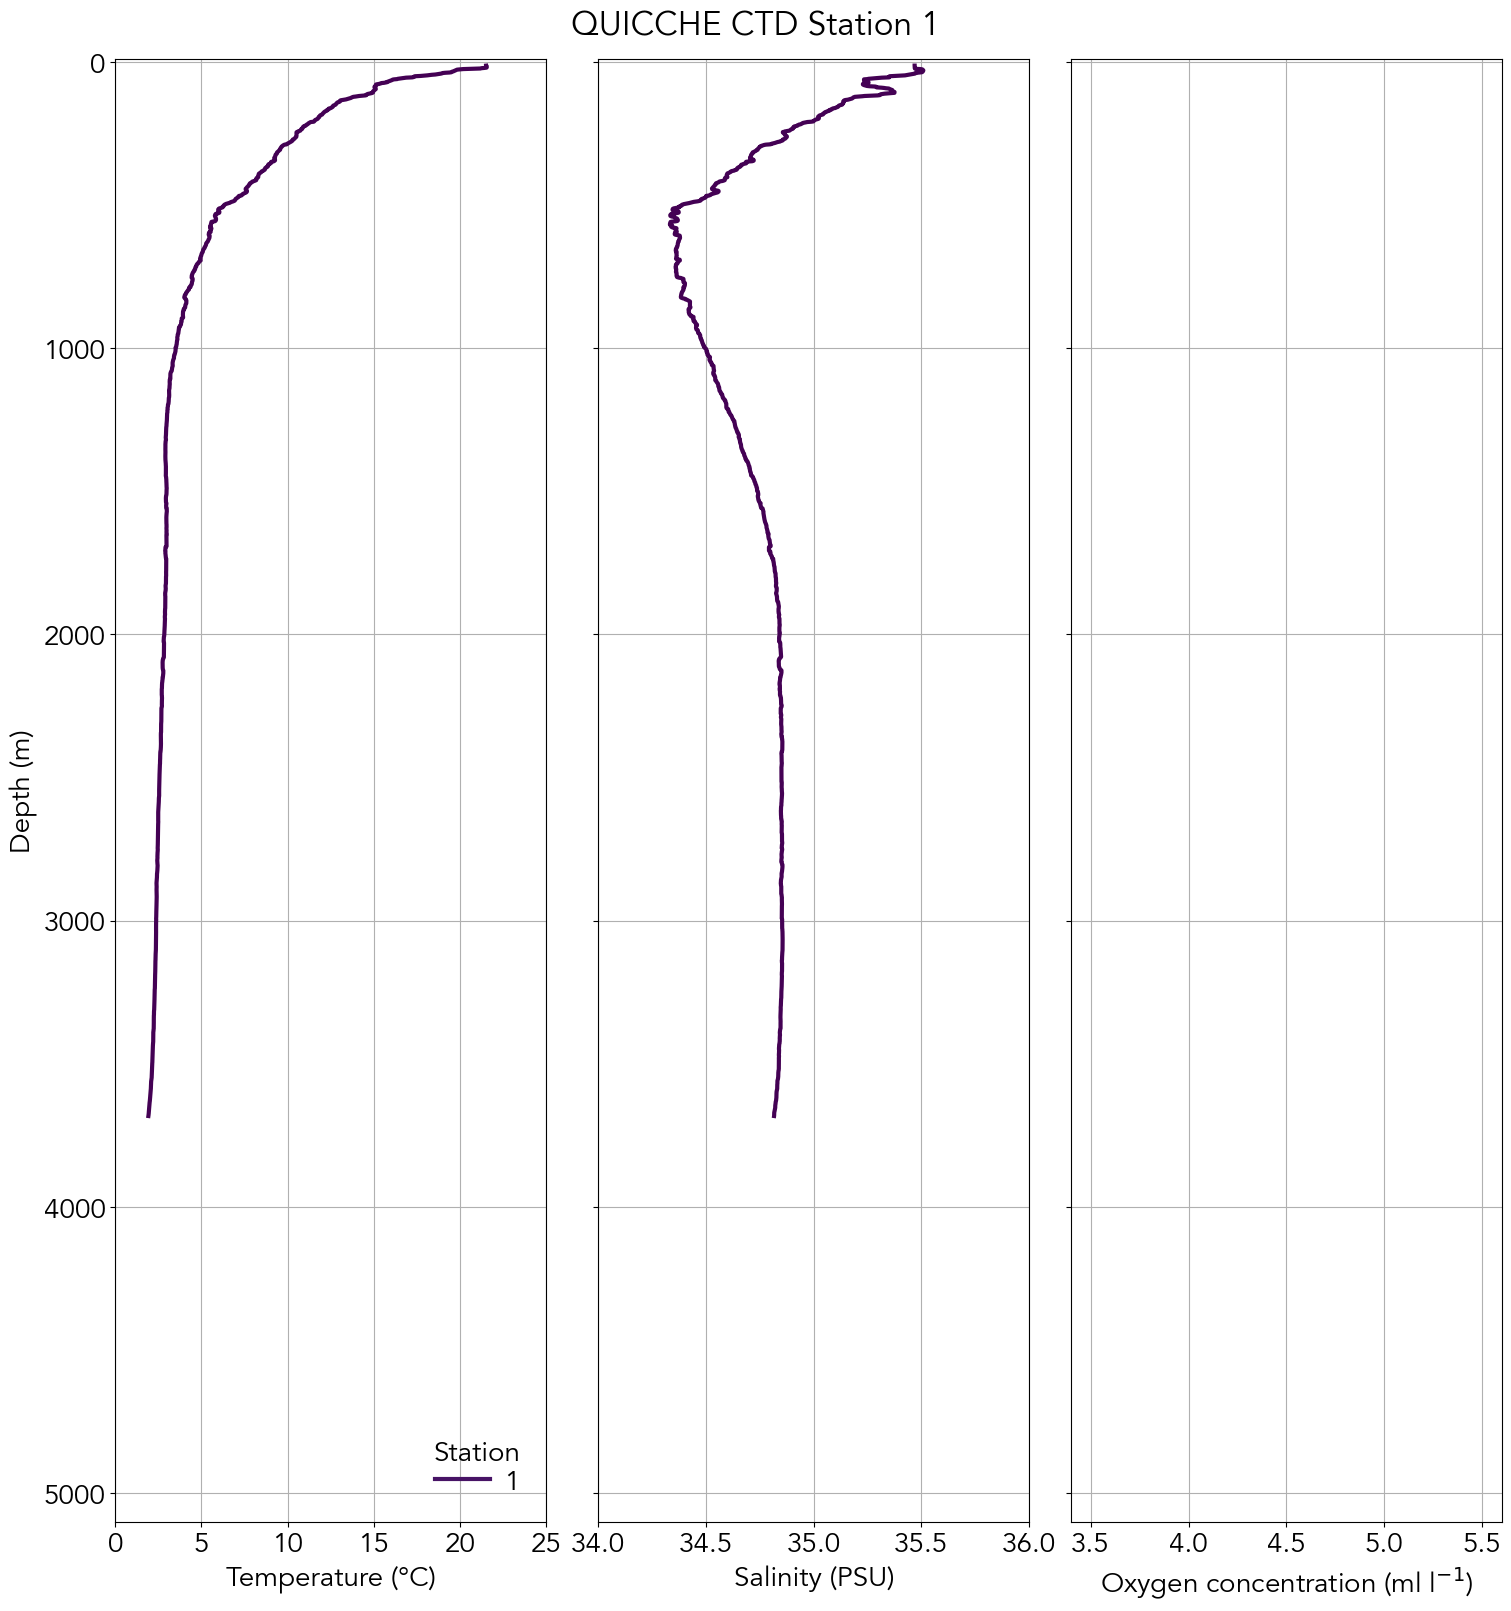

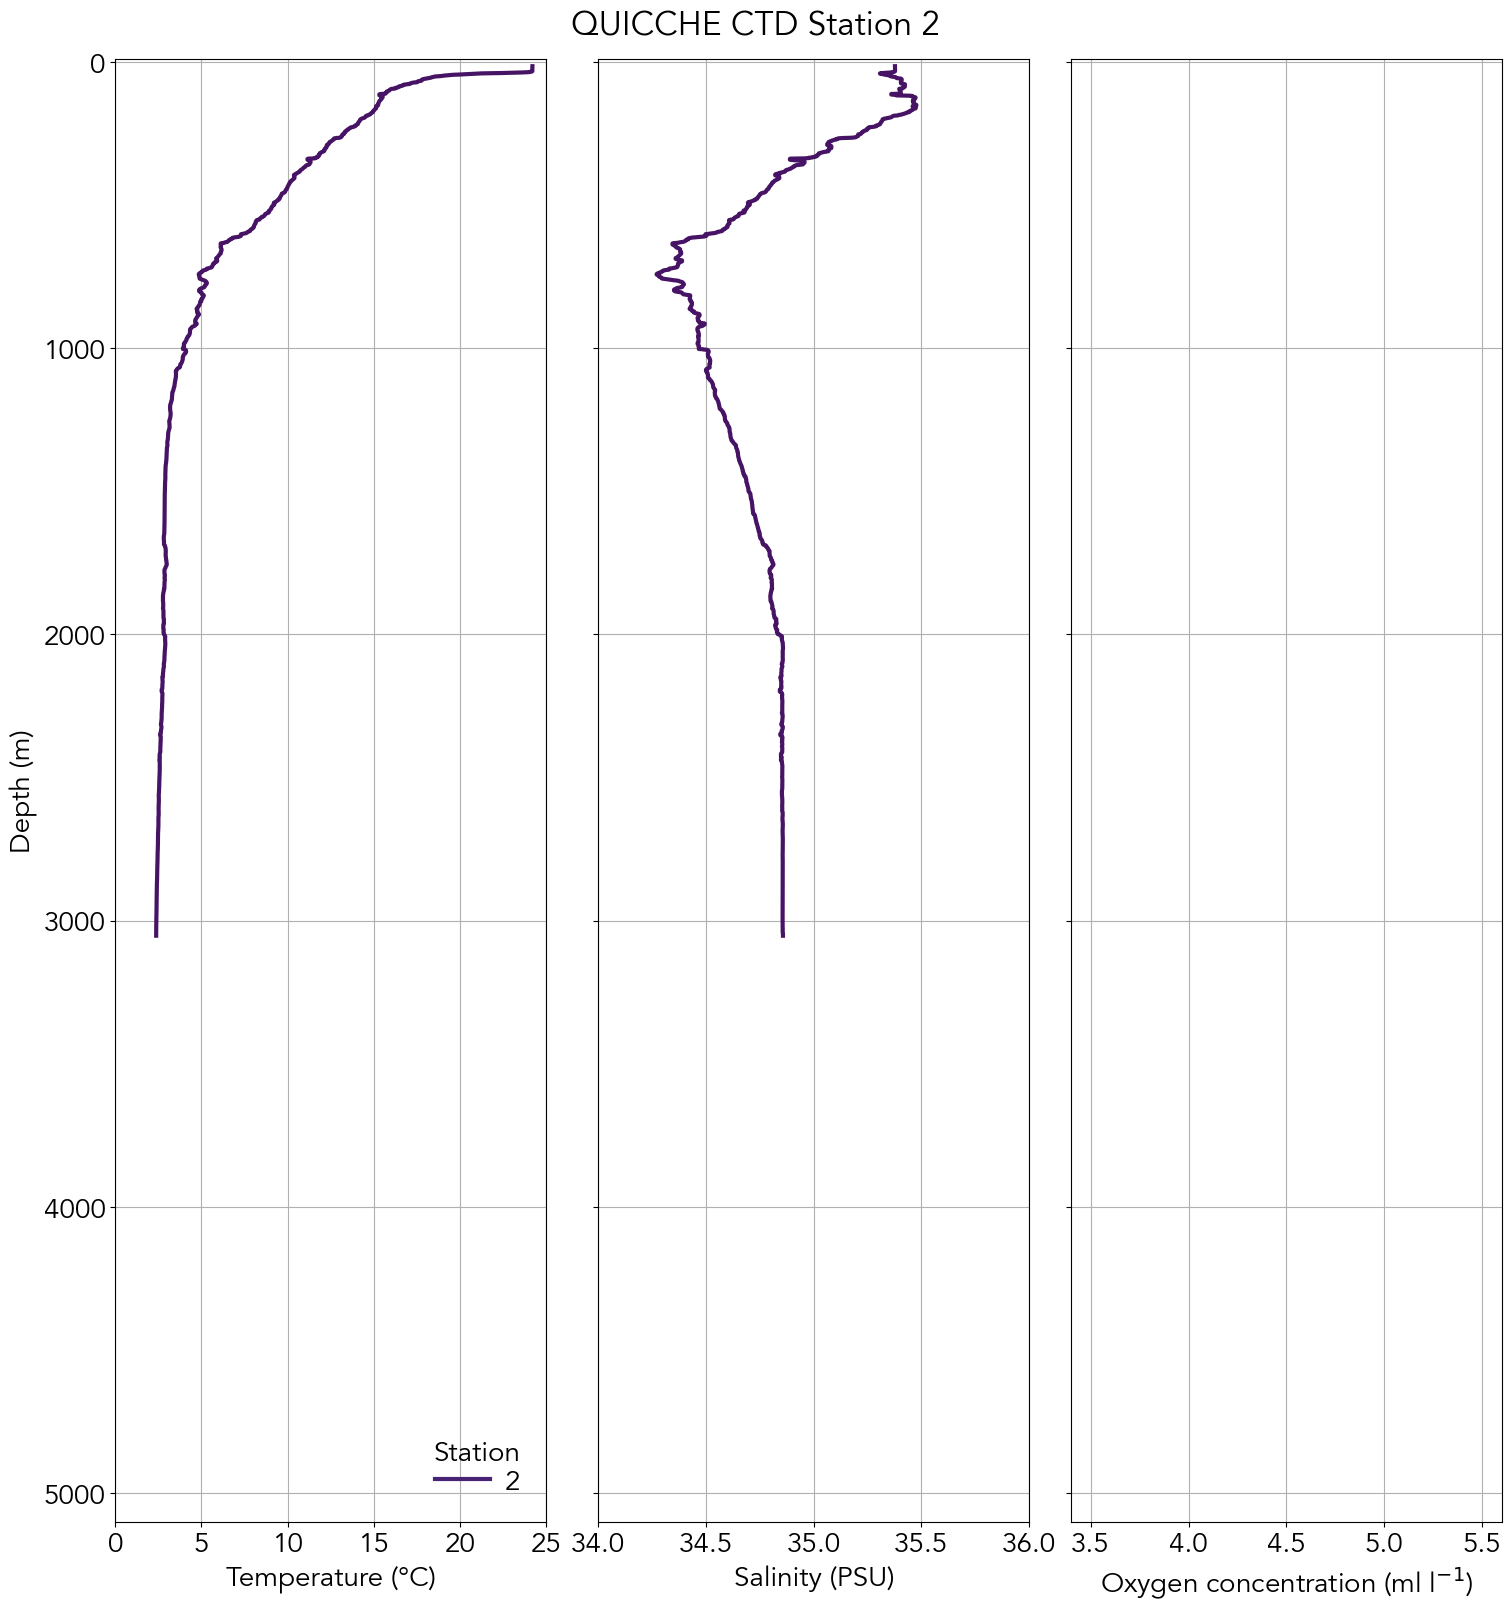

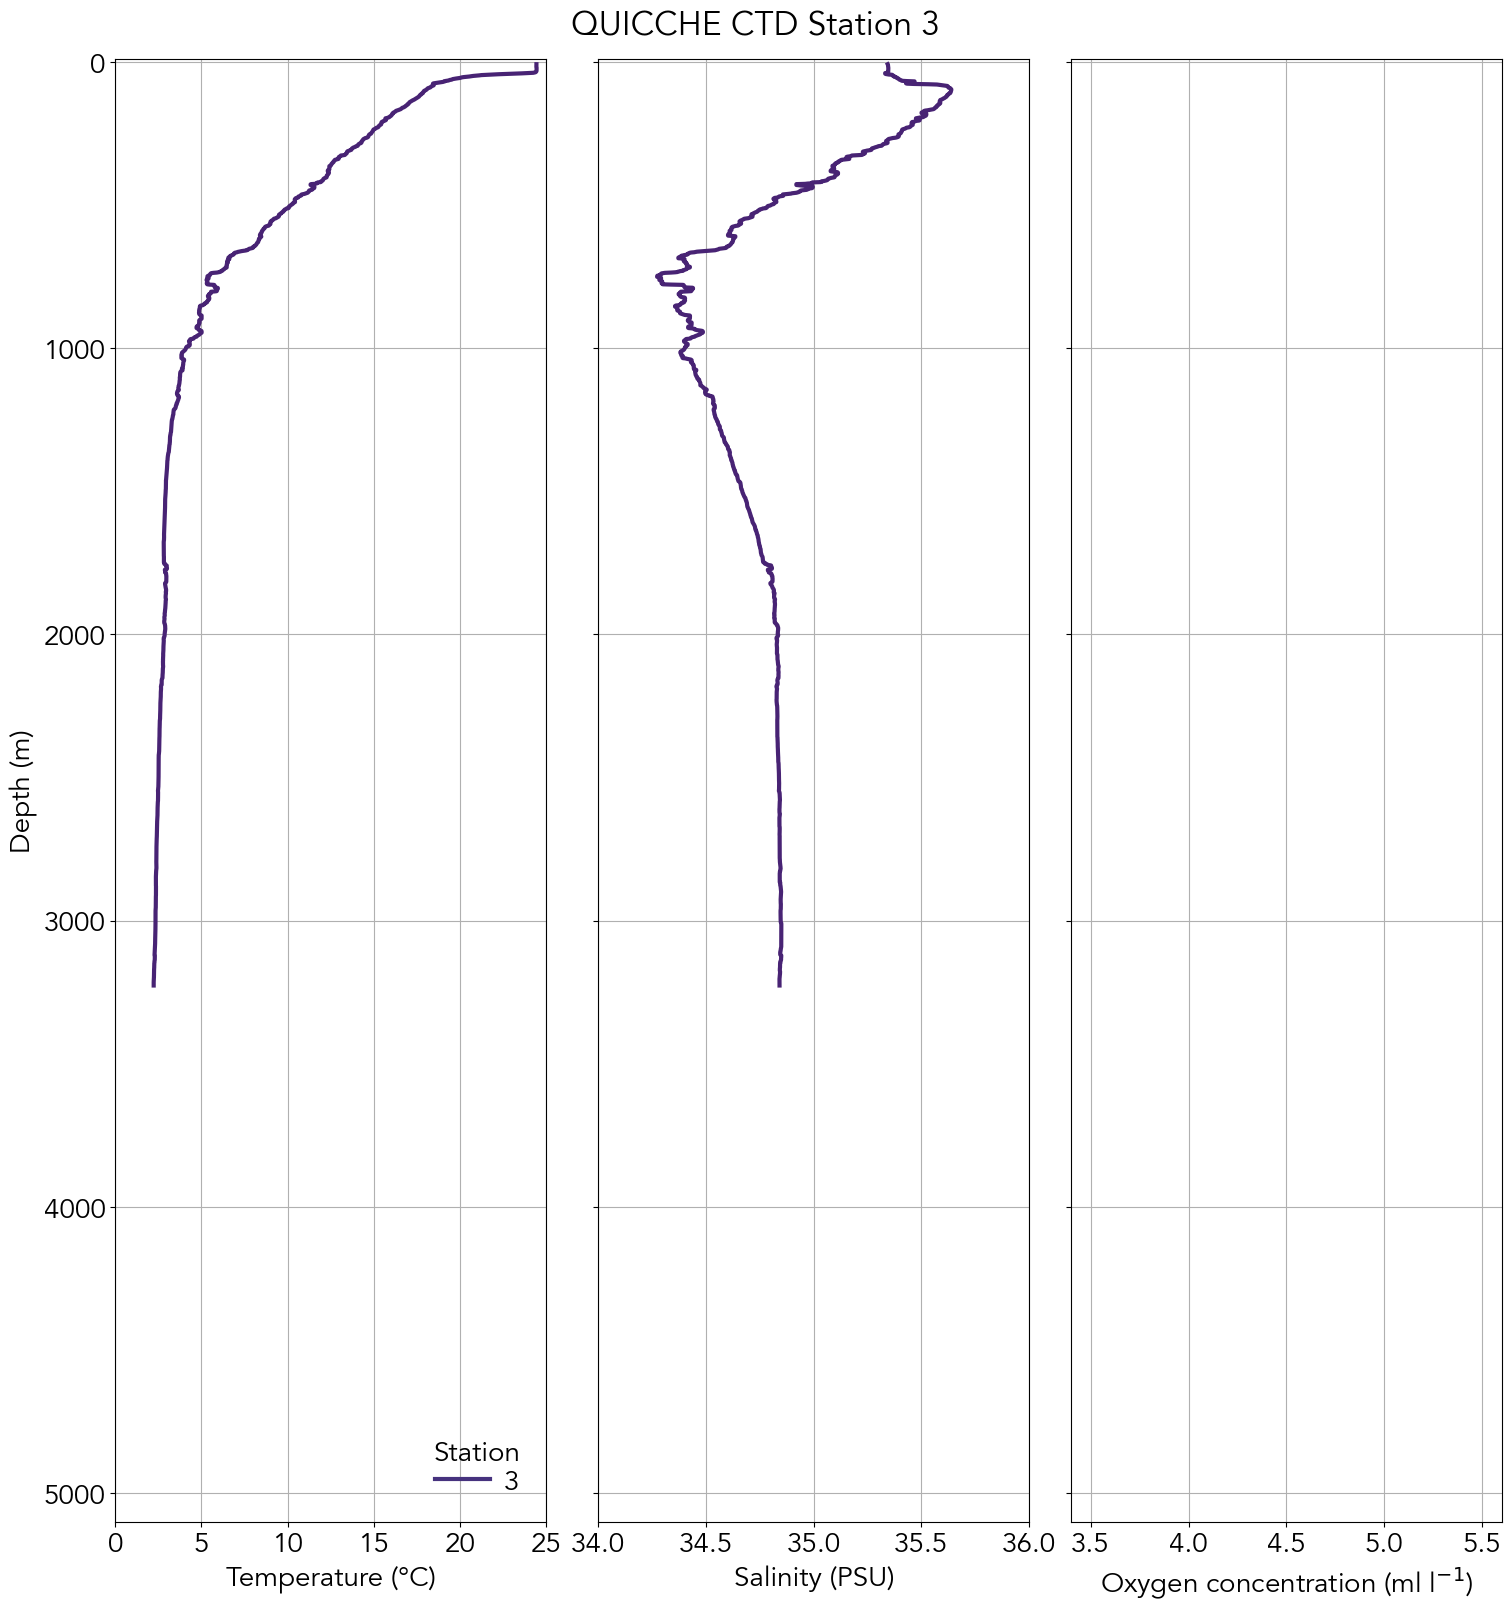

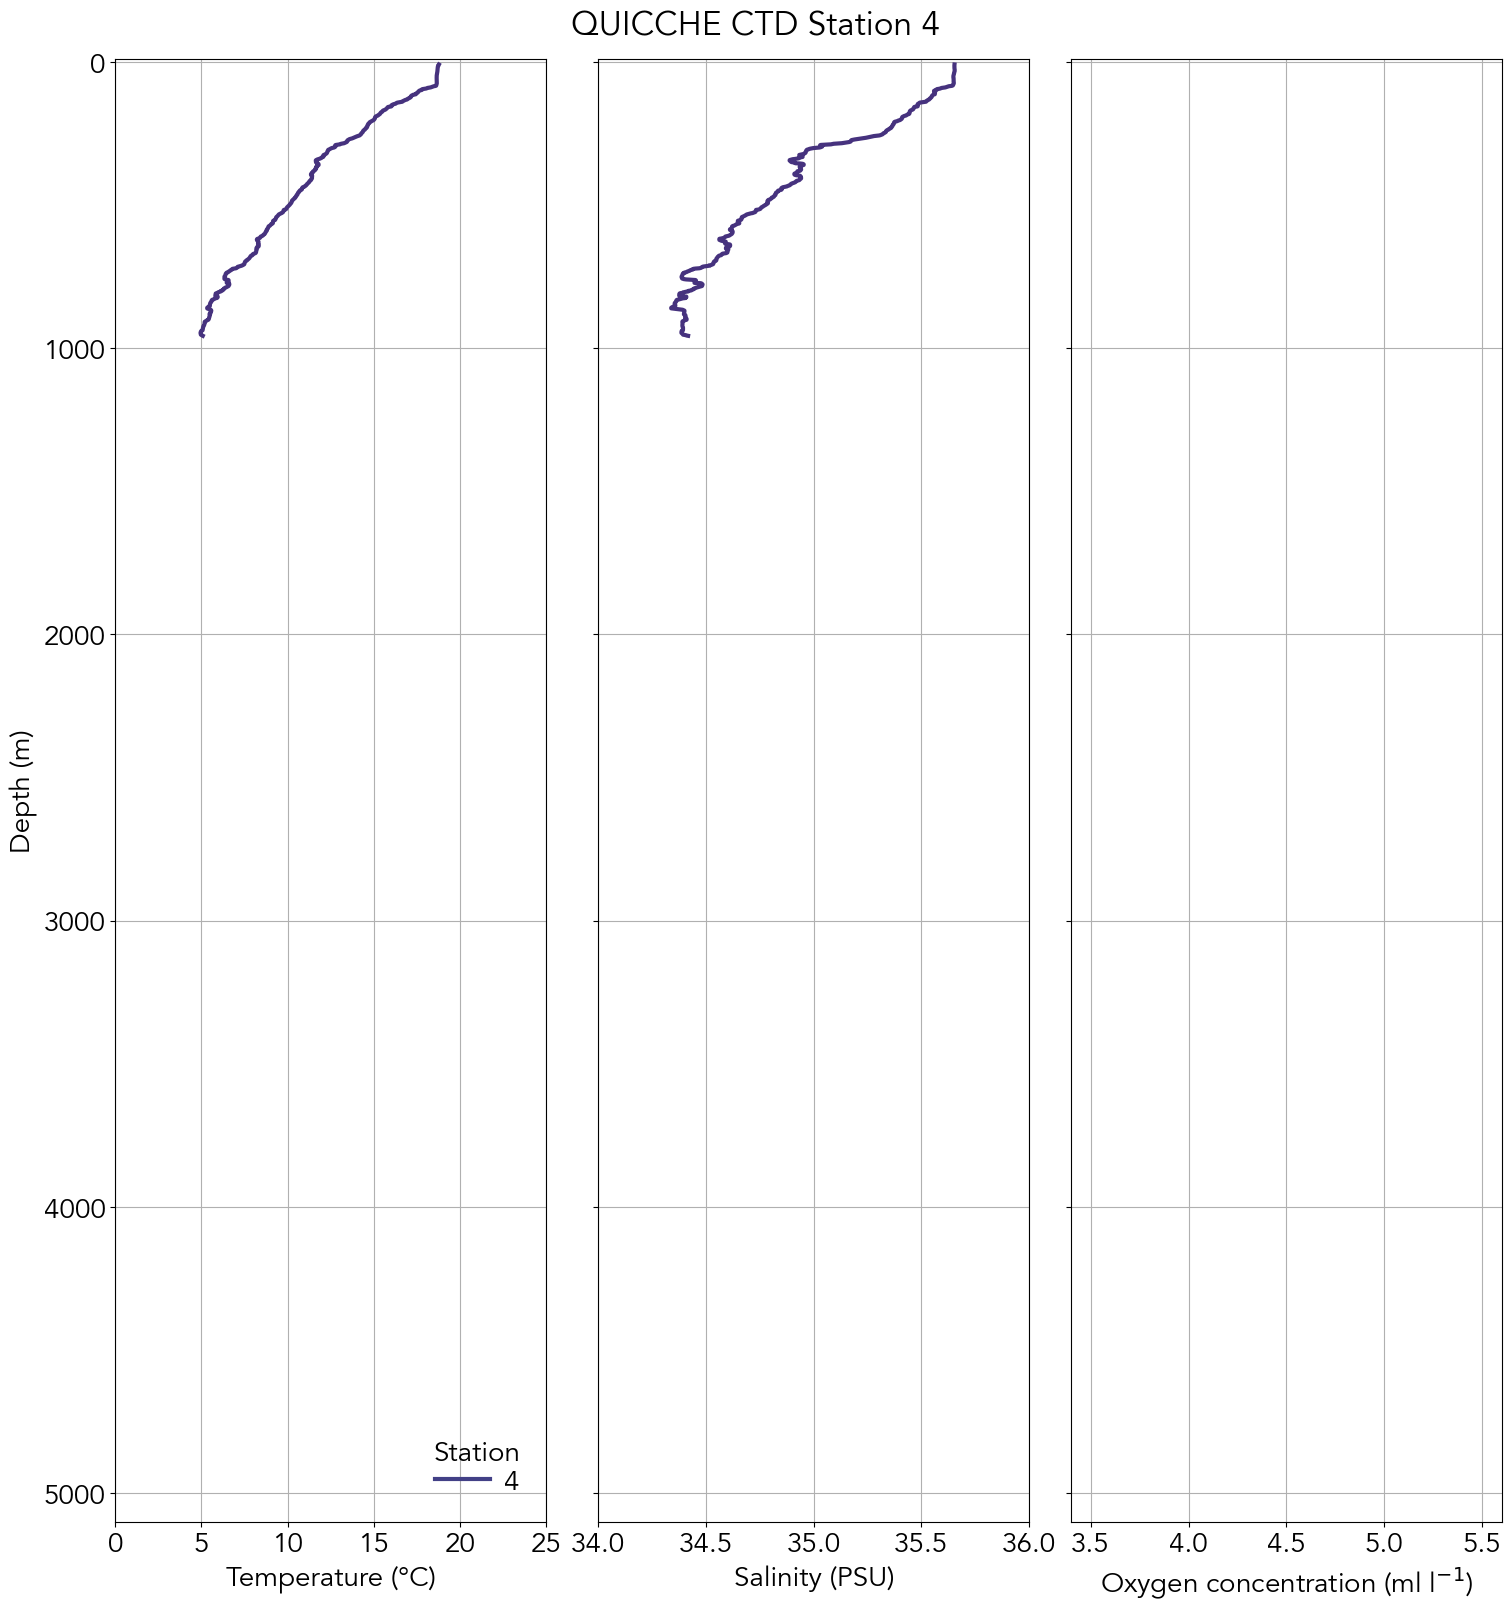

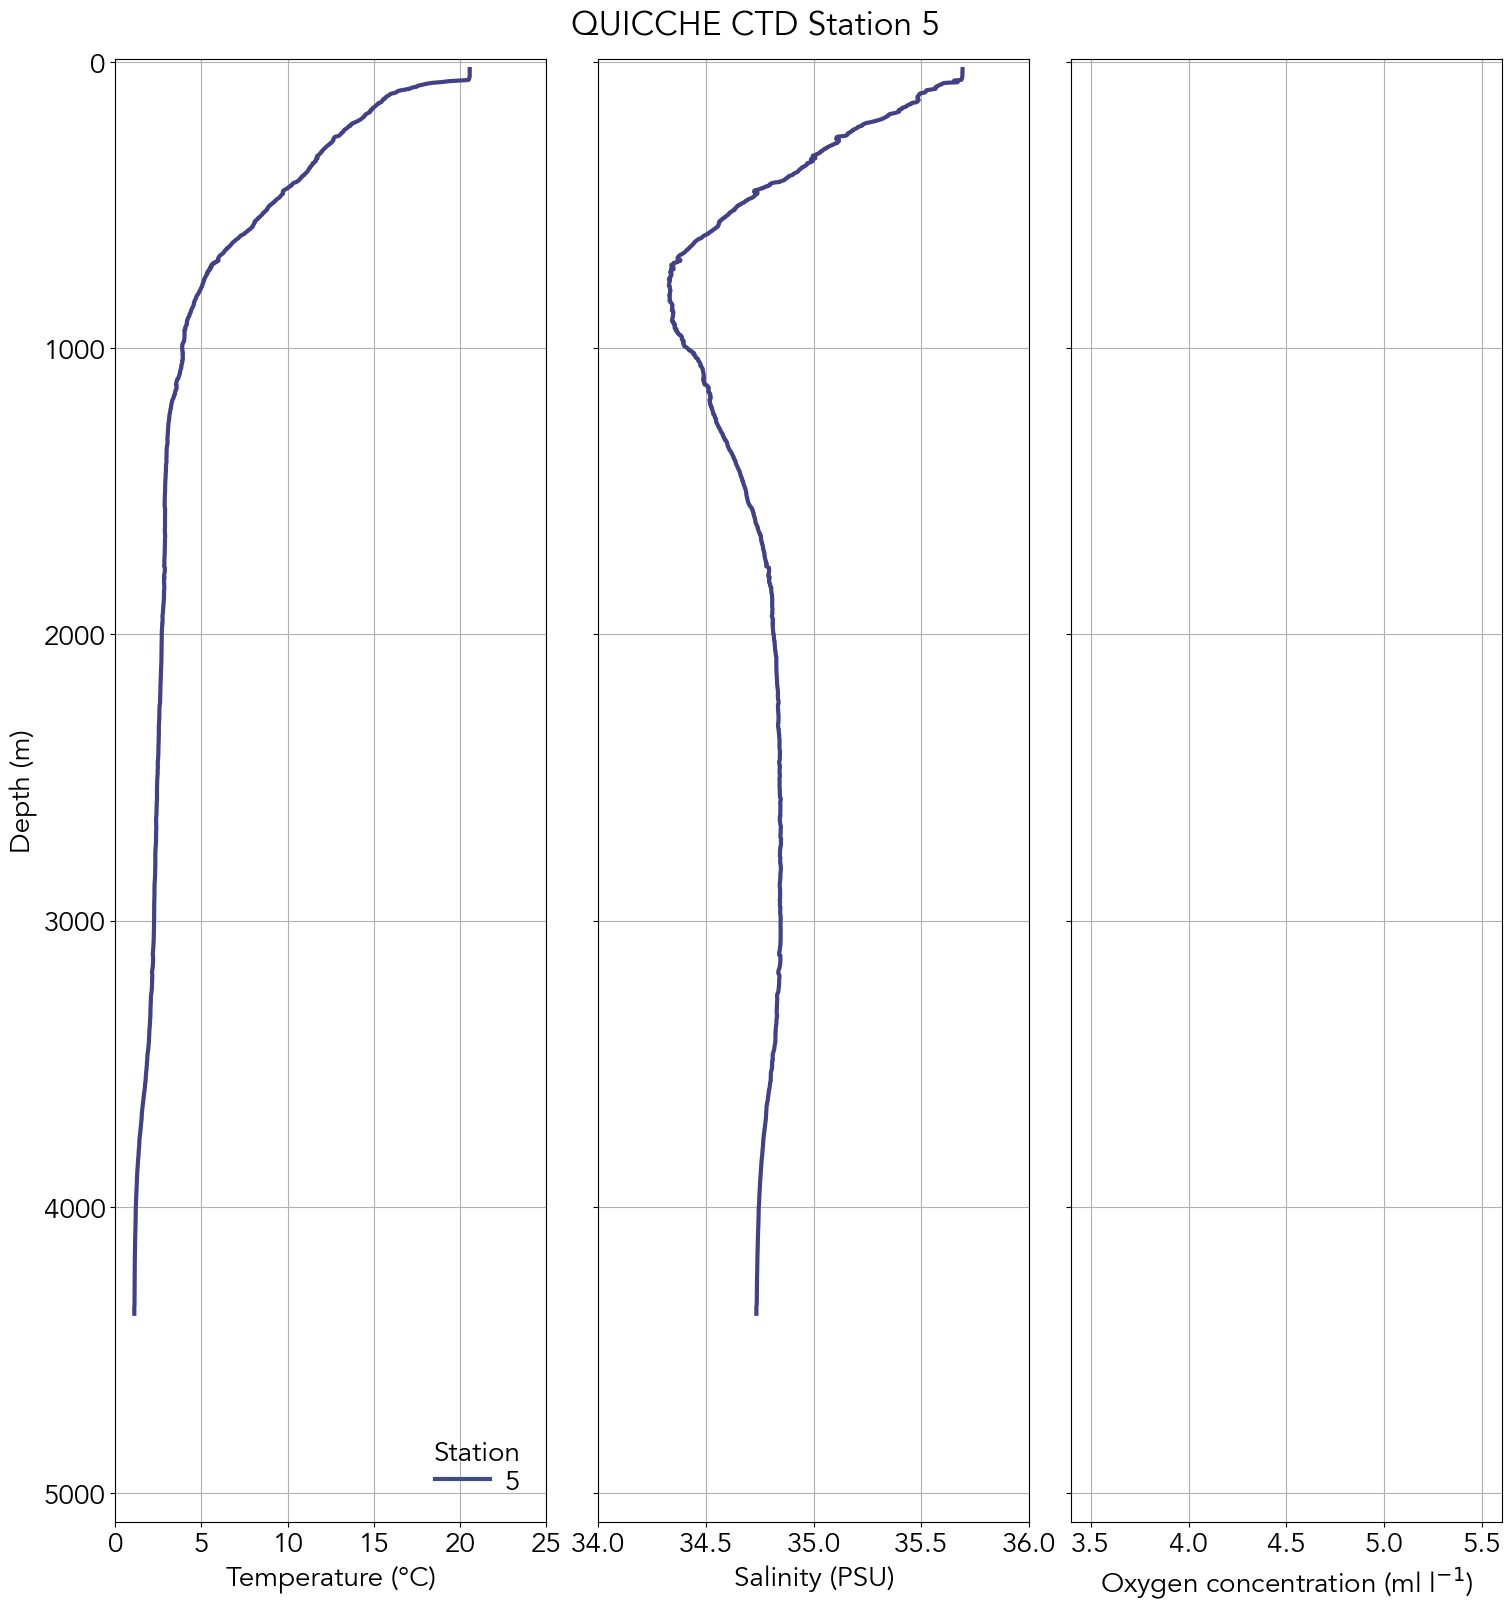

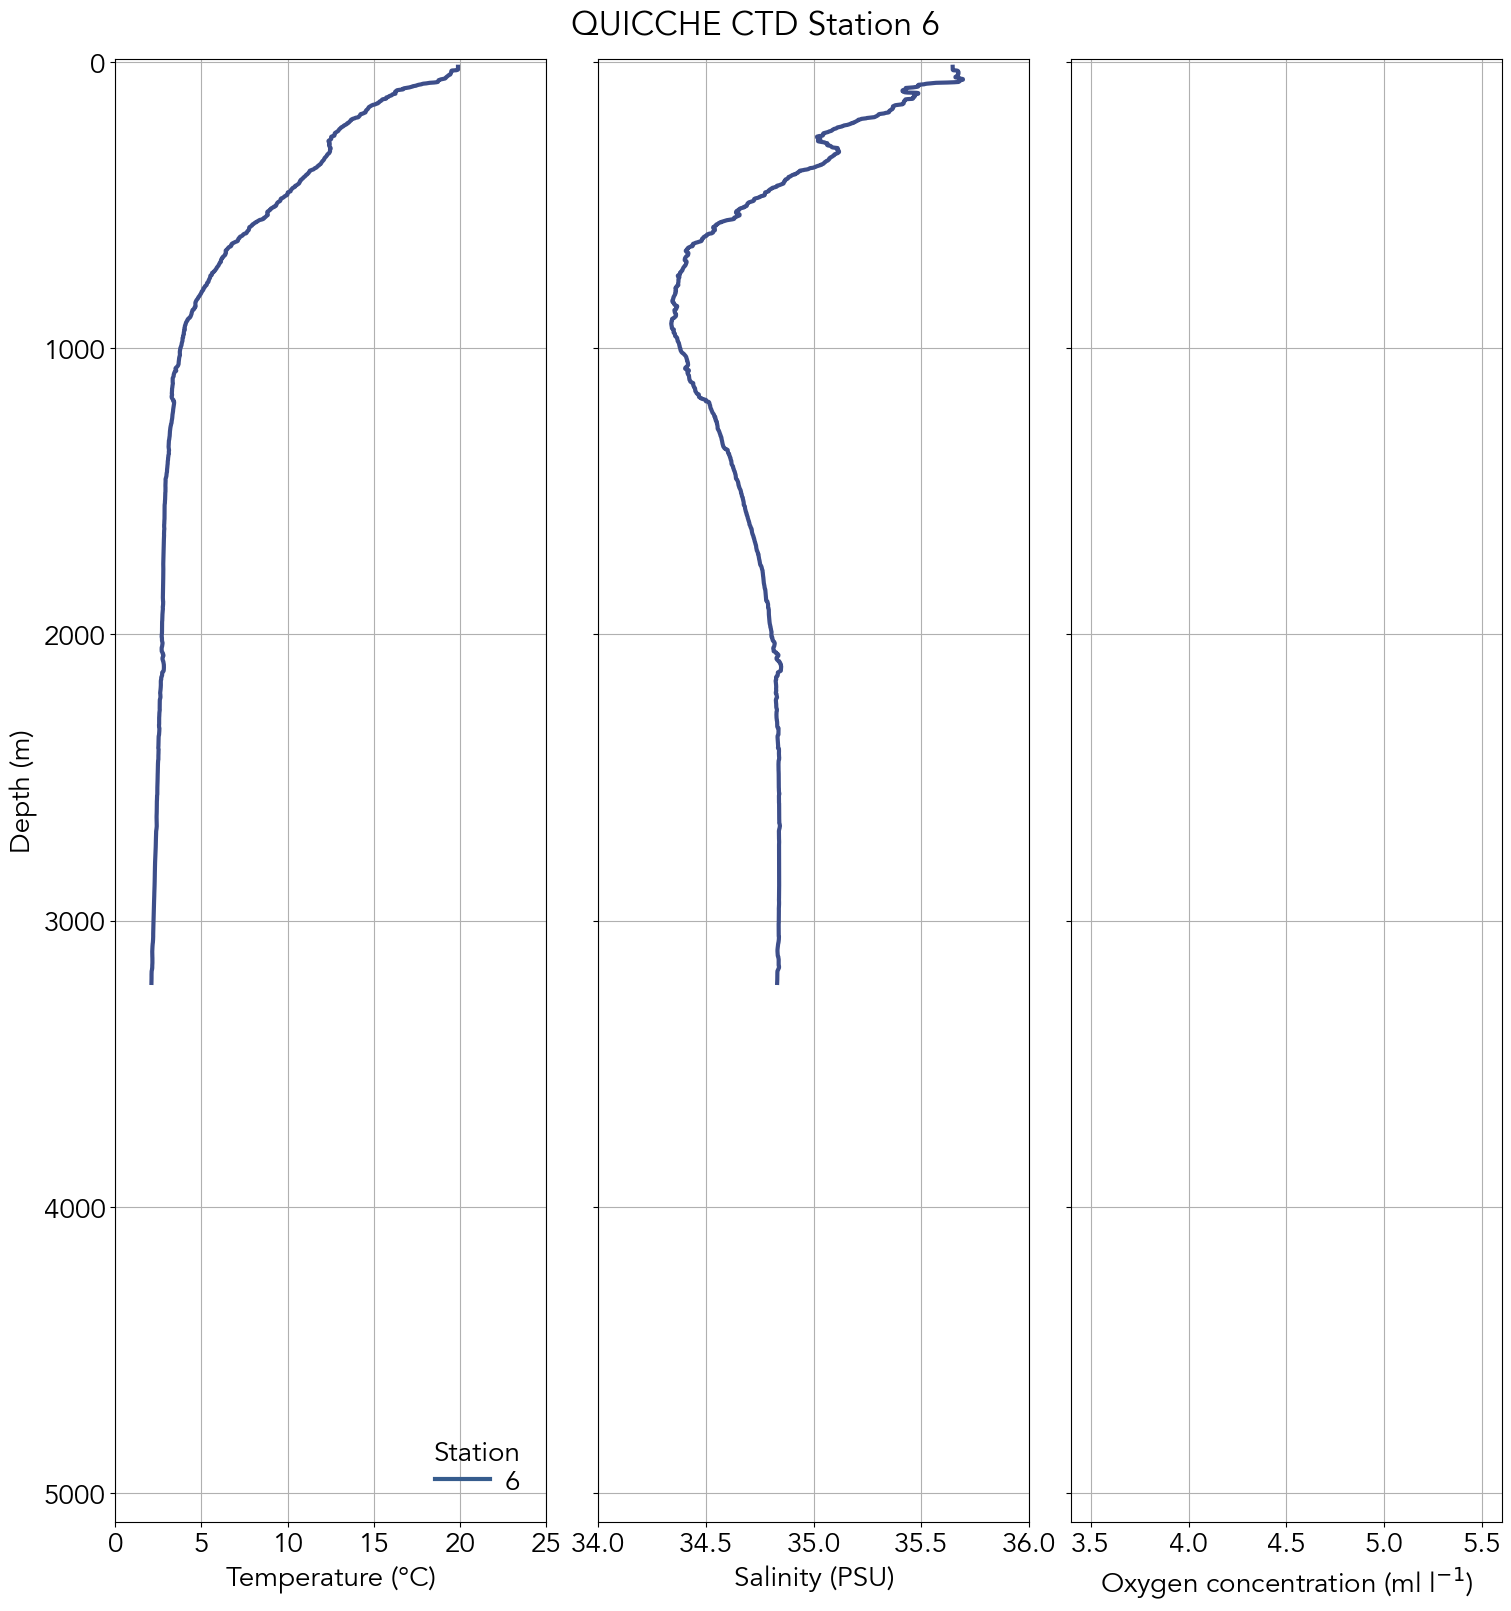

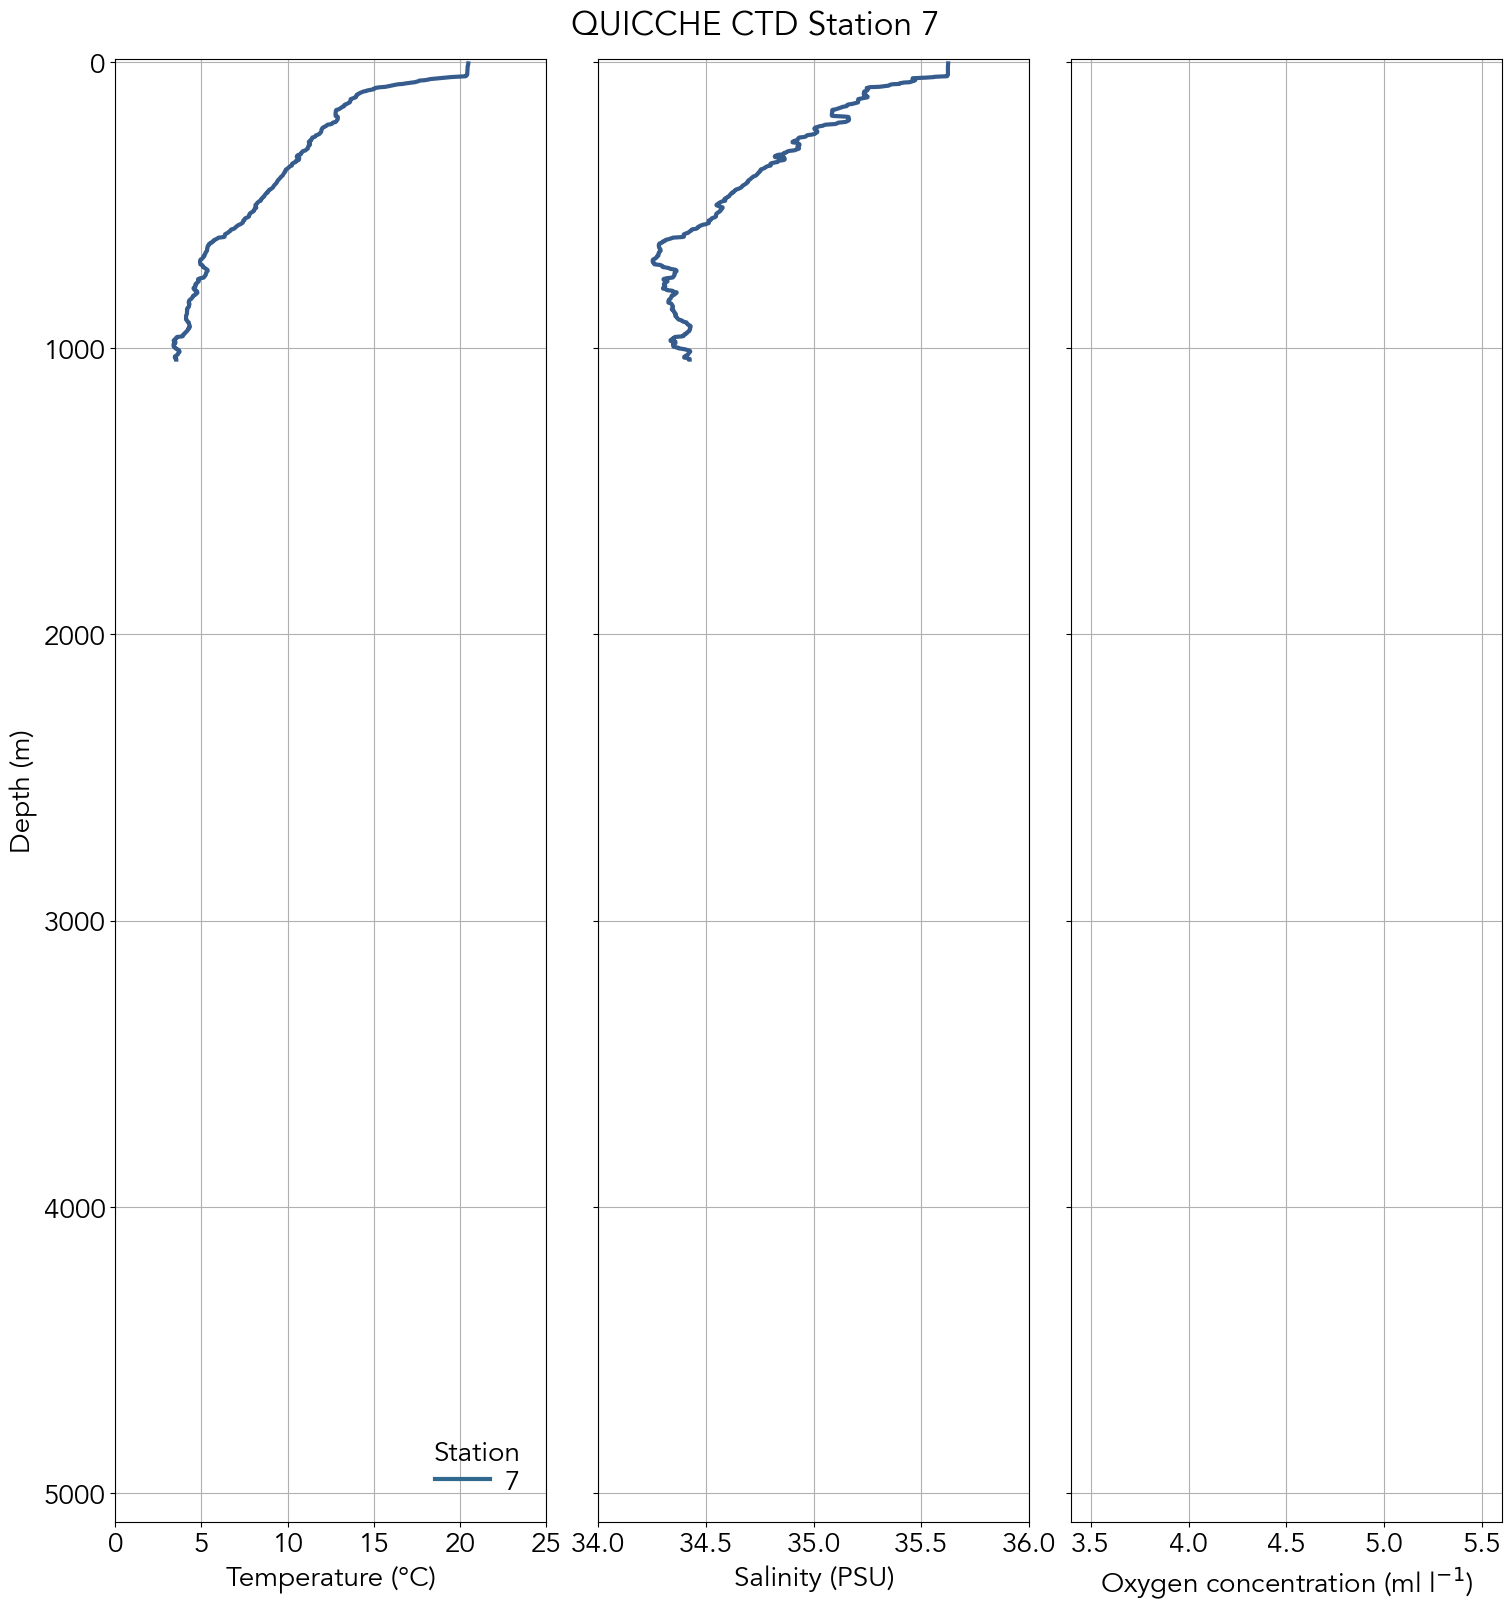

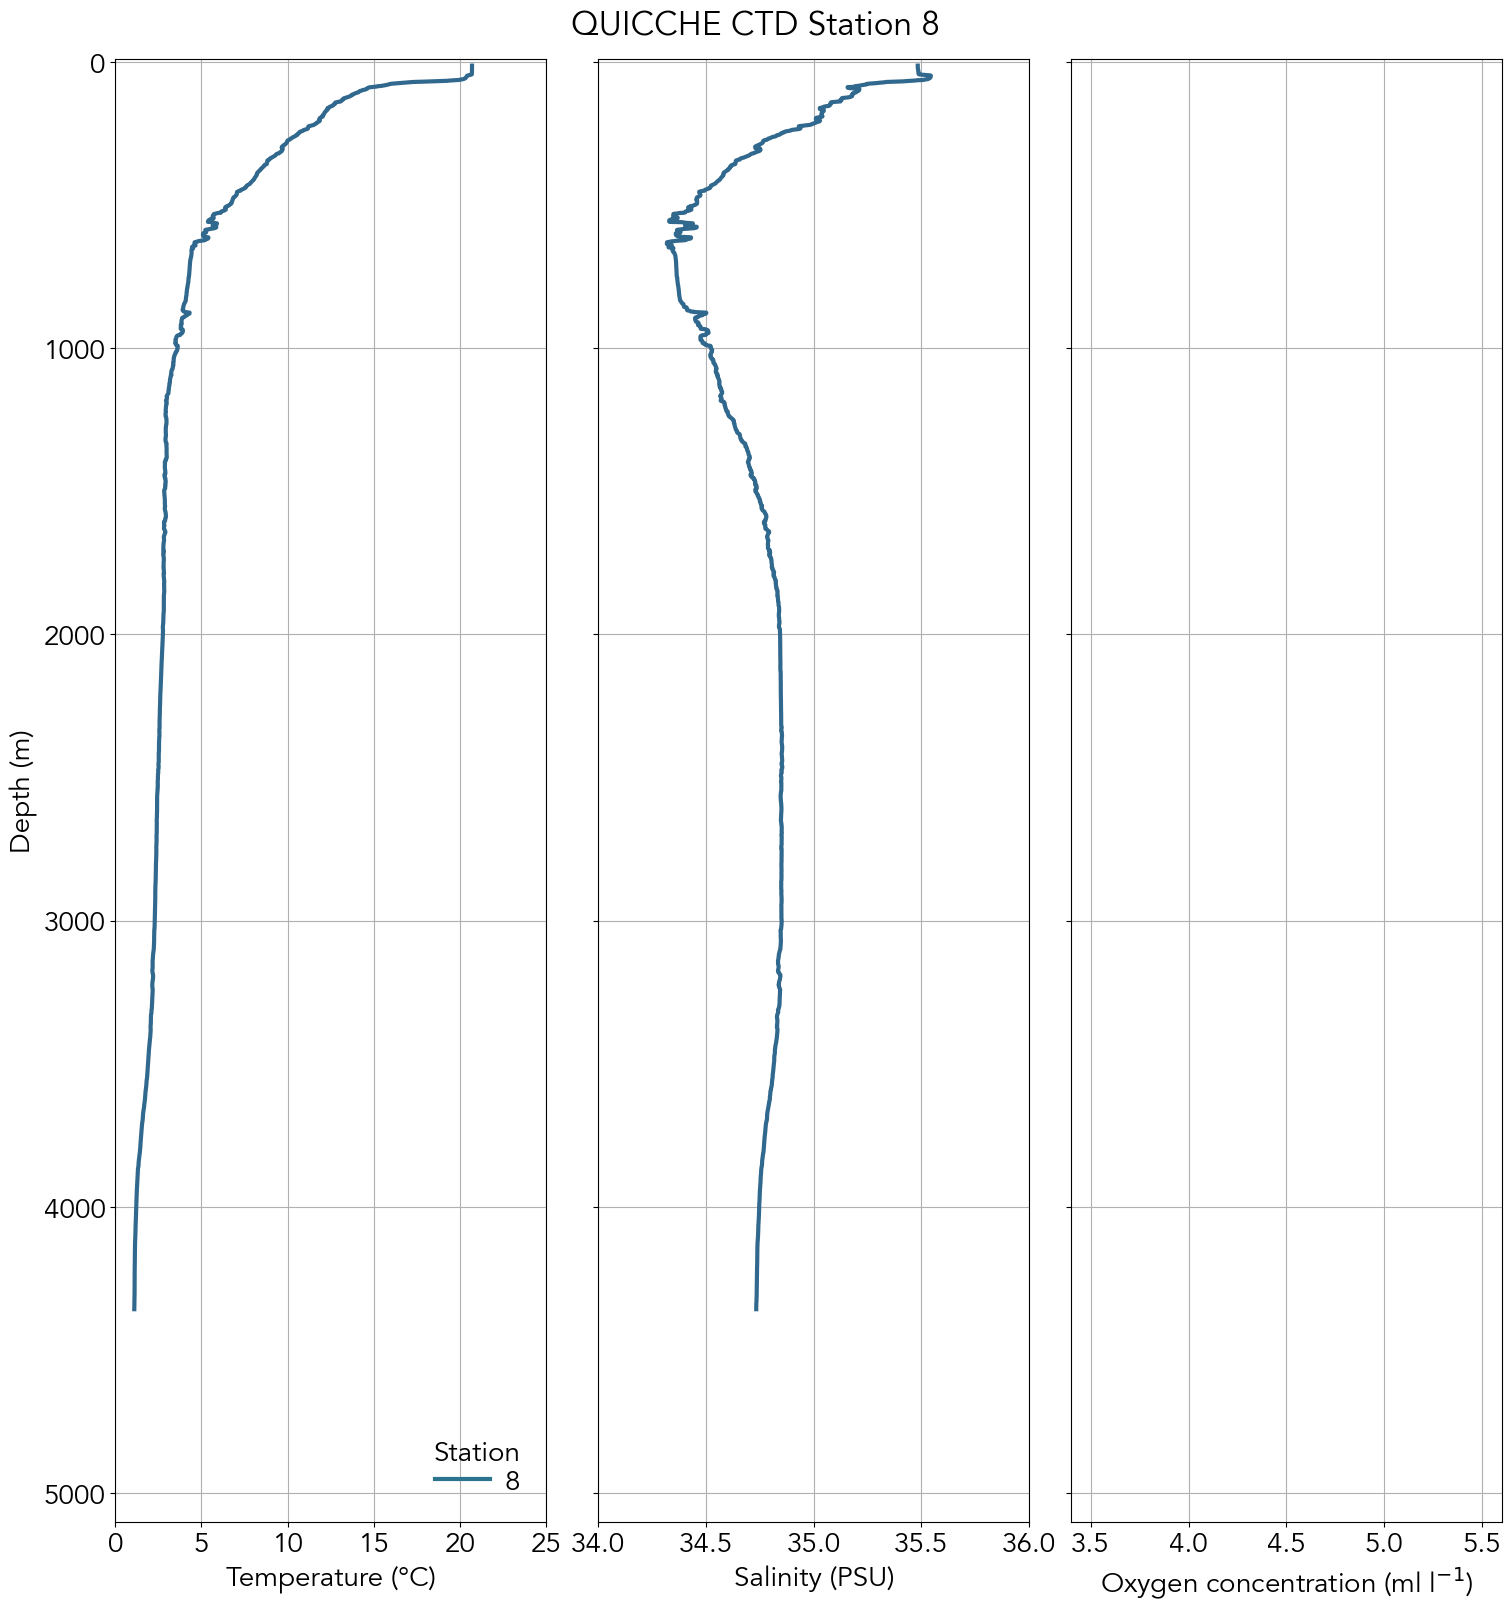

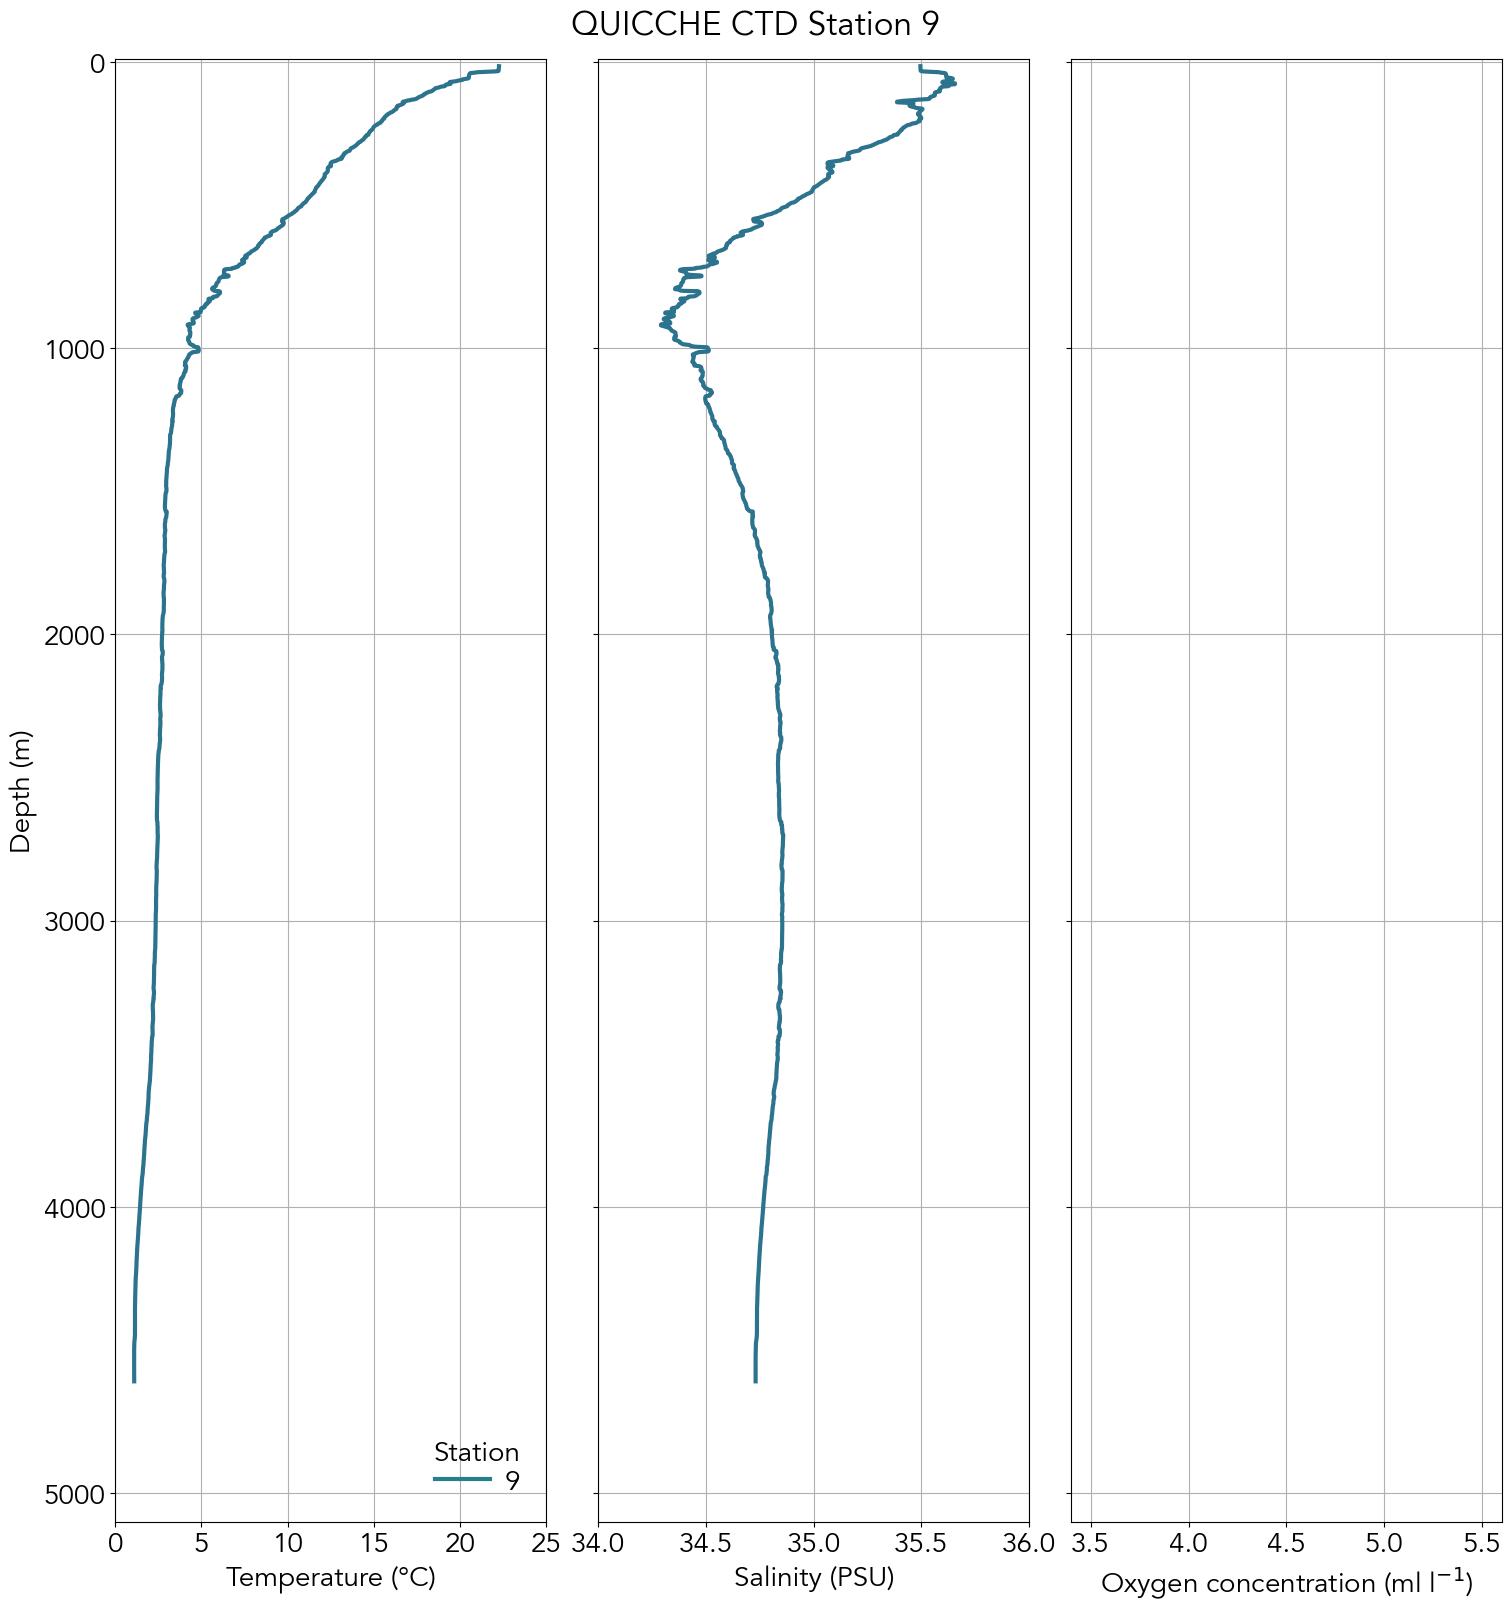

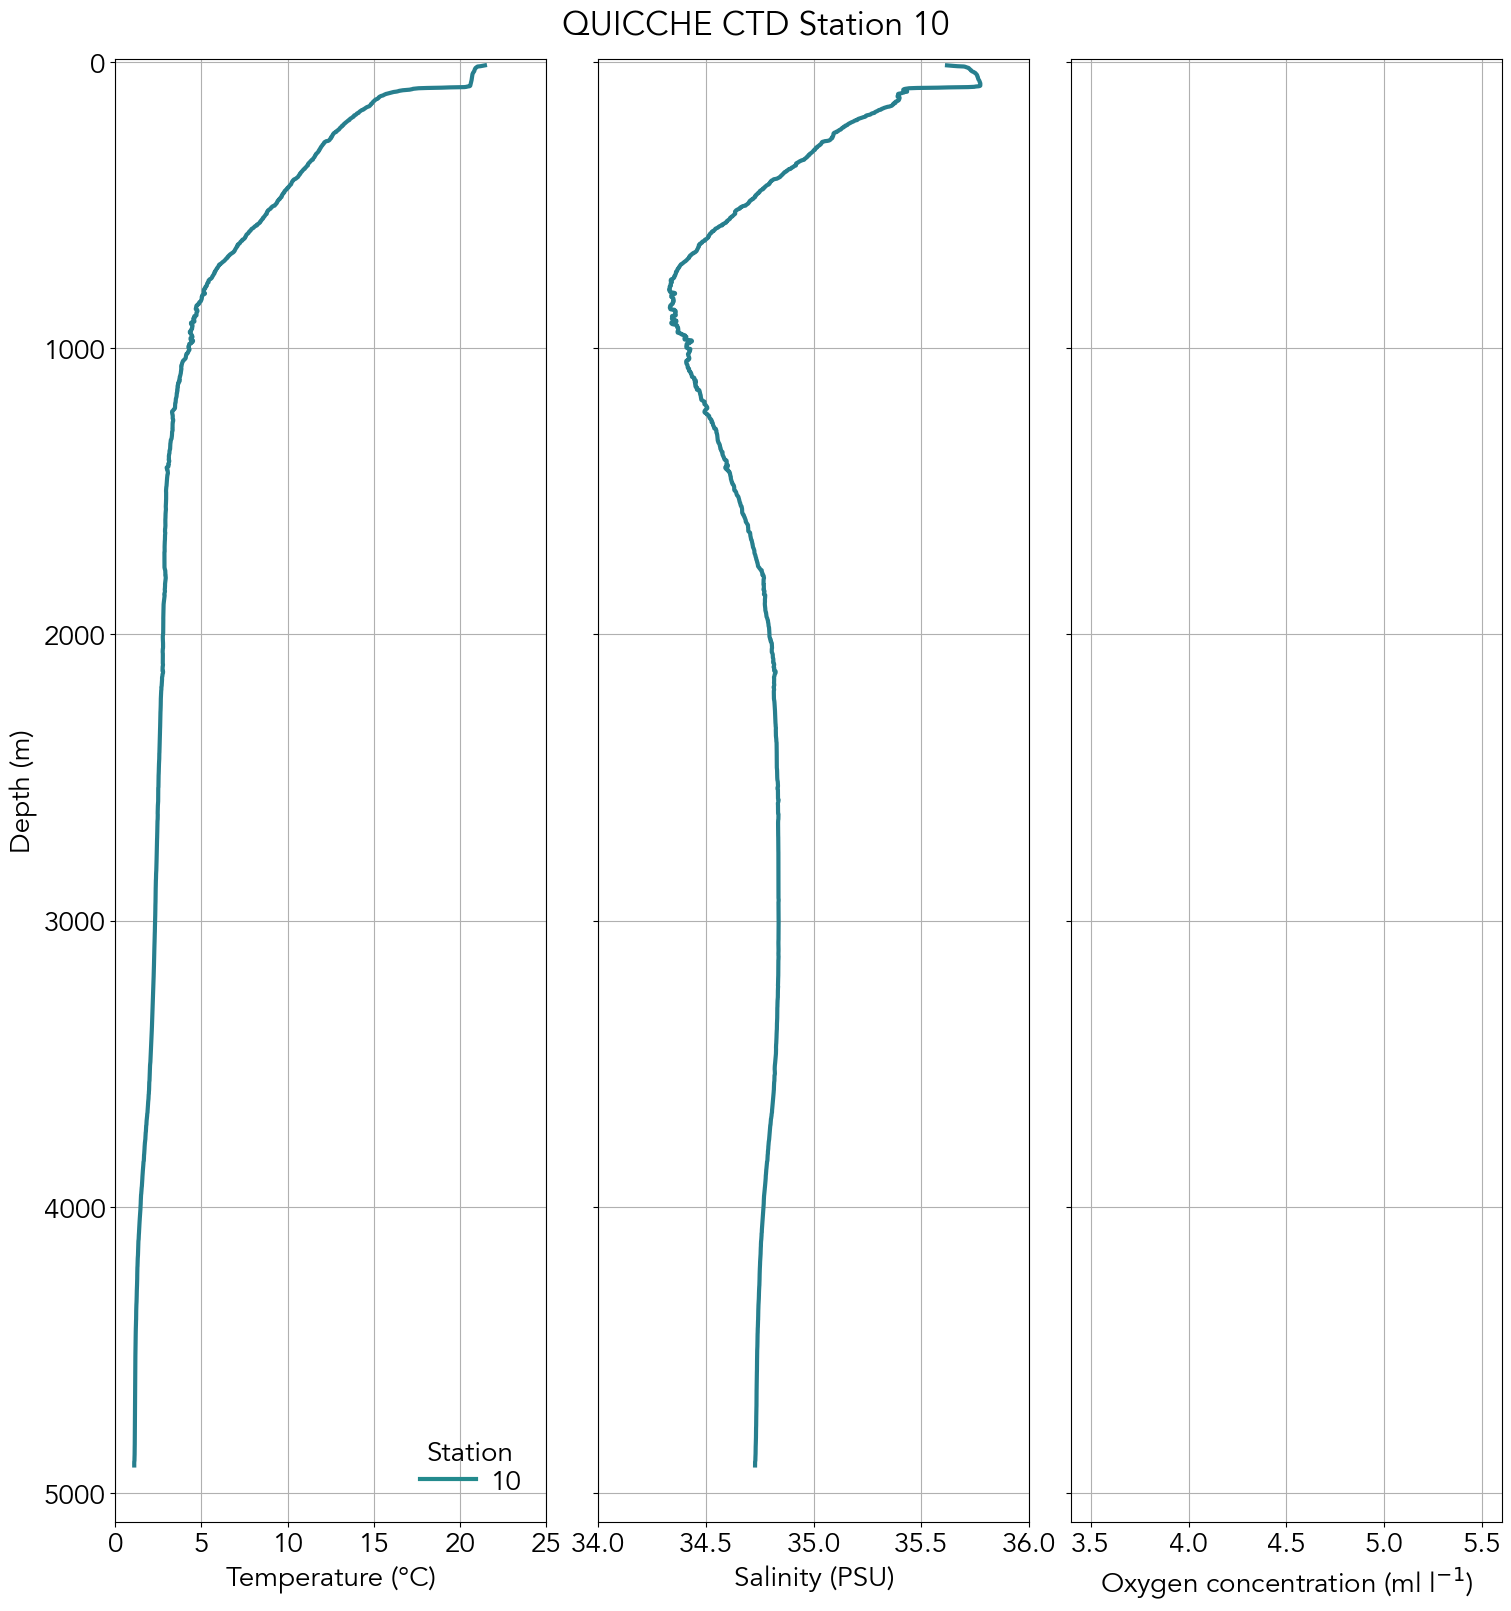

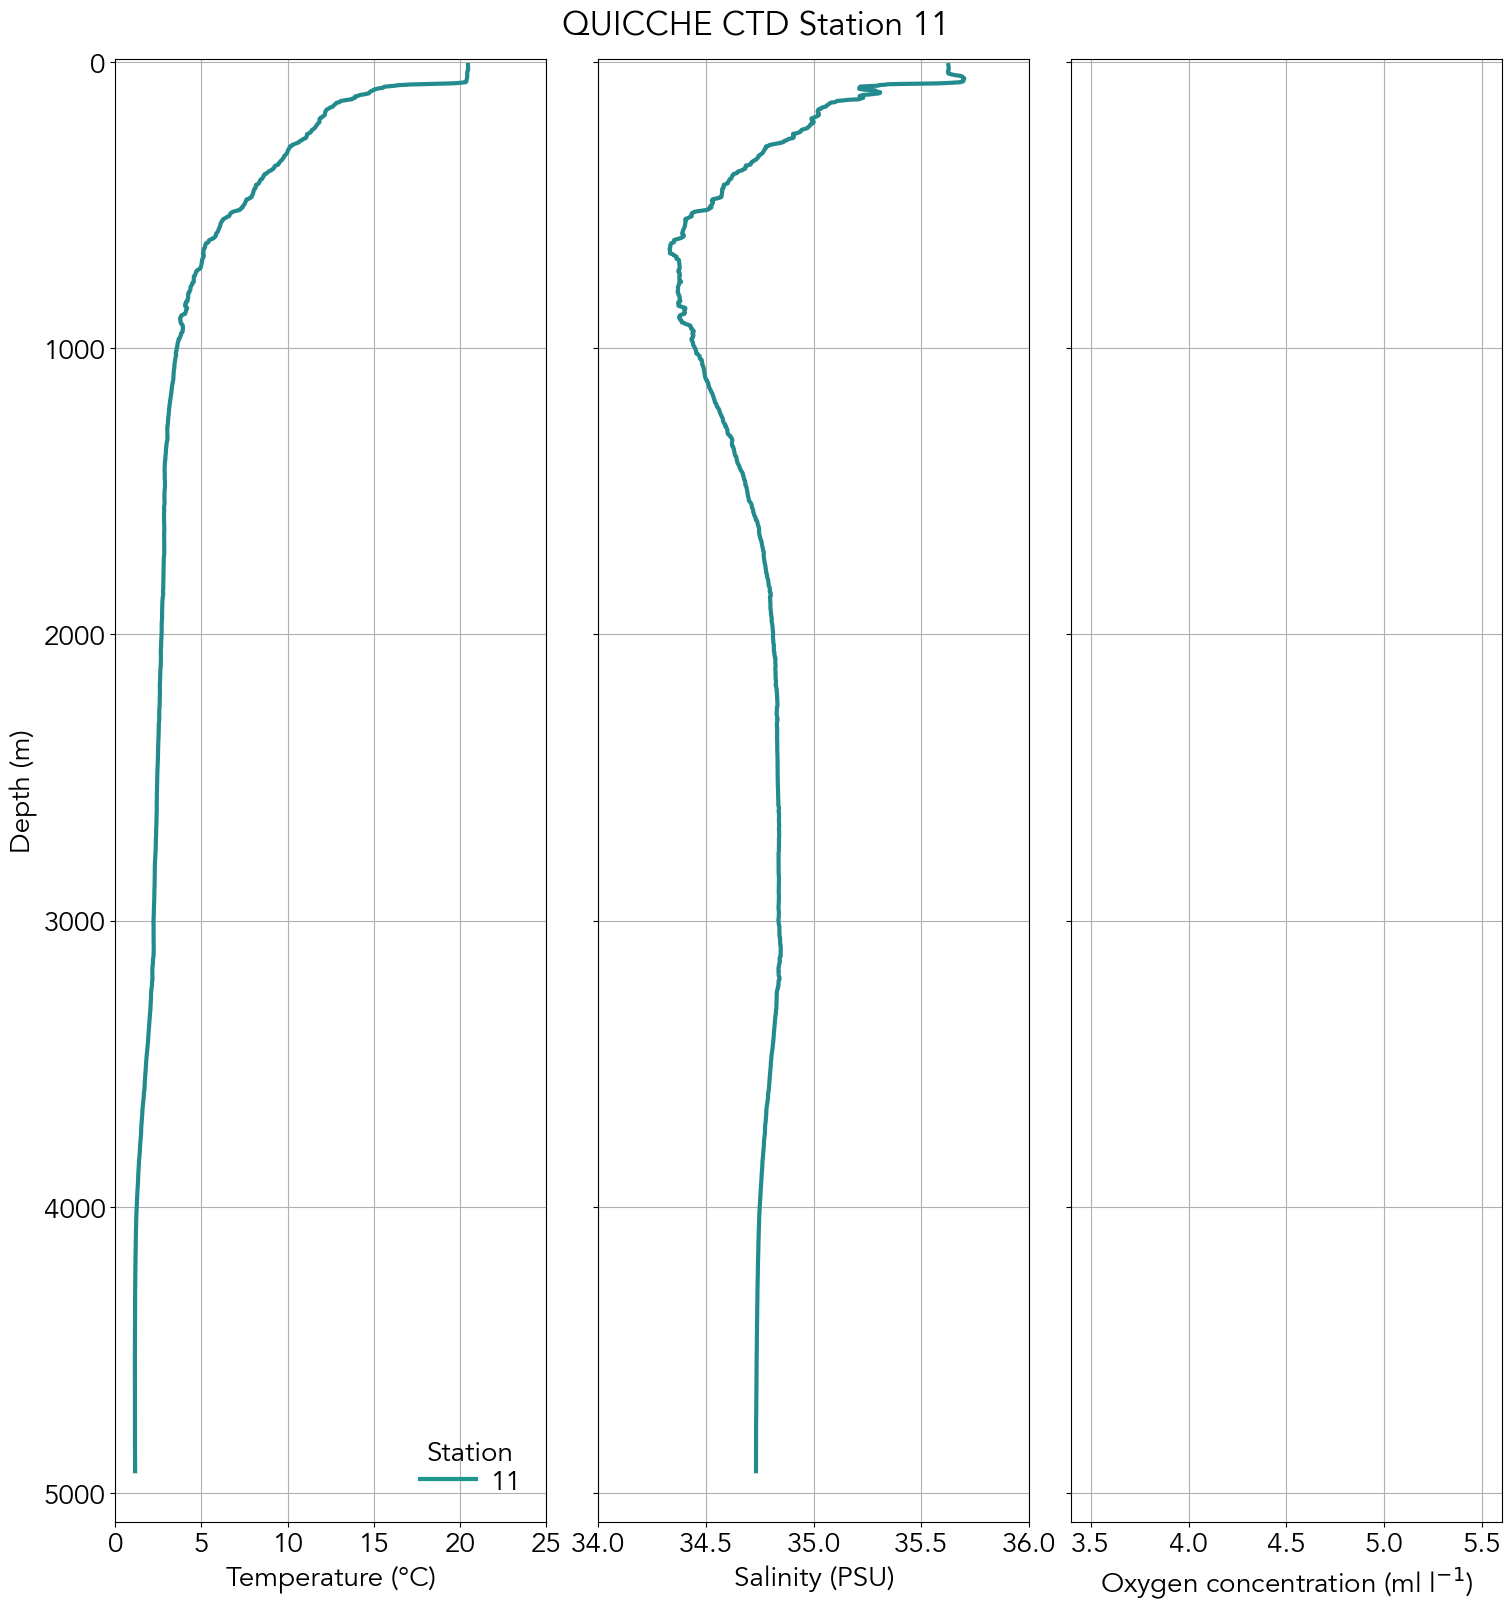

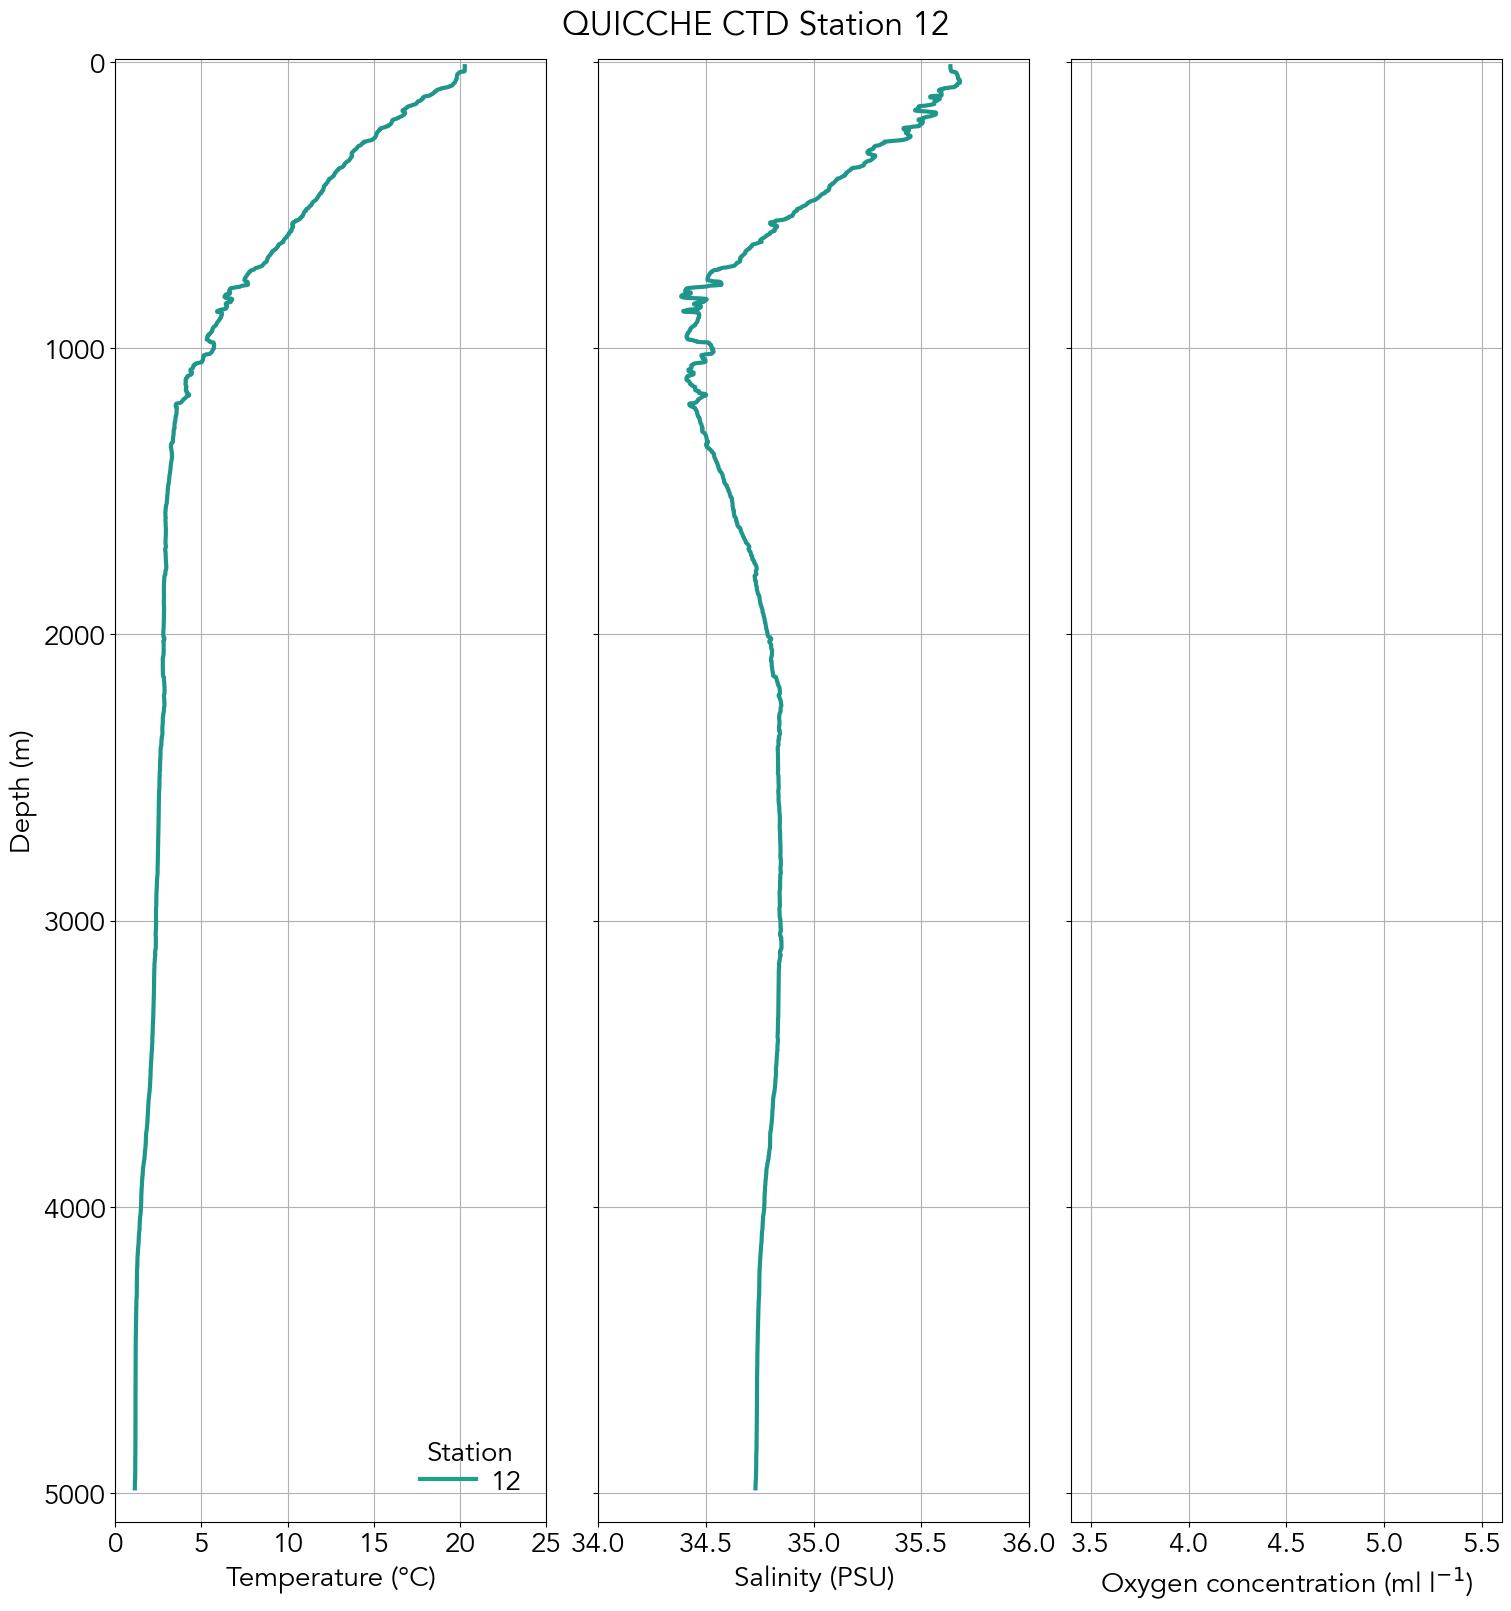

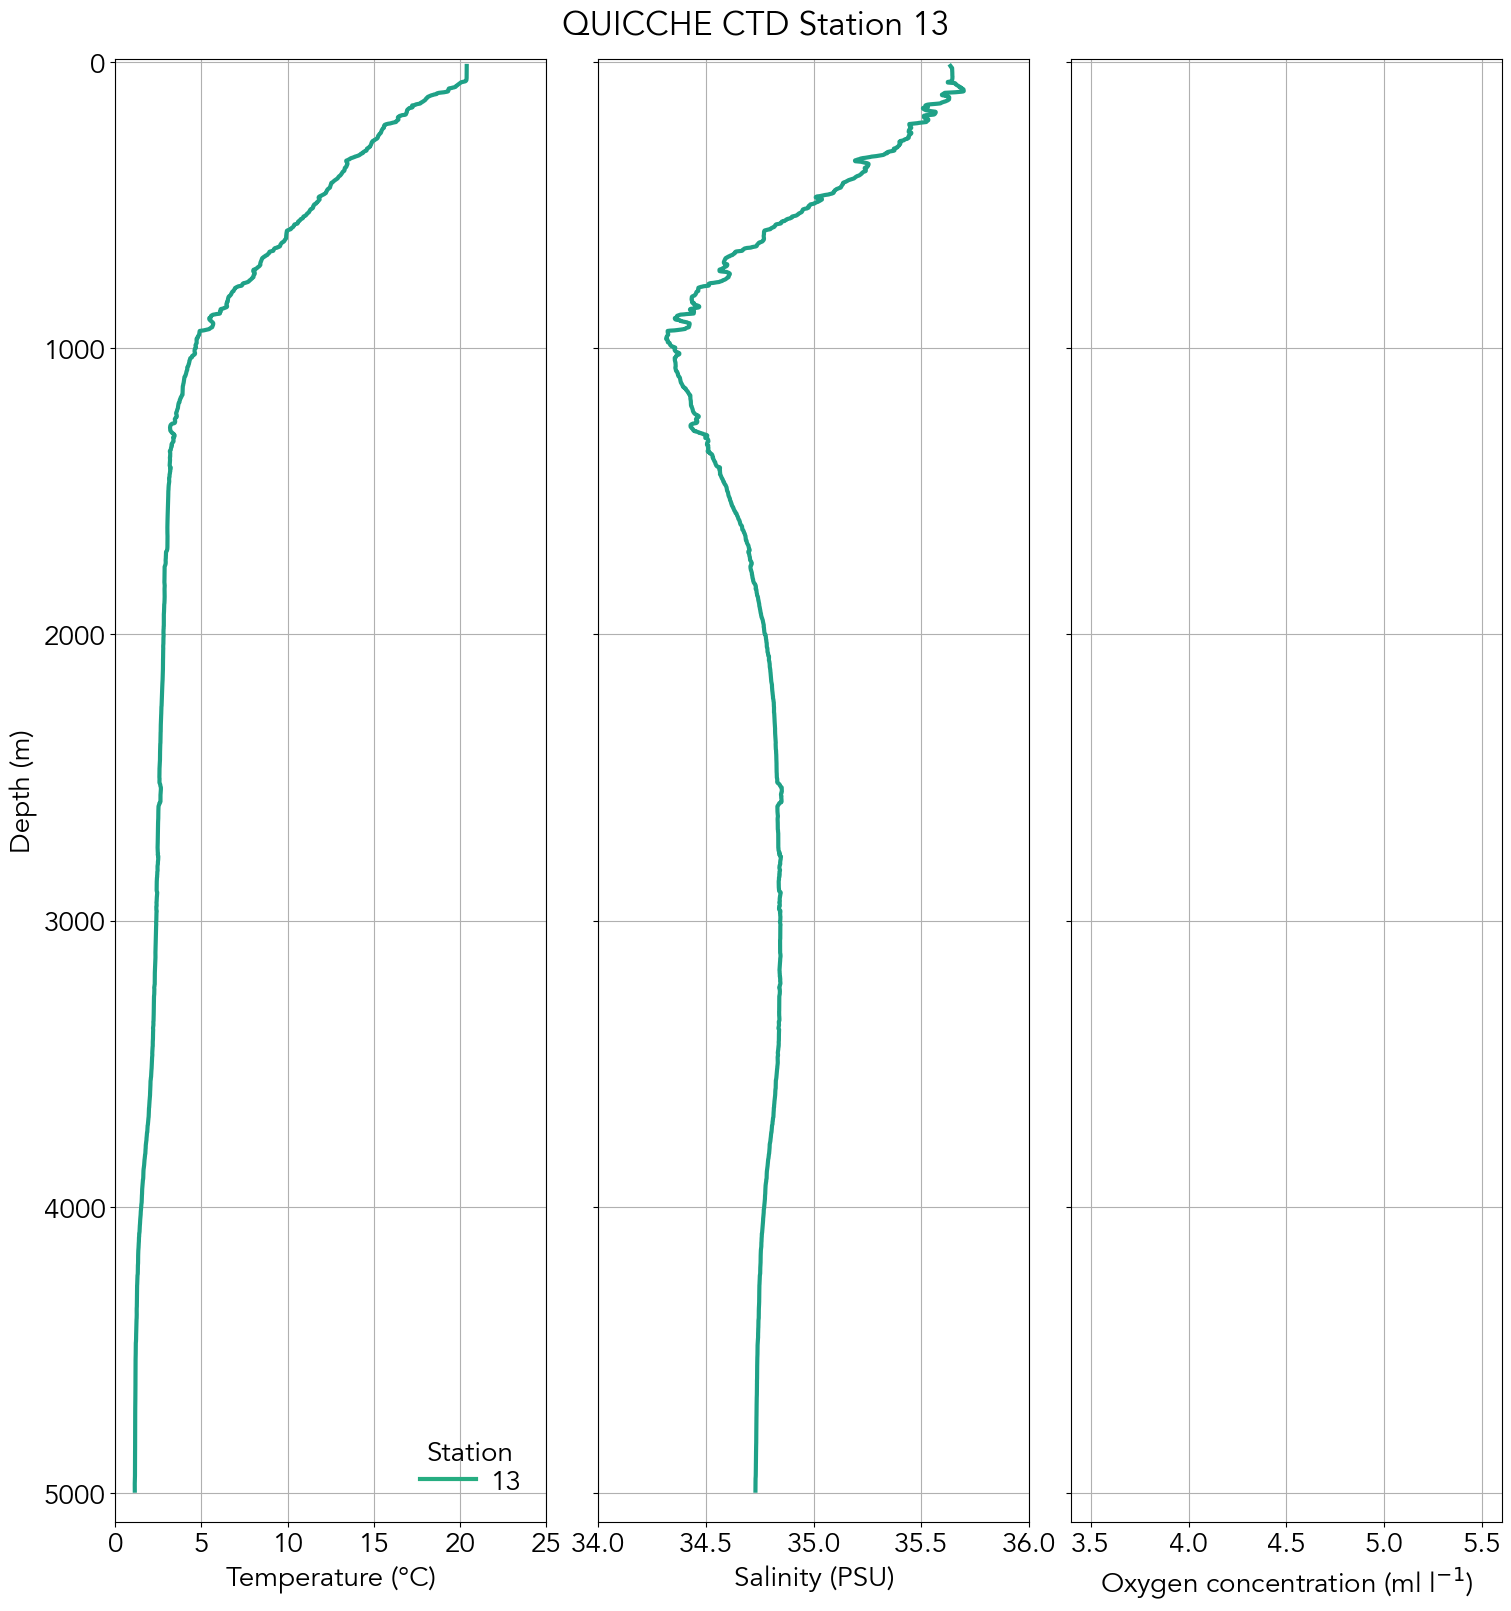

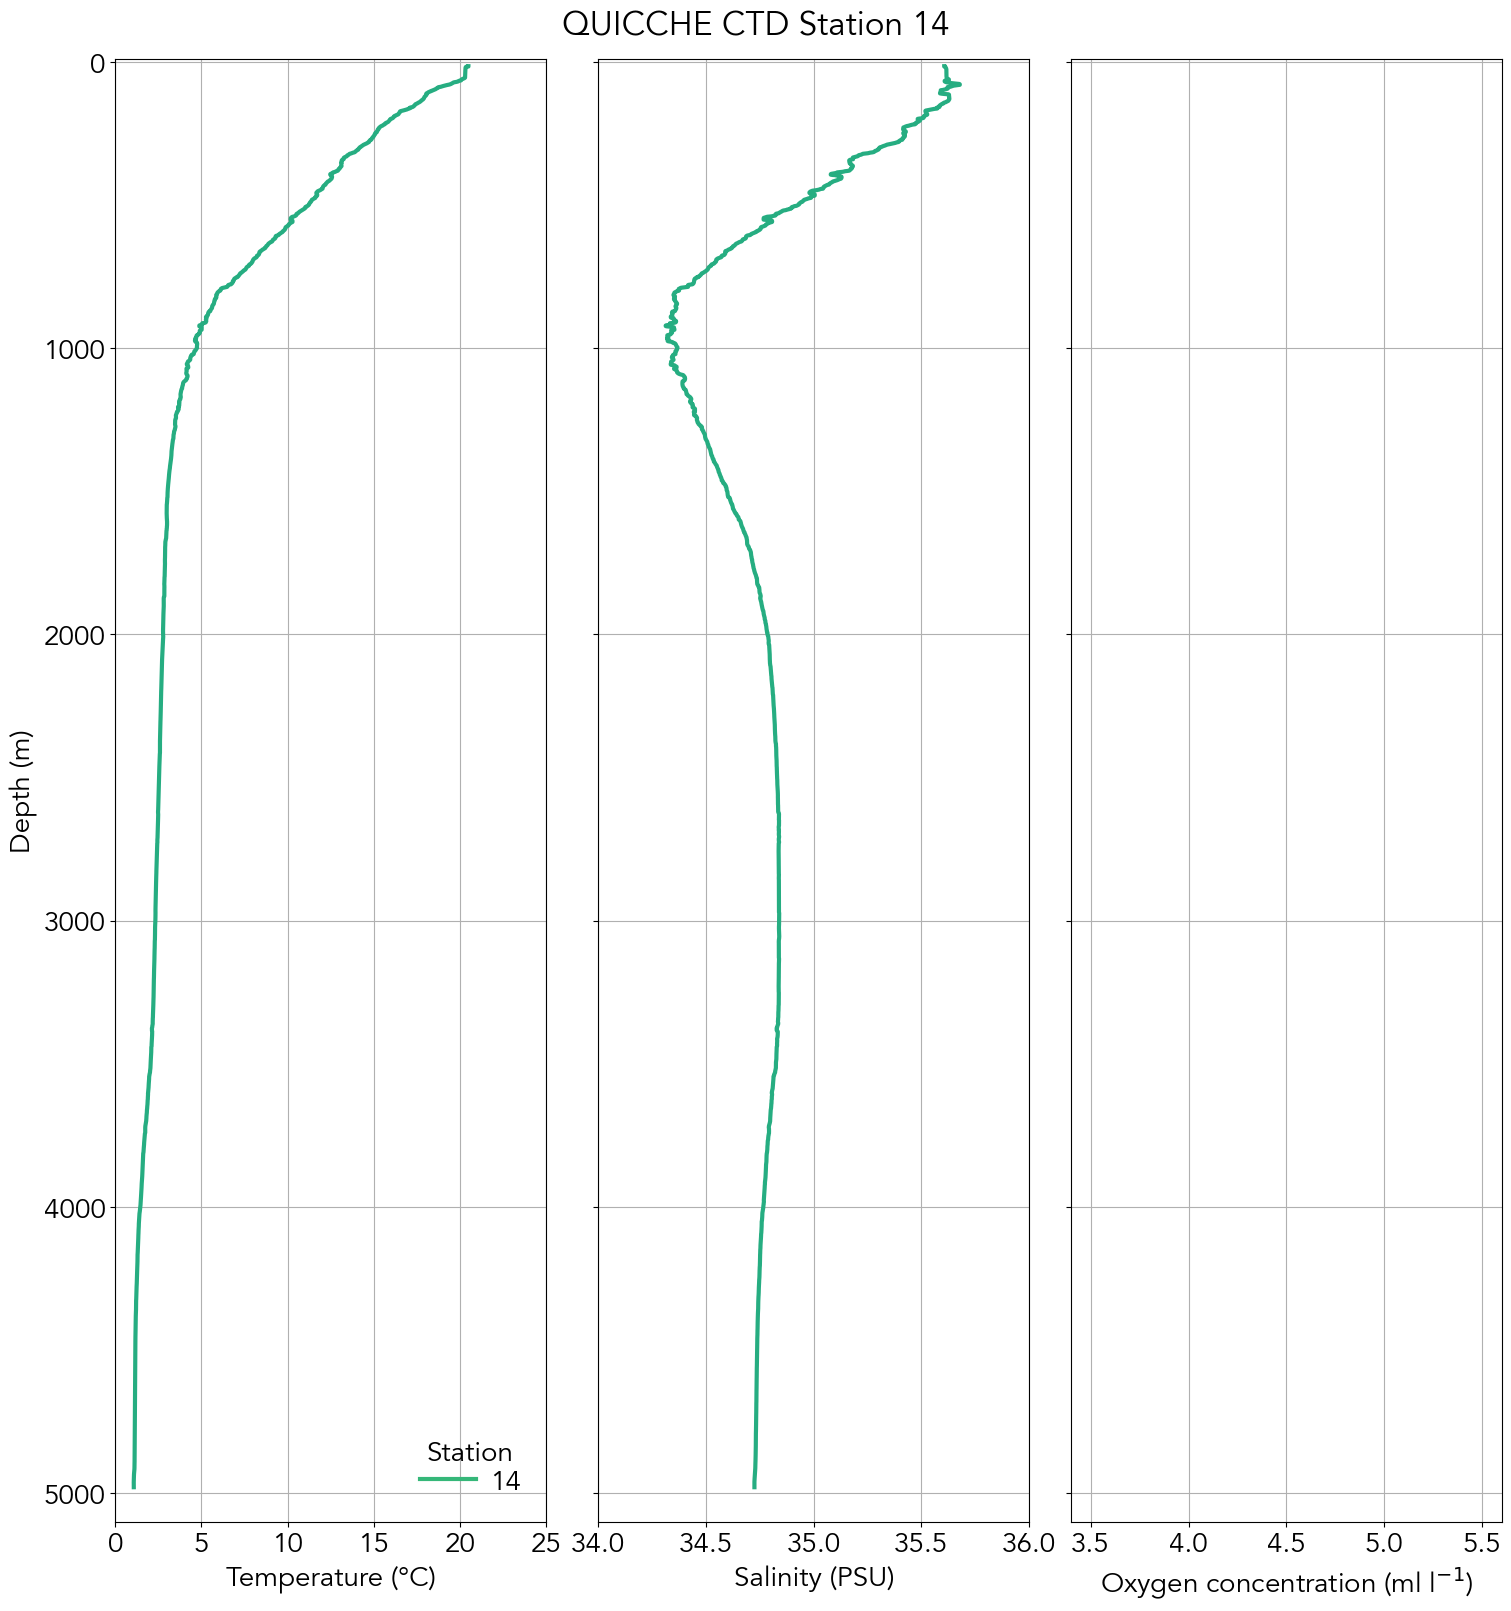

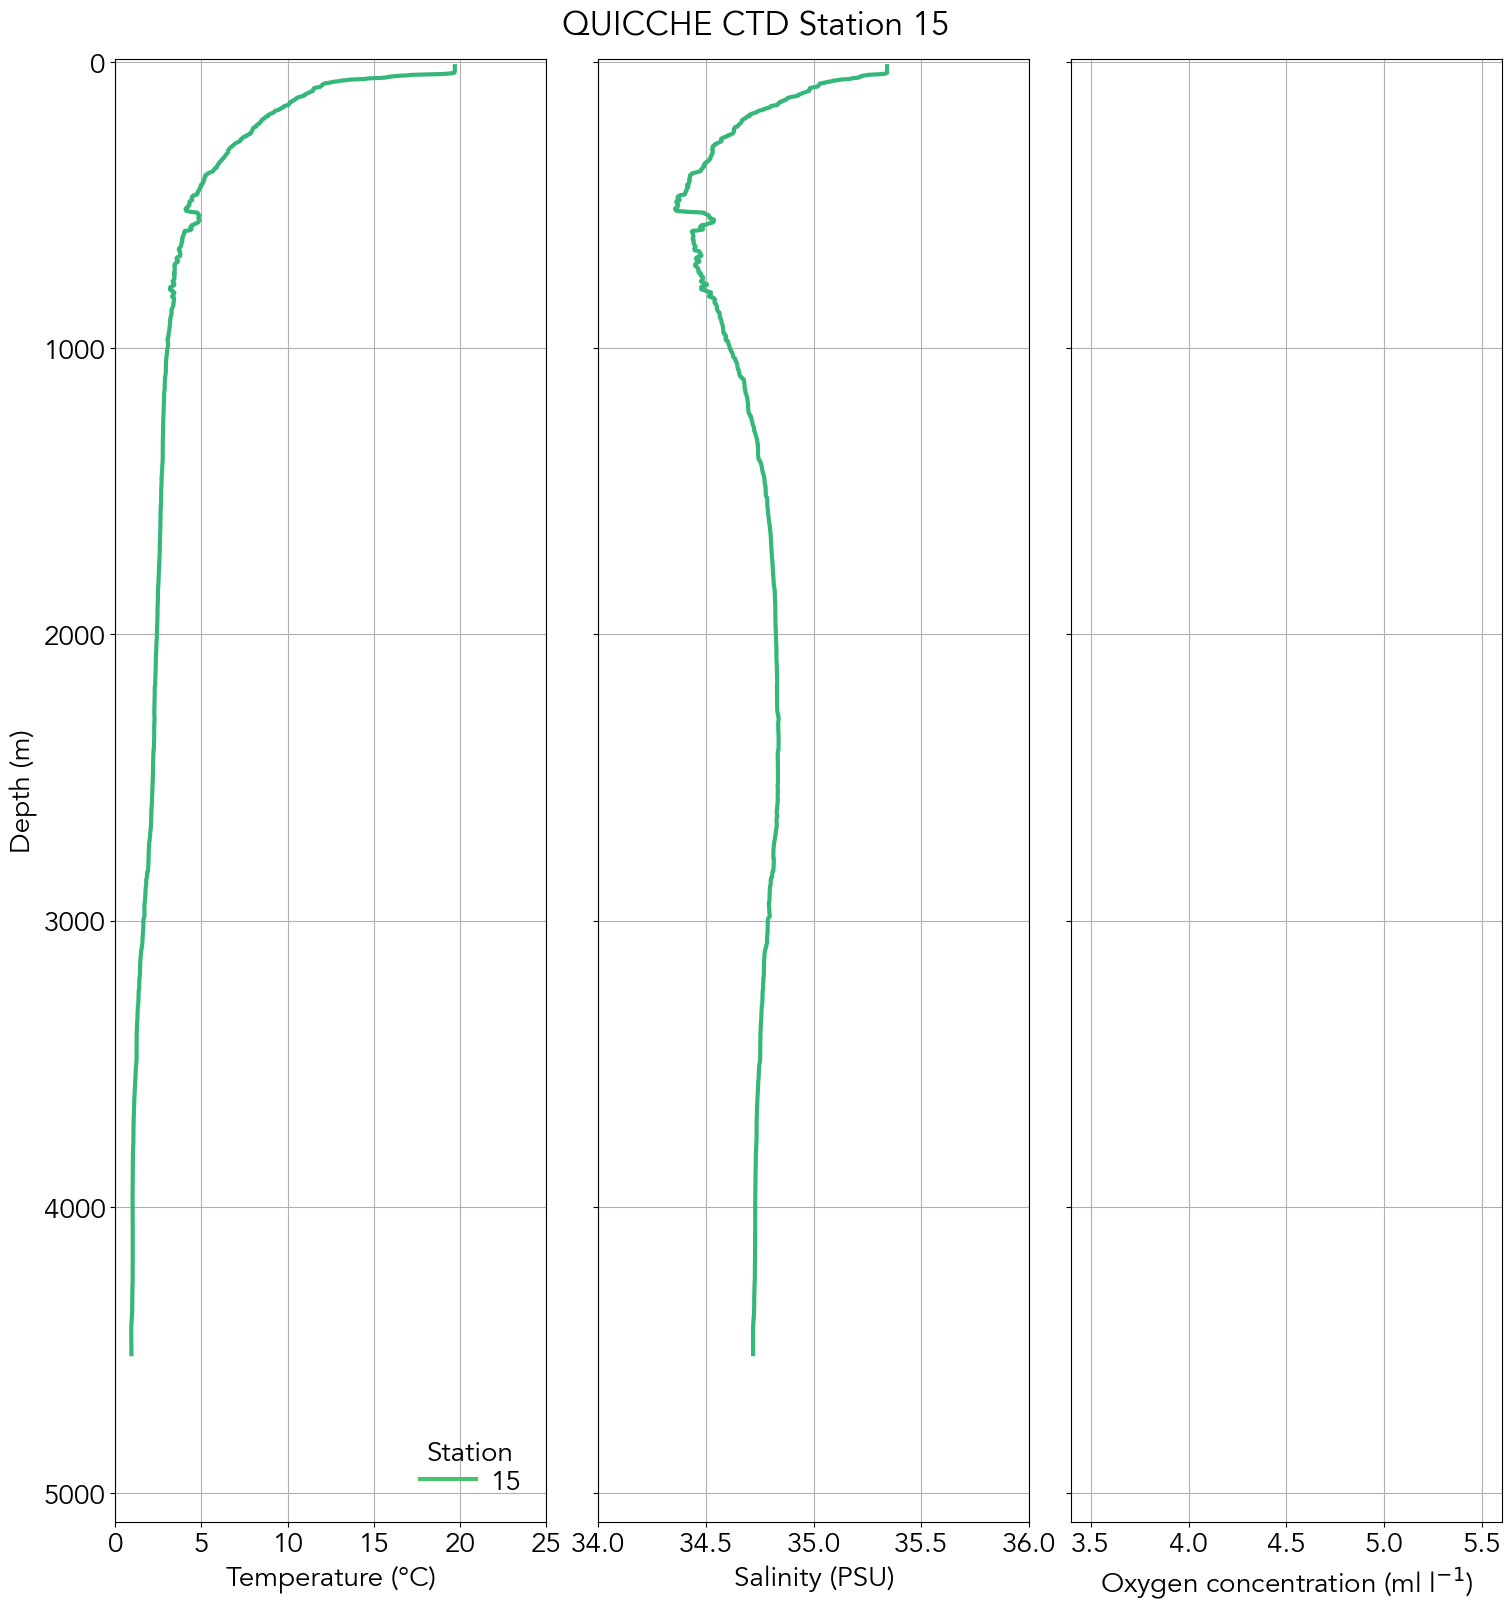

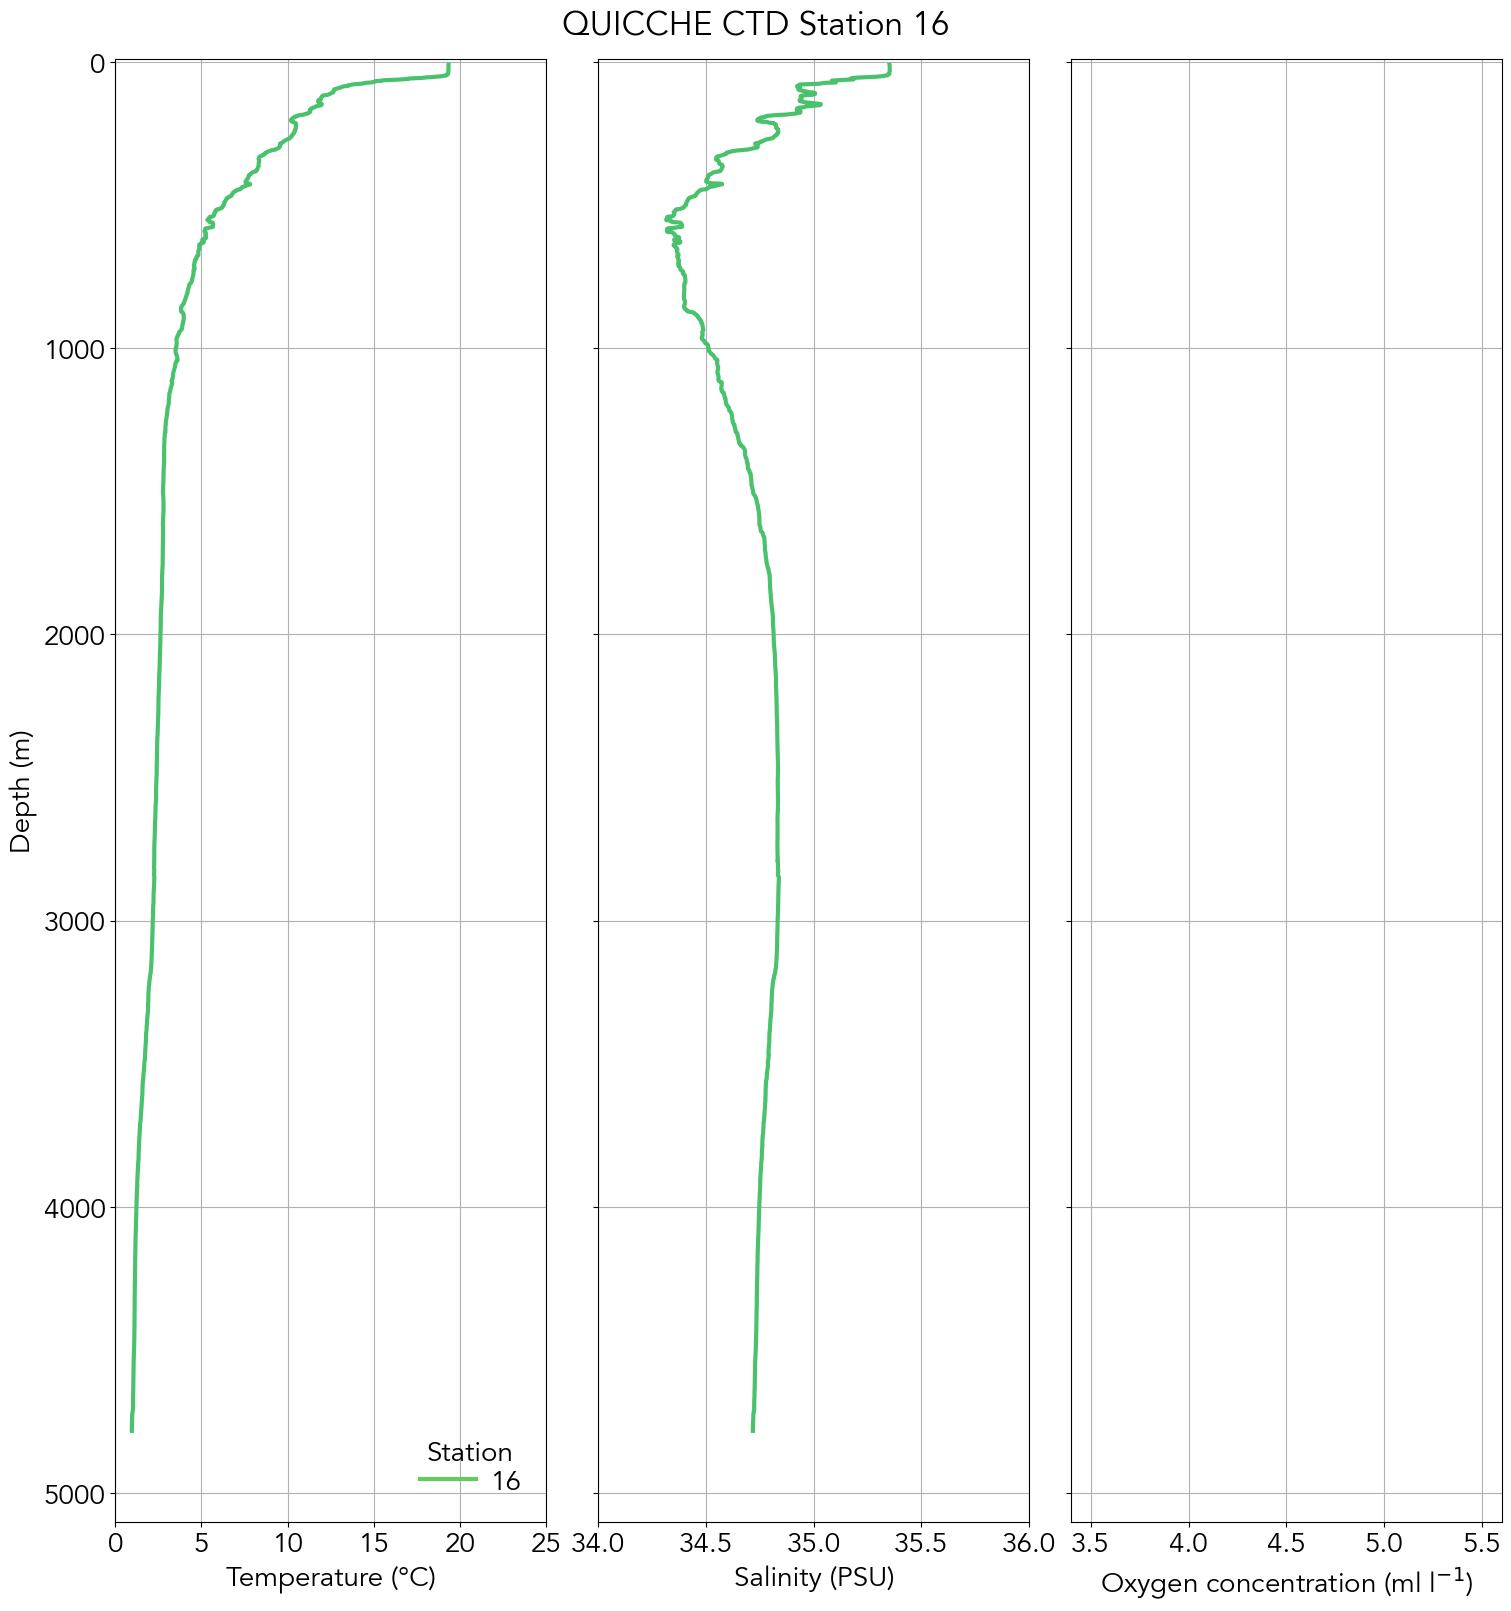

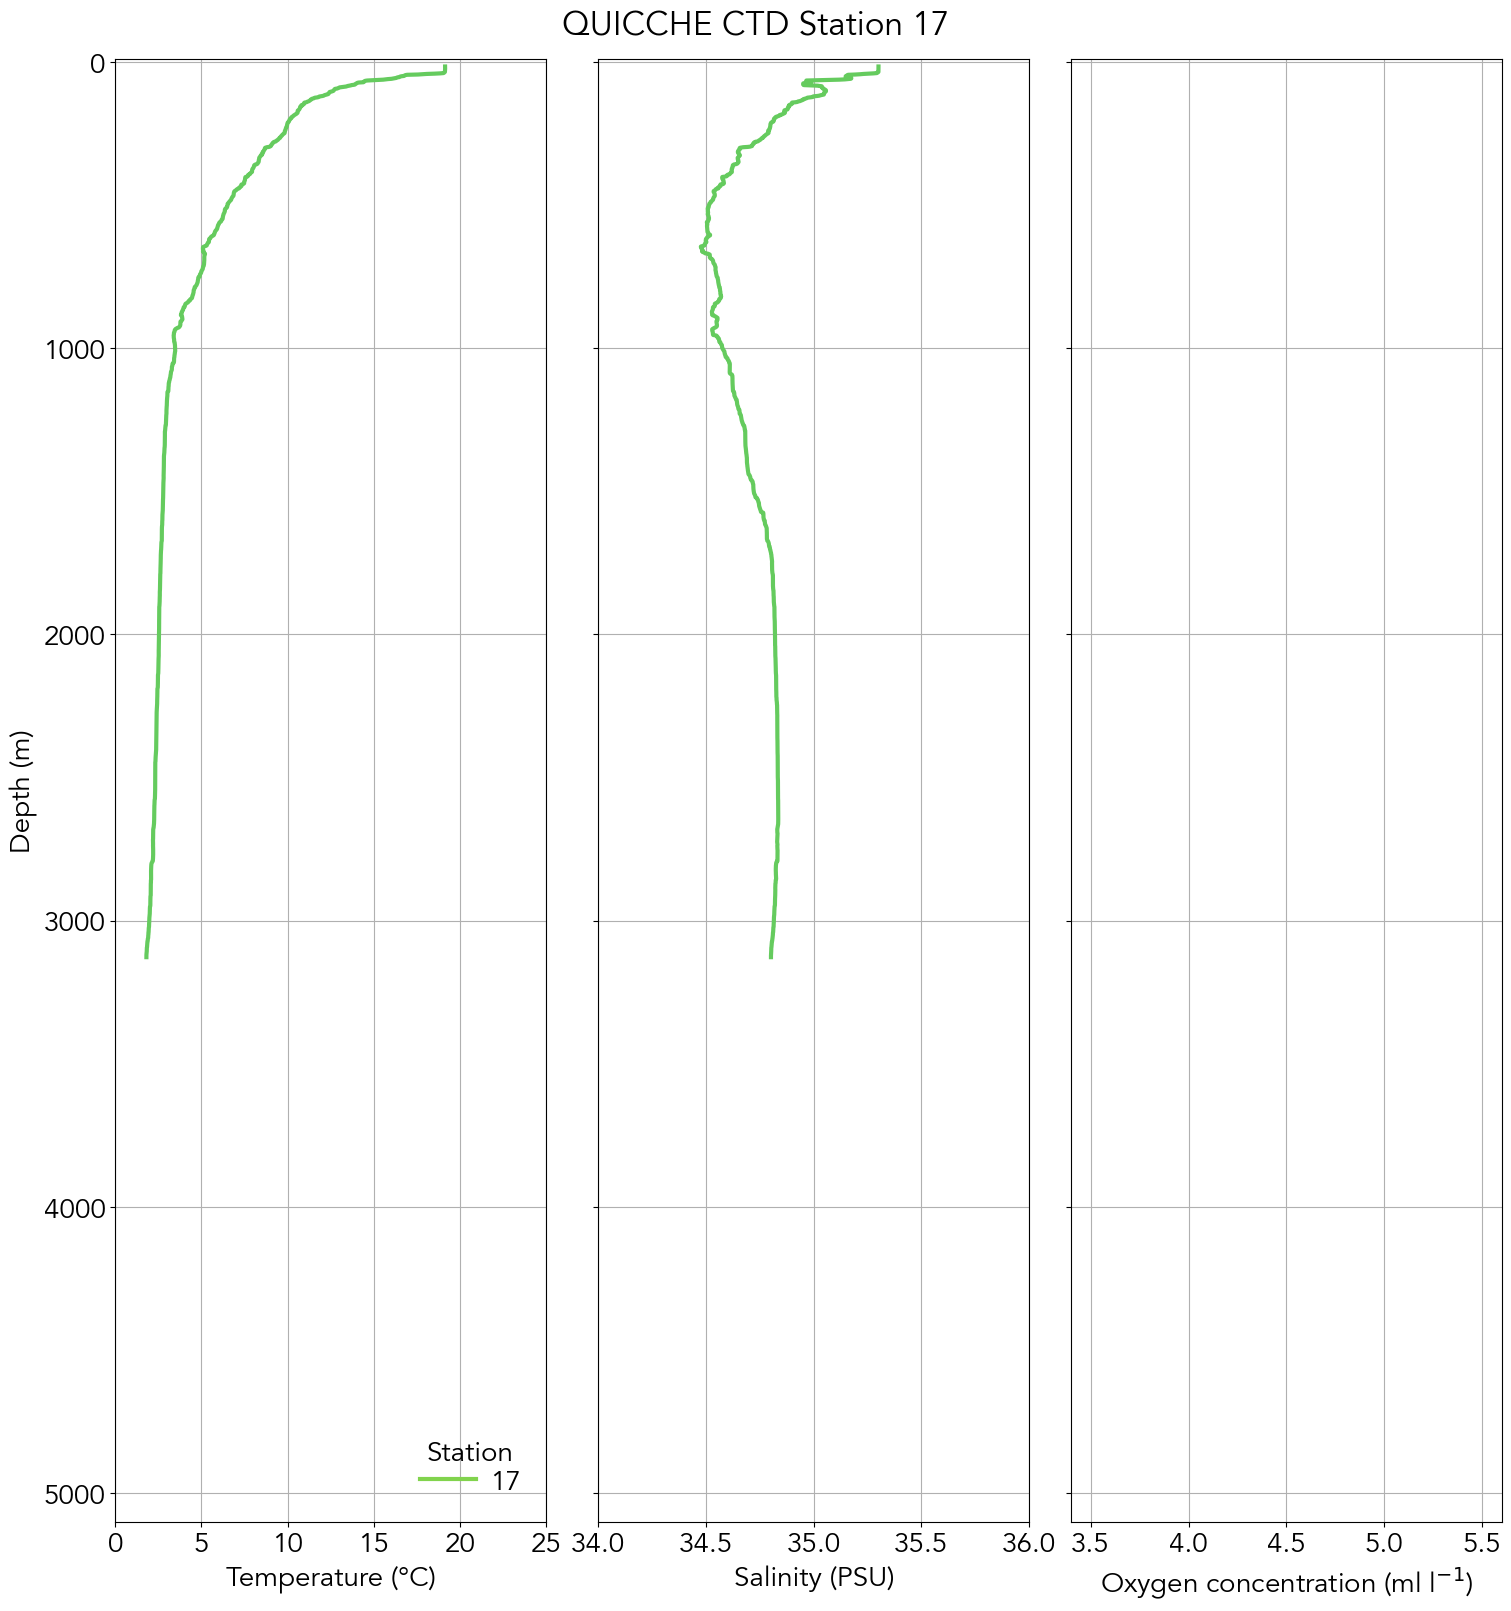

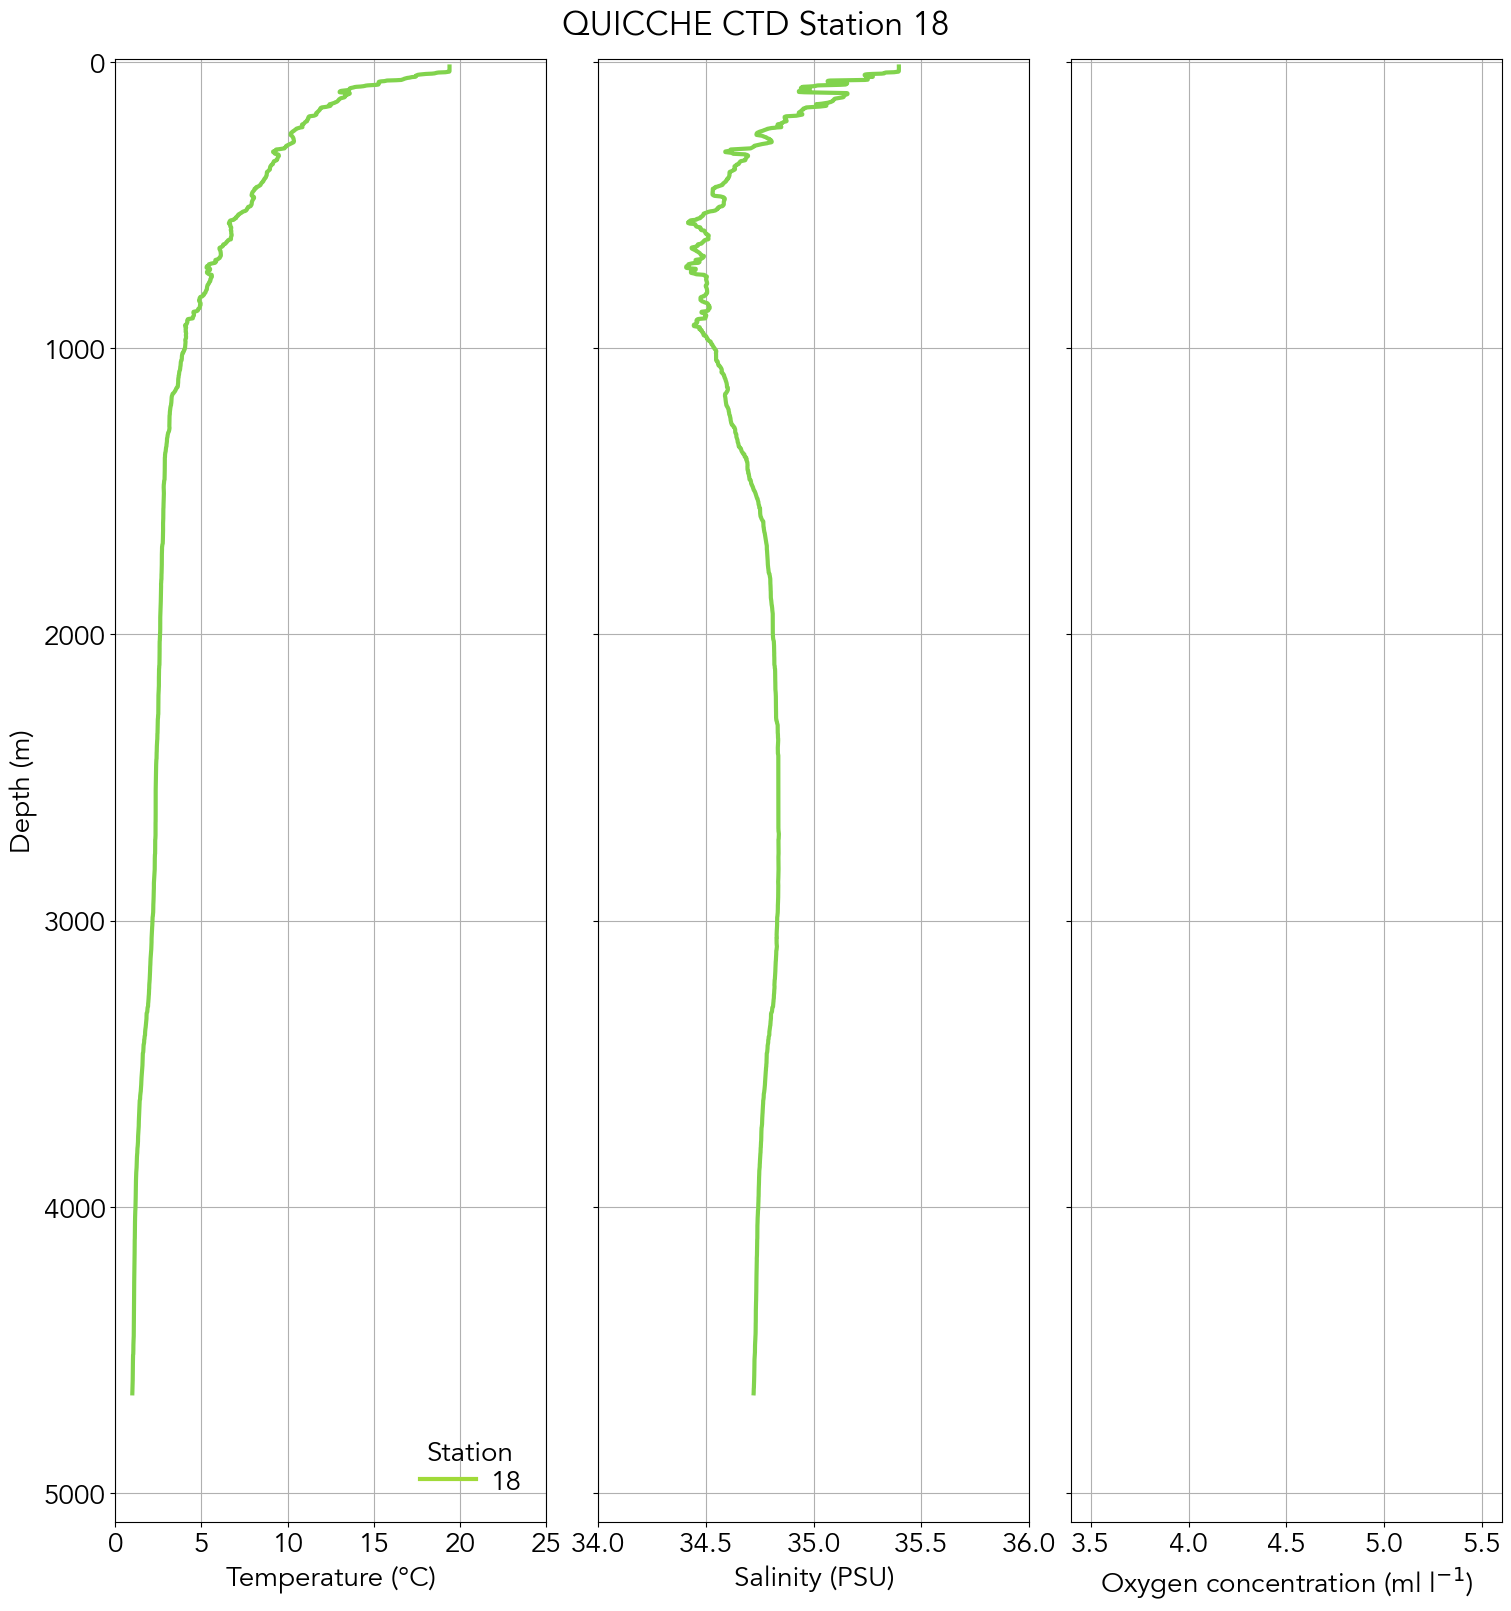

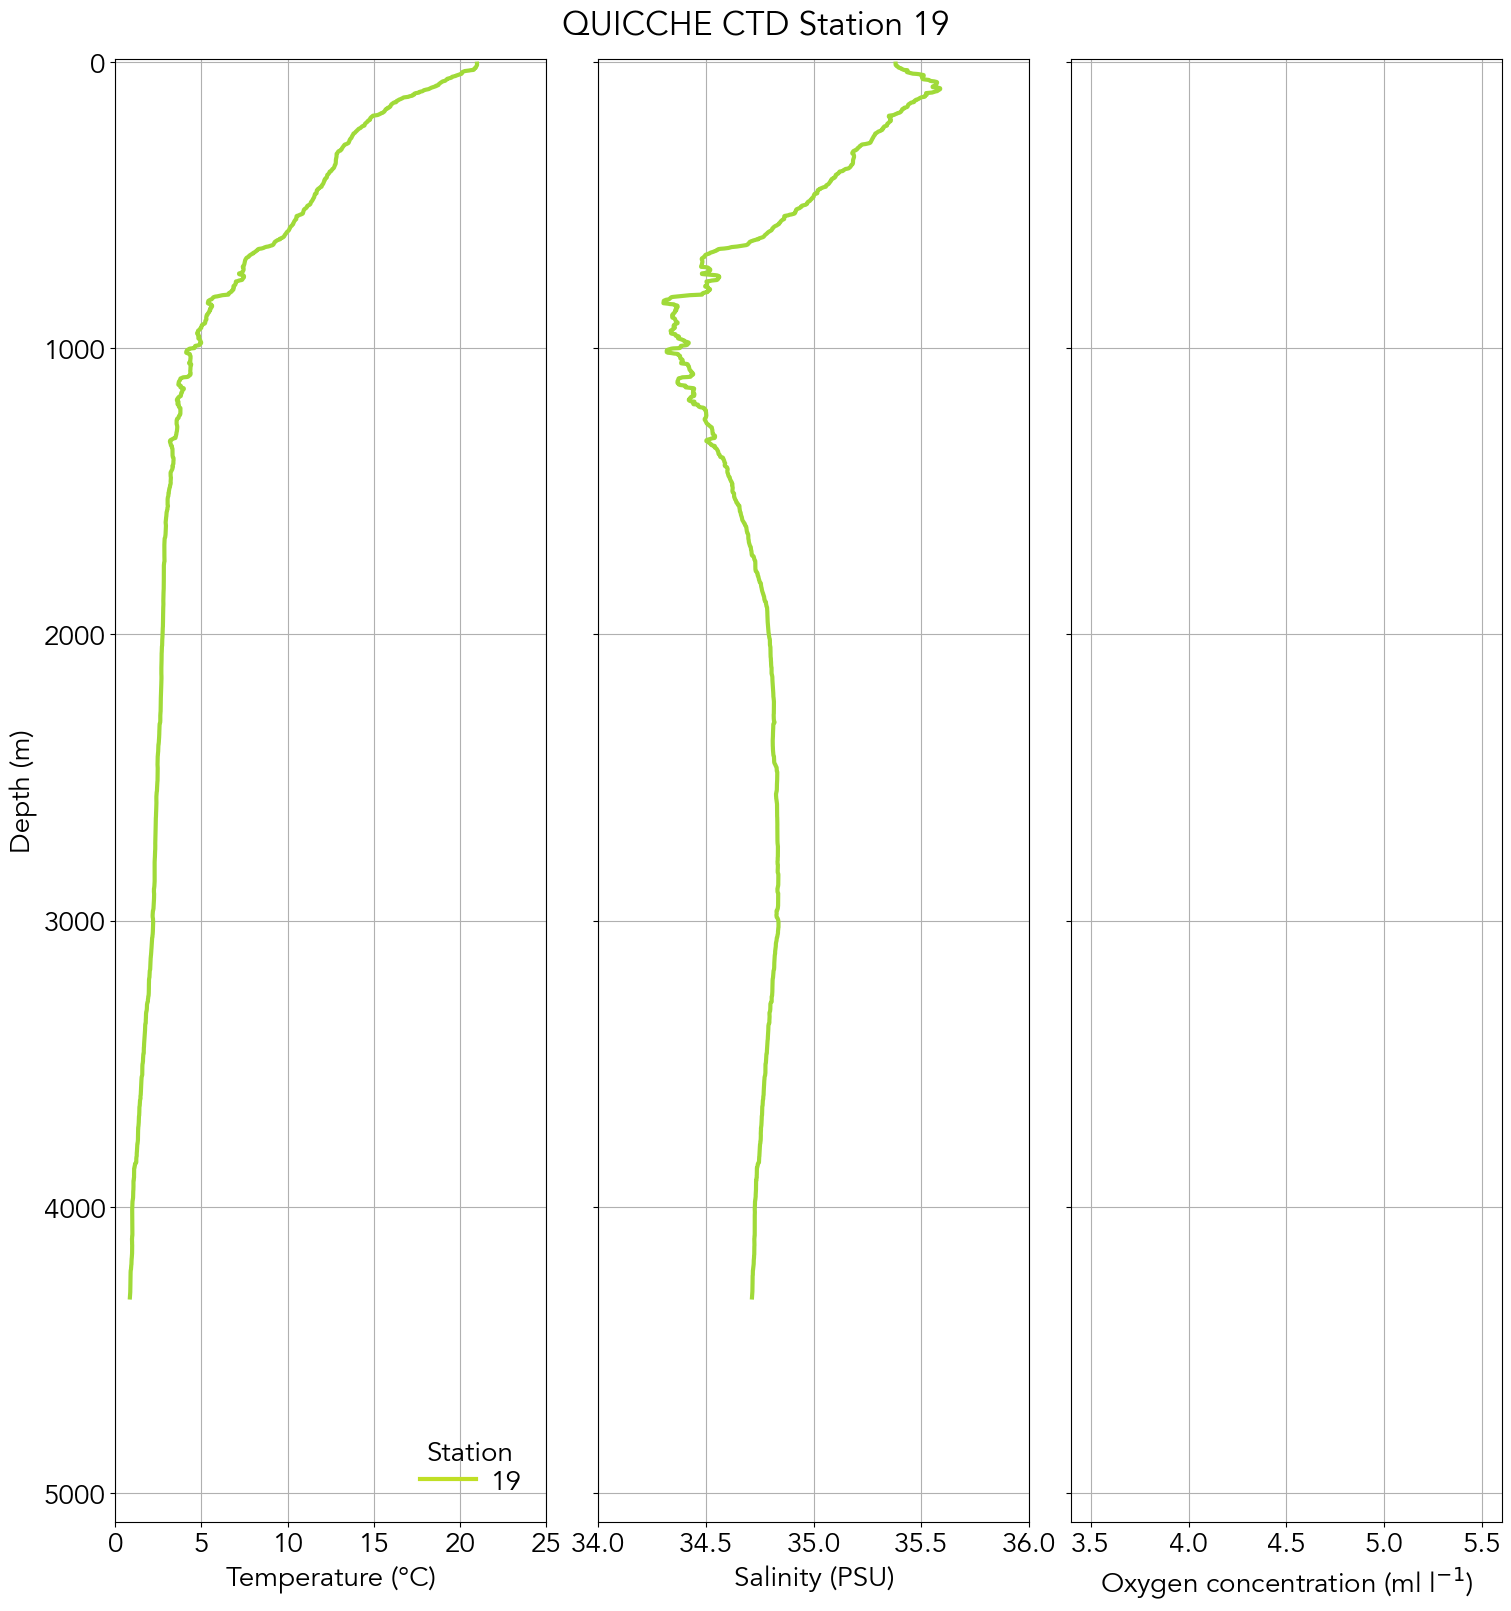

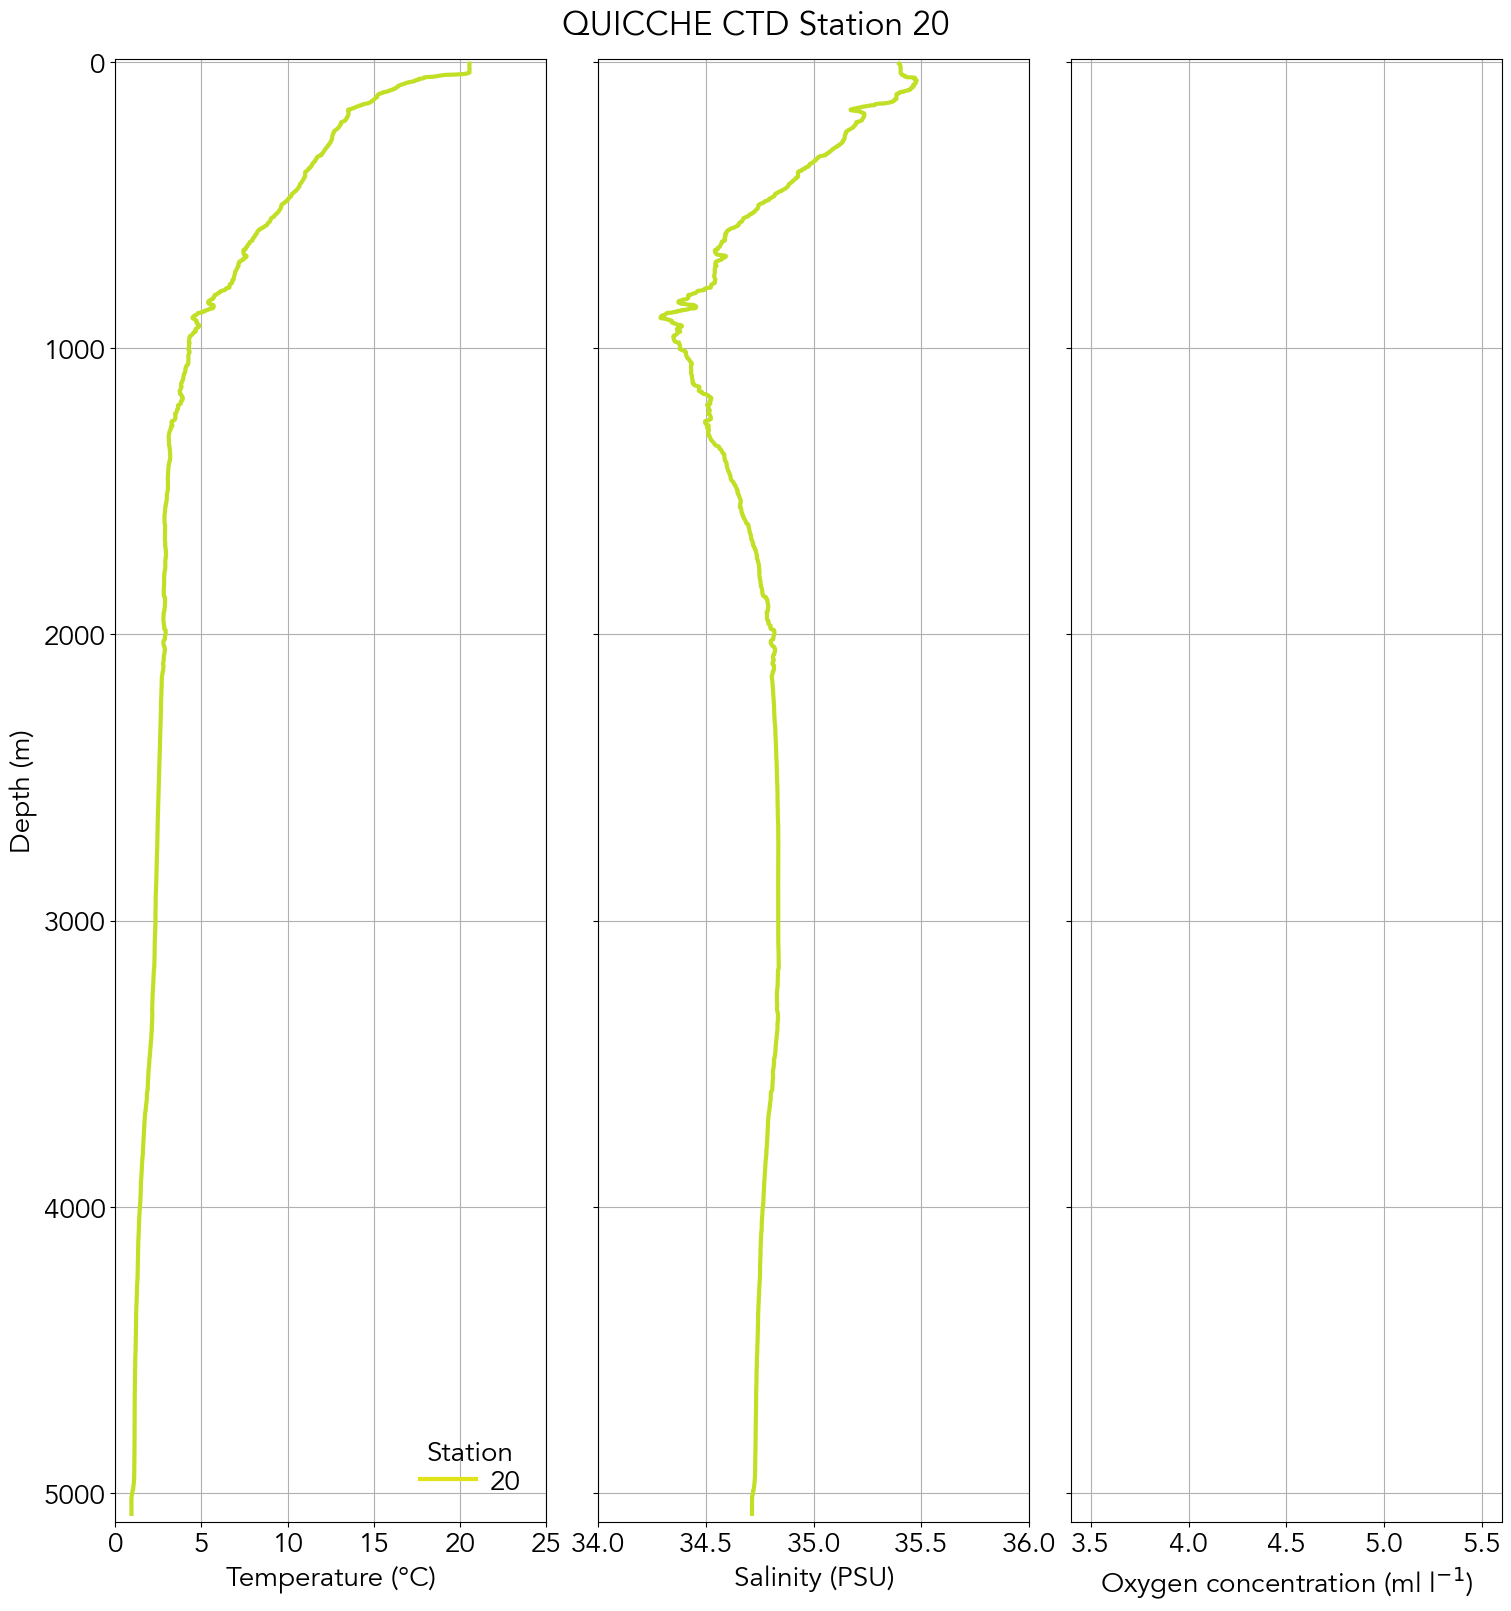

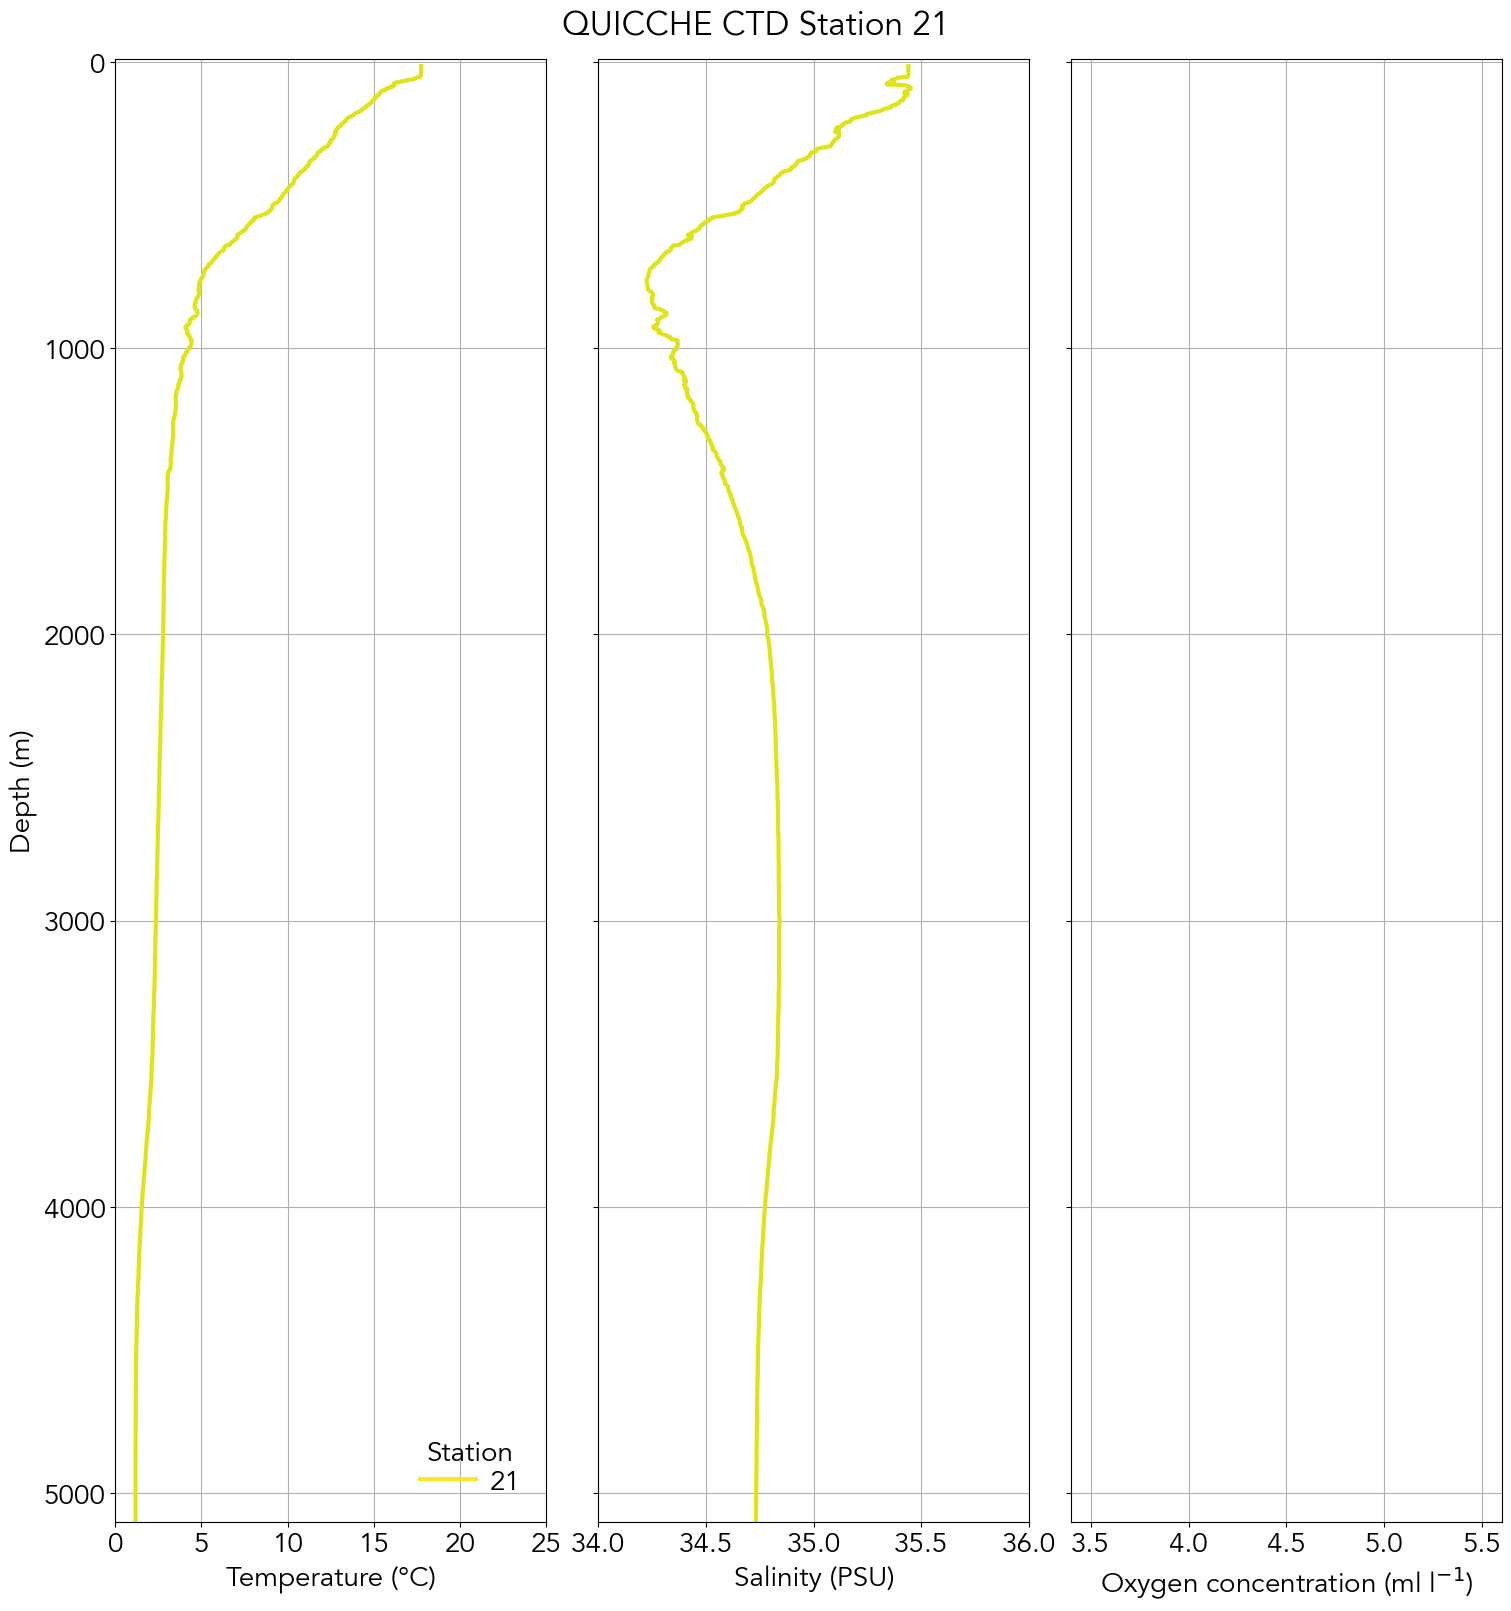

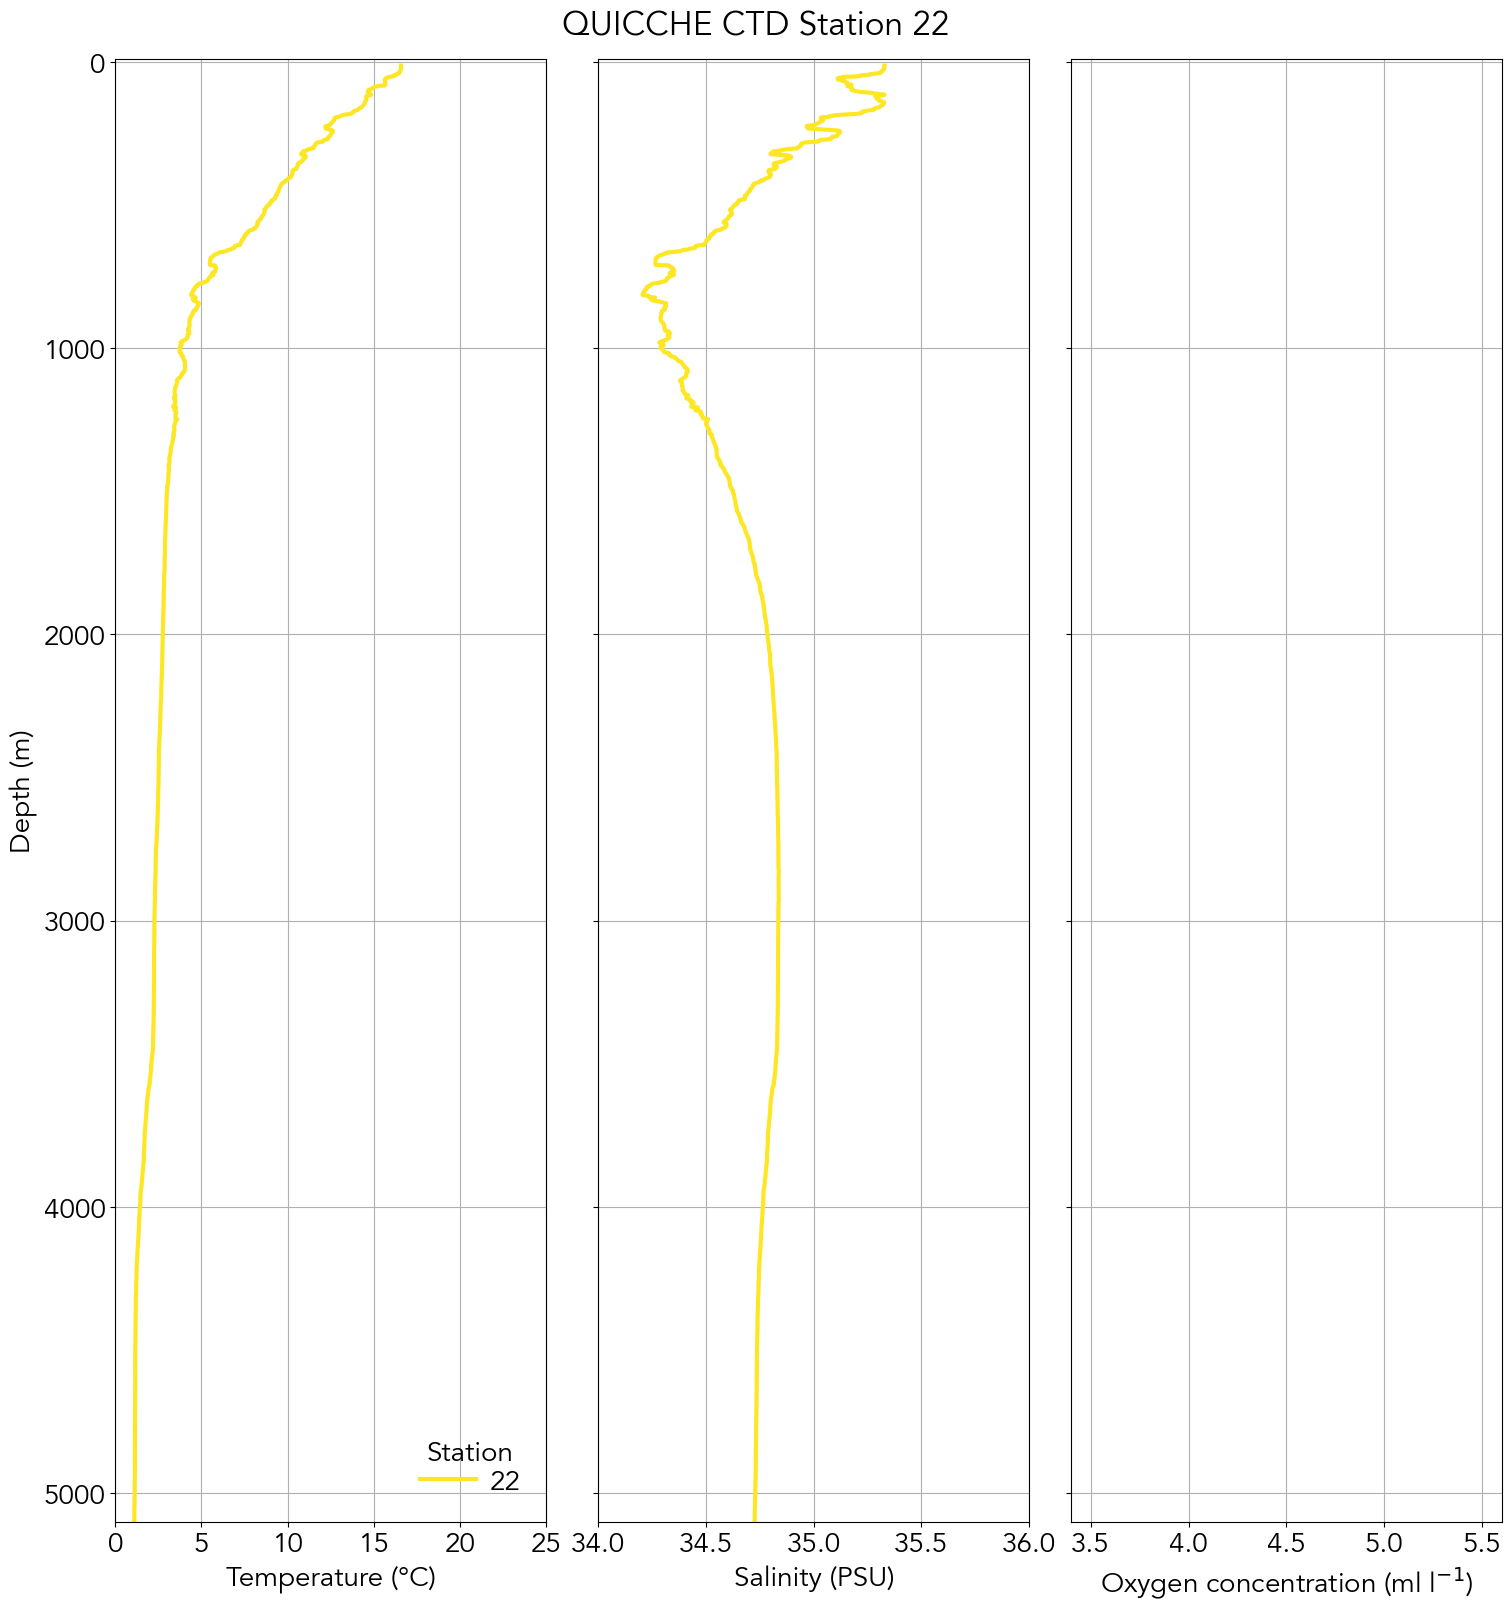

In [20]:
y = 5100
n = ds.station.max().values
cmap = plt.get_cmap('viridis',n)
var = ['temperature1','salinity1','oxygen_concentration']#,'beam_attenuation','beam_transmission','chlorophyll']
vmins = [0,34,3.4]
vmaxs = [25,36,5.6]

for i in range(n):
    fig,ax=plt.subplots(1,3,figsize=(15,16),sharey=True,constrained_layout=True)
    ax=ax.flatten()
    legends = []
    for j in range(len(var)):
        ds[var[j]].sel(station=i+1).squeeze().rolling(pressure=5,center=True).median('pressure').plot(y='pressure',
                                                                                                      hue='station',
                                                                                                      ax=ax[j],
                                                                                                      ylim=(y,-10),
                                                                                                      c=cmap(0+i)[:3],
                                                                                                      xlim=(vmins[j],vmaxs[j]),
                                                                                                      lw=3)
        ax[j].set(title='',ylabel=['Depth (m)','','','Depth (m)','',''][j],xlabel=['Temperature (°C)',
                                                                                   'Salinity (PSU)',
                                                                                   'Oxygen concentration (ml l$^{-1}$)',
                                                                                   'Beam attenuation (m$^{-1}$)',
                                                                                   'Beam transmission (%)',
                                                                                   'Chlorophyll-a (kg m$^{-3}$)'][j])
        ax[j].grid()

    legends.append(Line2D([0], [0], color=cmap(1+i)[:3], lw=3, label=f'{1+i}'))

    ax[0].legend(handles=legends,
                 ncol=2,
                 labelspacing=0.01,
                 handletextpad=0.5,
                 fontsize=20,
                 loc='lower right',
                 columnspacing=.5,
                 frameon=False,
                 title='Station')

    fig.suptitle(f'QUICCHE CTD Station {i+1}')
    plt.savefig(f"/Users/xedhjo/Documents/Projects/QUICCHE/data/CTD/figures/Station_{str(ds.sel(station=i+1).station.values).zfill(2)}.png")